# drifter: a python package for cleaning and analyzing drifting sea ice buoy data

The functions in the drifter library were developed to process IABP and MOSAiC buoy drift tracks. Disclaimer: This is research code, and is subject to change as I find better ways to do things.

The procedure for cleaning and interpolating the MOSAiC drifting buoy data proceeds as follows.
1. Begin with the processed data tracks from the Arctic Data Center.
2. Specify a maximum time step for the raw data. I use dt=2 hours. Names of buoys with median reporting frequency less than once every two hours are printed and skipped.
3. Adjust the time index for buoys 2019V1-V4, as there is an 8 hour offset compared to other co-located buoys
4. Skip buoys 2019P112-114 and 2019P119, as there are complex errors in the tracks that need to be handled individually.
5. Estimate the 99th percentile for interpolation errors for a +/- 12 H cubic spline interpolation. This is done because the error bounds for cubic splines are complicated, and may not be fully applicable to the autocorrelation and dynamical properties of buoys. 
6. Check for duplicated dates or reversed time direction
7. Flag gaps of larger than 4 hours. This step is repeated until no new gaps are recorded.
8. Flag repeated lat/lon position pairs. (For IABP data, there are often places where either lat or lon will have repeated data, as if ffill() was applied when one coordinate was missing)
9. Flag position outliers. Outliers are identified based on 
    - Distance between (x,y) and the median of the point and its immediate neighbors
    - Speed of the point, calculated as the min of the backward and forward differences for points with neighbors, and backward or forward difference alone if the point is next to a data gap
    - Difference between the point and the estimated position based on cubic spline interpolation using a window of +/- 12H.
    If the point is a local maximum for distance and speed, and the spline estimate error is larger than the given threshold (which is based on reporting frequency), then the point is flagged as an outlier.
10. Interpolation to a 1 hour grid using cubic spline interpolation. Interpolation within gaps is masked.
11. Velocity is calculated on the interpolated data using centered differences, except at points neighboring gaps, where forward and backward differences are used as appropriate. Velocity estimates (as well as the distances for step 9) are computed on a Lambert Equal Area Azimuthal grid.
12. Estimated velocity is rotated so that u and v are eastward and northward velocity components.


TBD: Update metadata (frequencies, DN Station ID)

# Presenting results of buoy processing, justifying steps

115 P-sites. Of these: 67 in Leg 1, 18 in Leg 3, and 30 in Leg 5.

In [1]:
import numpy as np
import os
import pandas as pd
import proplot as pplt
import sys
from scipy.spatial.distance import cdist
sys.path.append('../../drifter/')
import utilities.cleaning as clean
import utilities.interpolation as interp

from importlib import reload
clean = reload(clean)
interp = reload(interp)

/opt/miniconda3/envs/drifter/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


I begin with the Level 2 drift track data from the Arctic Data Center (Bliss et al. 2021). 
Duplicated timestamps and out-of-range data were filtered out.


In [2]:
# Folder with the drift tracks from 
# the Arctic Data Center (Bliss et al. 2021)
# https://arcticdata.io/catalog/view/urn%3Auuid%3A2b859a39-cada-4147-819a-dc222f6f89a3
dataloc = '../../data/adc_dn_tracks/'
saveloc = '../data/mosaic_interpolated/'
# Maximum gap in hours for the interpolation algorithm
max_dt = 2

# Compute uncertainty threshold for splines?
recompute_thresh = False

# Pad for interpolation, so that the first and last values aren't missing.
margin = pd.to_timedelta('6H')

# Optional: focus in on only a portion of the tracks
begin = '2019-10-01 00:00'
end = '2022-01-01 00:00'

# Read in the files, including the metadata file
files = os.listdir(dataloc)
files = [f for f in files if f.split('.')[-1] == 'csv']
files = [f for f in files if f.split('_')[0] != 'DN']

metadata = pd.read_csv(dataloc + 'DN_buoy_list_v2.csv')
metadata['filename'] = ['_'.join([x, str(y), z]) for 
                        x, y, z in zip(metadata['DN Station ID'],
                                       metadata['IMEI'],
                                       metadata['Sensor ID'])]
    
file_present = np.array([f + '.csv' in files for f in metadata.filename])
metadata = metadata.loc[file_present].copy()
metadata.set_index('Sensor ID', inplace=True)

buoy_data = {}
for file in files:
    data = pd.read_csv(dataloc + file, index_col='datetime', parse_dates=True)

    # Apply checks for duplicate dates and duplicate positions
    # TBD: add step to count the number of checks
    # Could also retain the duplicate flag until the end
    data['date_flag'] = clean.check_dates(data, date_index=True)
    data['dupl_flag'] = clean.check_duplicate_positions(data, date_index=True, pairs_only=True)
    data = data.loc[(data['date_flag'] + data['dupl_flag']) < 1, ['latitude', 'longitude']].copy()        

    buoy = file.replace('.csv', '').split('_')[-1]
    buoy_data[buoy] = data.copy() 

# Based on comparison with co-located sites, all the V buoys have time indices offset by 8 hours.
for buoy in ['2019V1', '2019V2', '2019V3', '2019V4', '2019V5']:
    buoy_data[buoy].index = buoy_data[buoy].index - pd.to_timedelta('8H')
# Buoys 2019P112-114 have problems that need to be cleaned individually
buoy_data = {buoy: buoy_data[buoy] for buoy in buoy_data if buoy not in ['2019P112', '2019P113', '2019P114', '2019P119']}

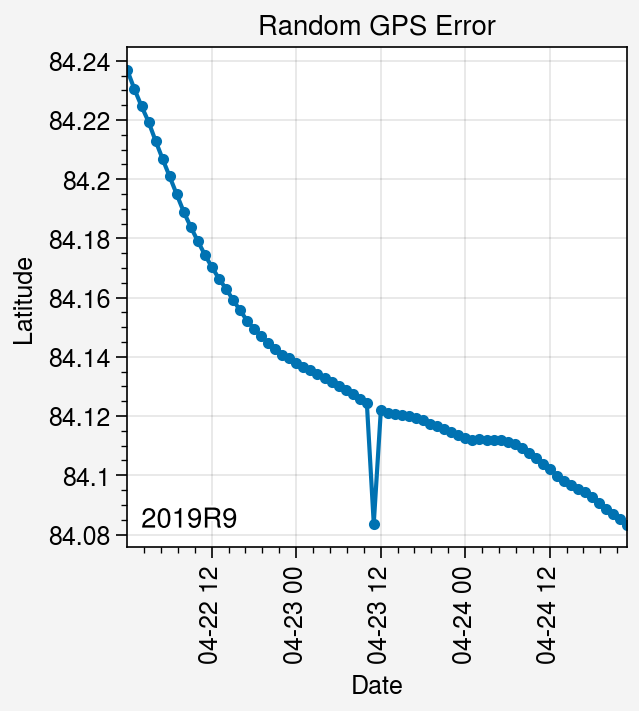

In [3]:
# Example of error
# Re-do in the manuscript subfolder
fig, ax = pplt.subplots()
buoy_df = buoy_data['2019R9']
timeslice = slice('2020-04-22', '2020-04-24')
ax.plot(buoy_df.loc[timeslice, 'latitude'], marker='.')
ax.format(xlabel='Date', ylabel='Latitude', title='Random GPS Error', lltitle='2019R9')
fig.save('../sample/random_gps_error.jpg', dpi=72)

<AxesSubplot:xlabel='datetime'>

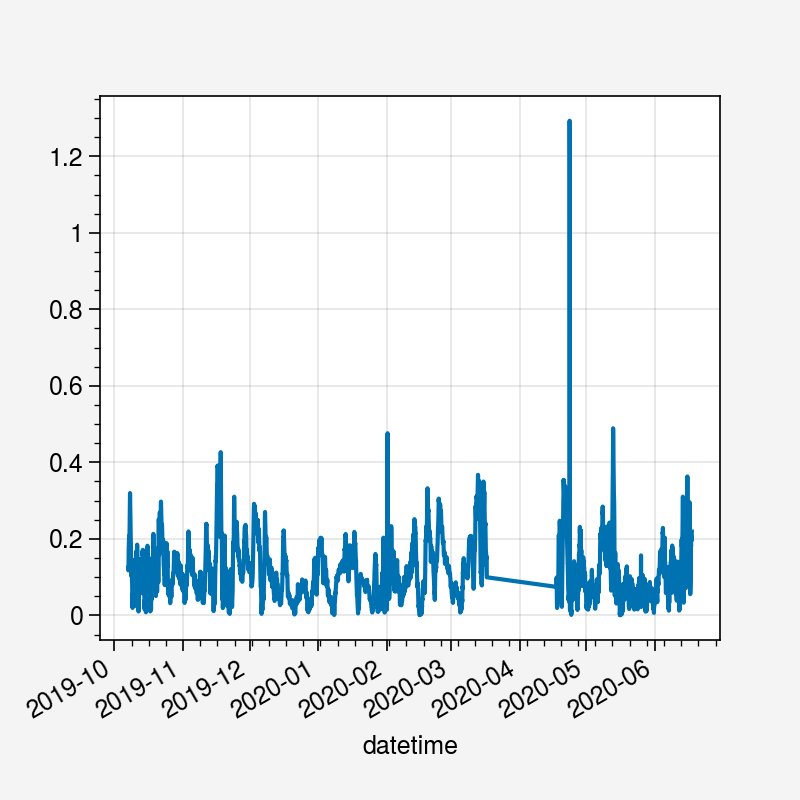

In [85]:
#buoy_df = clean.compute_speed(buoy_df, date_index=True, rotate_uv=False, difference='forward')
#buoy_df.rolling(window='12H', center=False)
#buoy_df.speed.rolling(center=False, window='6H').std().plot()
# for date in buoy_df.index[1:]:


In [4]:
interval_minutes = {}
varying_freq = 0
buoys = []
for buoy in buoy_data:
    date = pd.Series(buoy_data[buoy].index)
    interval_minutes[buoy] = pd.Series(((date - date.shift(1)).dt.total_seconds()/60).values, index=date)
    interval_minutes[buoy] = pd.to_timedelta(interval_minutes[buoy].resample('7D').median(),
                                             unit='min').round('5min').dt.total_seconds()/60
    if np.sum(interval_minutes[buoy] < 120) > 4:
        buoys.append(buoy)
        buoy_data[buoy]['sampling_interval'] = interval_minutes[buoy].reindex_like(buoy_data[buoy], method='ffill')
        if len(np.unique(interval_minutes[buoy].dropna())) > 1:
            varying_freq += 1
varying_freq

55

In [5]:
buoy_data_min30 = {buoy: interp.regrid_buoy_track(buoy_data[buoy], precision='30min') for buoy in buoys}

In [6]:
interval_minutes = {}
varying_freq = 0
for buoy in buoy_data_min30:
    date = pd.Series(buoy_data_min30[buoy].index)
    interval_minutes[buoy] = pd.Series(((date - date.shift(1)).dt.total_seconds()/60).values, index=date)
    interval_minutes[buoy] = pd.to_timedelta(interval_minutes[buoy].resample('7D').median(),
                                             unit='min').round('5min').dt.total_seconds()/60
    if np.sum(interval_minutes[buoy] < 120) > 4:
        buoys.append(buoy)
        buoy_data_min30[buoy]['sampling_interval'] = interval_minutes[buoy].reindex_like(buoy_data_min30[buoy], method='ffill')
        if len(np.unique(interval_minutes[buoy].dropna())) > 1:
            varying_freq += 1
varying_freq

49

In [8]:
for buoy in buoy_data_min30:
    buoy_data_min30[buoy] = clean.calc_speed_for_outlier_check(buoy_data_min30[buoy], date_index=True)

In [ ]:
clean.

'2019P91' has anomalous low speed in december 2019

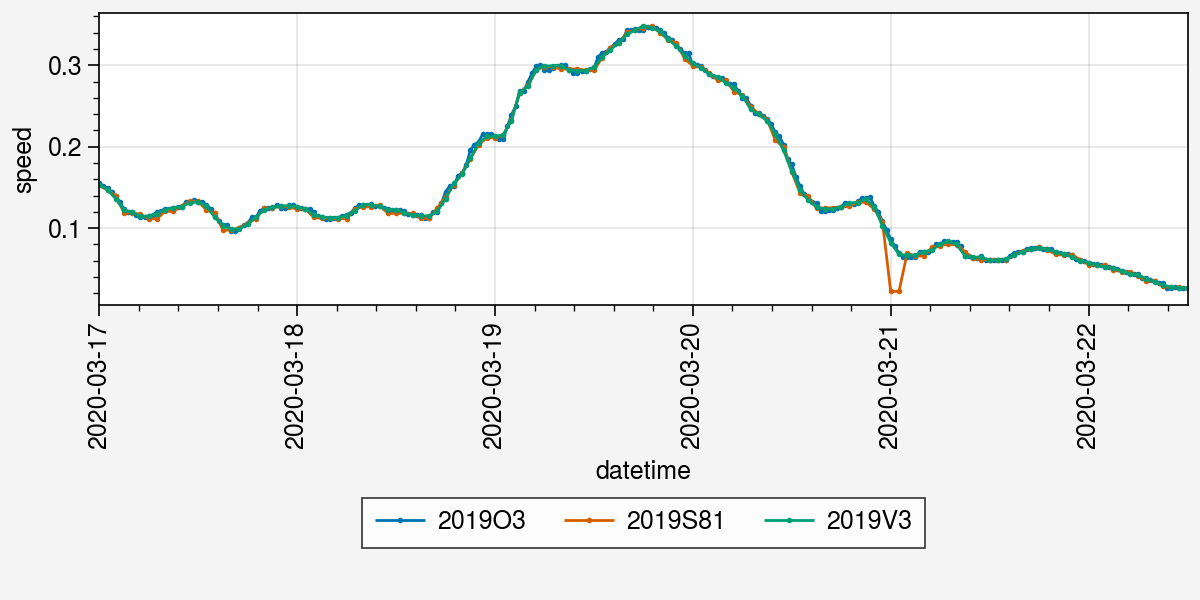

In [10]:
fix, ax = pplt.subplots(width=6, height=3)
#timeslice=slice('2019-12-23 12:00', '2019-12-30 12:00')
#Example ['2019P140', '2019V1']
timeslice=slice('2020-03-17', '2020-03-22 12:00')
for buoy in ['2019O3', '2019S81', '2019V3']: # :#buoys[30:60]:
    
    data = buoy_data_min30[buoy].loc[timeslice]
    if len(data) > 0:
        
        ax.plot(data.speed, lw=1, marker='.', markersize=2, label=buoy)

ax.legend(ncols=5, loc='b')

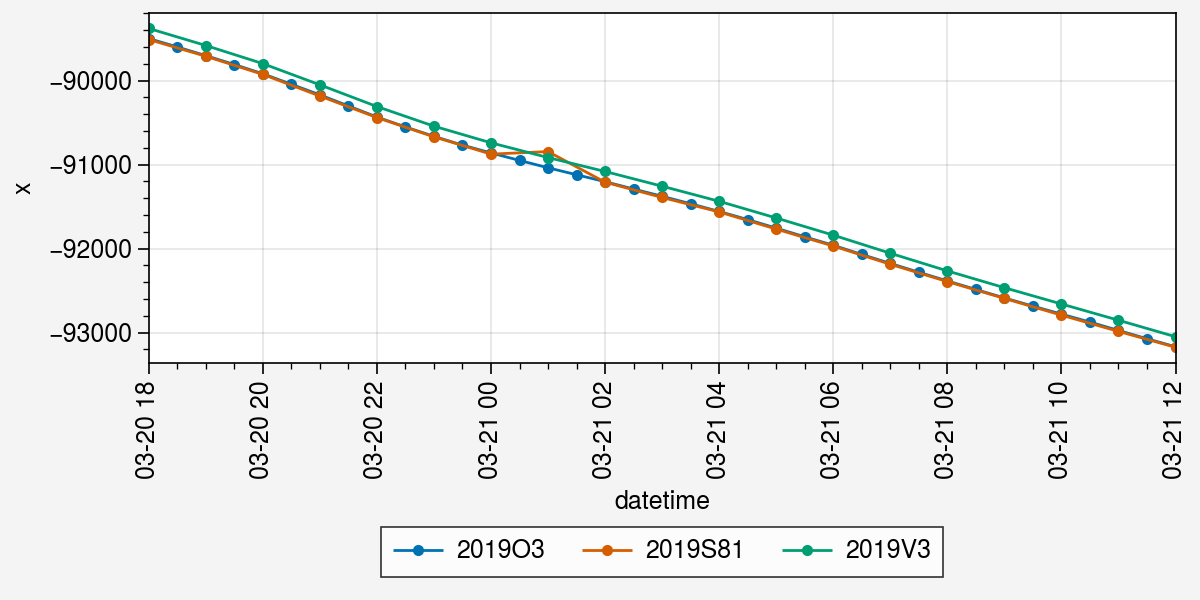

In [14]:
fix, ax = pplt.subplots(width=6, height=3)
#timeslice=slice('2019-12-23 12:00', '2019-12-30 12:00')
#Example ['2019P140', '2019V1']
timeslice=slice('2020-03-20 18:00', '2020-03-21 12:00')
for buoy in ['2019O3', '2019S81', '2019V3']: # :#buoys[30:60]:
    
    data = buoy_data_min30[buoy].loc[timeslice]
    if len(data) > 0:
        ax.plot(data.x, lw=1, marker='.', label=buoy)

ax.legend(ncols=5, loc='b')

In [ ]:
# TBD: re-compute the error_thresholds and determine sensitivity to the fit_margin


In [204]:
clean = reload(clean)
test = clean.identify_outliers(buoy_data_min30['2019R9'], error_thresh=10, fit_margin='6H', detailed_return=True)

The other paper on buoy interpolation found that a lowess approach worked best, and they implemented one that let them simultaneously estimate velocity and position. They found that their method maintained the spectral characteristics of the velocity.

<AxesSubplot:xlabel='datetime'>

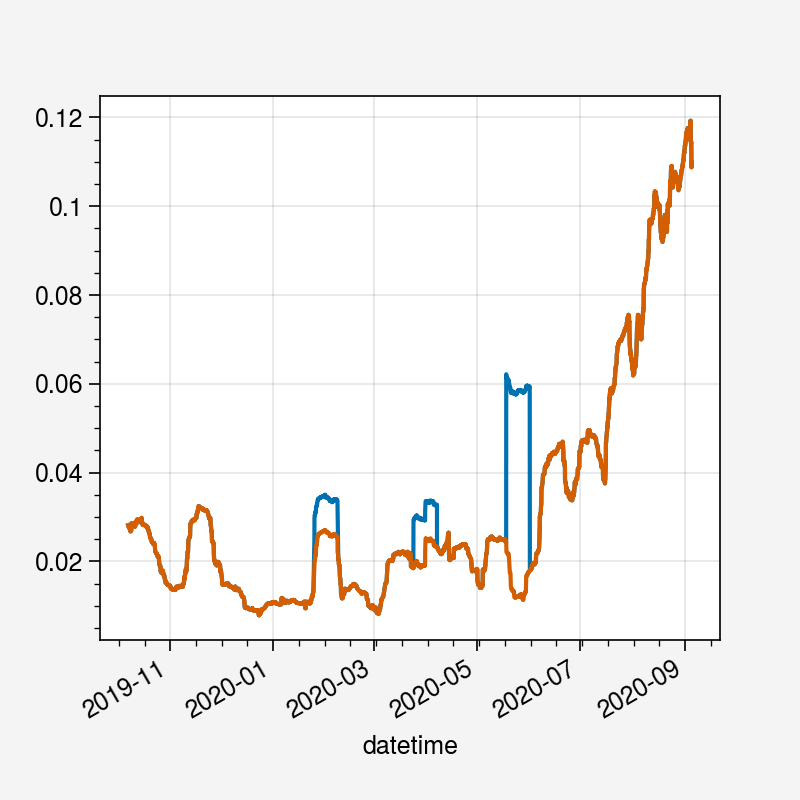

In [262]:
from scipy.stats import linregress
buoy_df = buoy_data_min30['2019P142']
buoy_df['speed_prev'] = buoy_df['speed'].rolling('6H').median()
data = buoy_df.dropna(subset=['speed_prev', 'speed'])
results = linregress(data.speed_prev, data.speed)
#fig, ax = pplt.subplots()
#ax.scatter(buoy_df['speed'], 
f = lambda x: results.slope * x + results.intercept
resid = (data['speed'] - f(data['speed_prev']))
# fig, ax = pplt.subplots()
# ax.scatter(resid, resid.shift(1), s=1) 
prob_outlier = np.abs(resid) > 6*resid.rolling('14D', center=True).std()
resid.rolling('14D', center=True).std().plot()
resid.where(~prob_outlier).rolling('14D', center=True).std().plot()

<AxesSubplot:xlabel='datetime'>

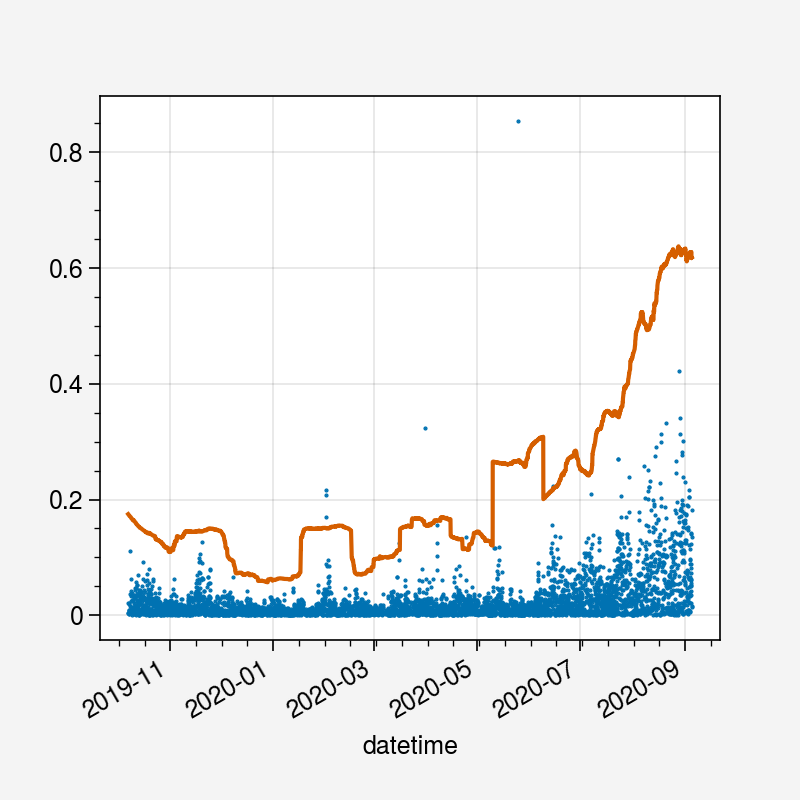

In [256]:
np.abs(data['speed'] - f(data['speed_prev'])).plot(marker='.', markersize=1, lw=0)
(6*resid.rolling('30D', center=True).std()).plot()

In [227]:
# t is the time in seconds
# new weights
from scipy.optimize import curve_fit

I = lambda t: int(np.abs(t) <= 1)
K = lambda t: (70/81)*(1-np.abs(t)**3)**3*I(t)
def f(t, A, B):
    """Linear function where all variables are 2D
    replace with t"""
    return A*t + B

Y = data.loc[:, ['x', 'y']].to_numpy()
t = (data.index.to_series() - data.index[0]).dt.total_seconds()
popt, pcov = curve_fit(f, t, Y, p0)


fig, ax = pplt.subplots()
ax.plot((X-X0)[:,0],
        (X-X0)[:,1],
        marker='.', lw=0)

TypeError: f() takes 3 positional arguments but 5 were given

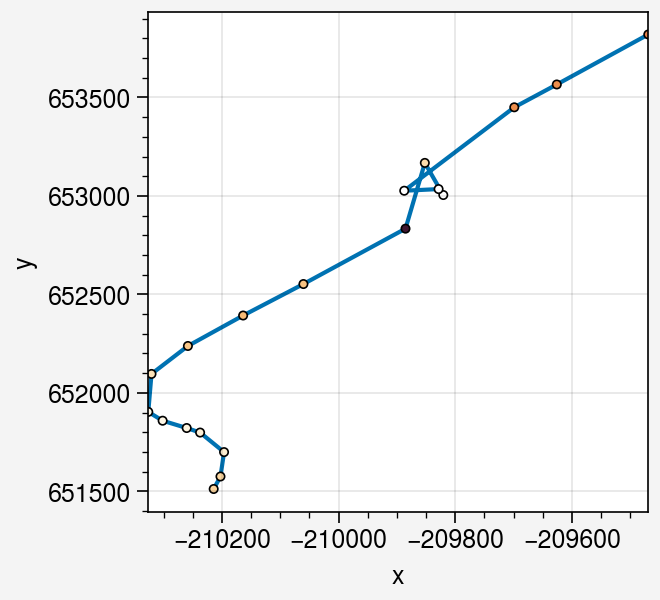

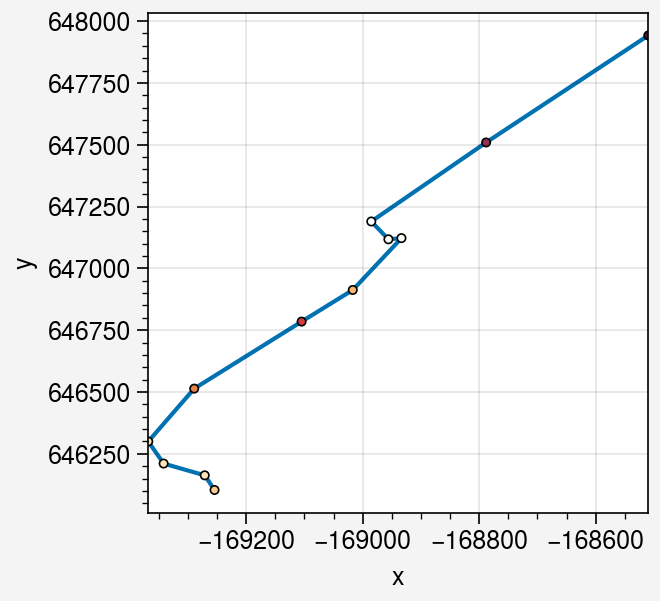

In [123]:
fix, ax = pplt.subplots()
timeslice=slice('2020-04-23 12:00', '2020-04-24 12:00')
data = buoy_data_min30['2019P142']
ax.plot(data.x.loc[timeslice], data.y.loc[timeslice], zorder=0)
ax.scatter(data.x.loc[timeslice], data.y.loc[timeslice],
           c=data.speed.loc[timeslice], marker='.', edgecolor='k', zorder=1)

ax.format(xreverse=False)
fix, ax = pplt.subplots()
timeslice=slice('2020-04-23 12:00', '2020-04-24 12:00')
data = buoy_data_min30['2019P139']
ax.plot(data.x.loc[timeslice], data.y.loc[timeslice], zorder=0)
ax.scatter(data.x.loc[timeslice], data.y.loc[timeslice],
           c=data.speed.loc[timeslice], marker='.', edgecolor='k', zorder=1)

ax.format(xreverse=False)

<a list of 1 Line2D objects>

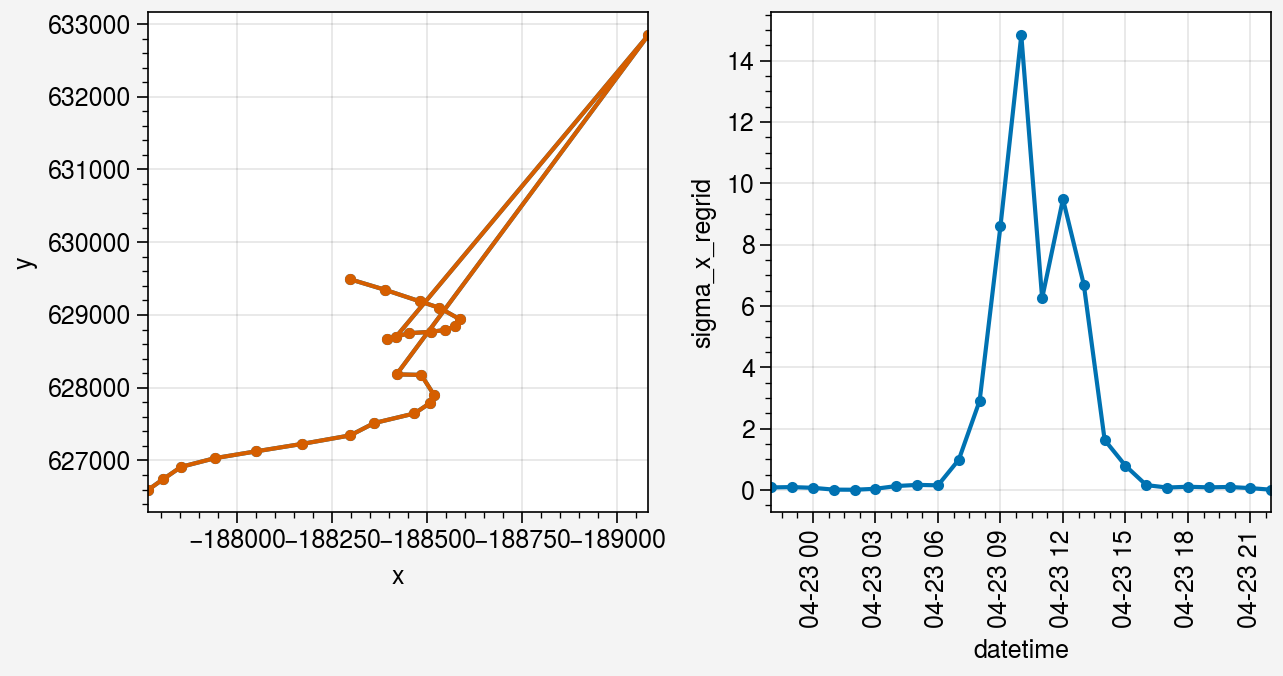

In [69]:
date = '2020-04-23 10:00:00'
date= pd.to_datetime(date)
fig, ax = pplt.subplots(ncols=2, share=False)
margin = pd.to_timedelta('12H')
ax[0].plot(buoy_df.loc[slice(date-margin, date+margin), 'x'],
       buoy_df.loc[slice(date-margin, date+margin), 'y'], marker='.')
ax[0].plot(buoy_df.loc[slice(date-margin, date+margin), 'x'],
       buoy_df.loc[slice(date-margin, date+margin), 'y'], marker='.')


ax[1].plot(buoy_df.loc[slice(date-margin, date+margin), 'sigma_x_regrid'],
      marker='.')

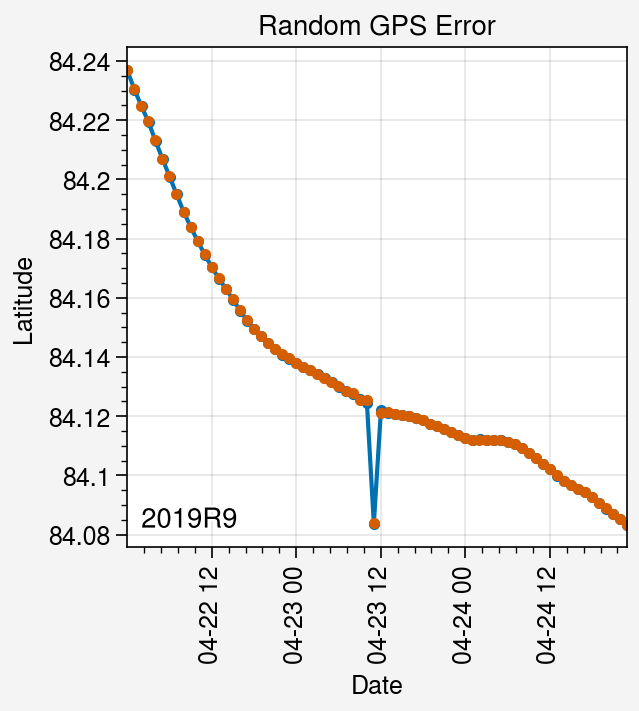

In [87]:
fig, ax = pplt.subplots()
buoy_df = buoy_data['2019R9']
timeslice = slice('2020-04-22', '2020-04-24')
ax.plot(buoy_df.loc[timeslice, 'latitude'], marker='.')
ax.plot(buoy_df_regridded['2019R9'].loc[timeslice, 'latitude'], marker='.', lw=0)


ax.format(xlabel='Date', ylabel='Latitude', title='Random GPS Error', lltitle='2019R9')



In [43]:
for buoy in buoy_df_regridded:
    print(buoy, buoy_df_regridded[buoy]['sigma_x_regrid'].max())

2019R9 19.508607863636175
2019P142 0.6243712320036371
2019T66 2.553258238685121
2020P164 0.18289781981914194
2019R8 12.642960875131273
2020P170 0.07947039225685479
2019P203 12.470156543312376
2019P91 9.050627712134172
2020P176 0.06382572214992456
2019P151 6.224467177828826
2020P171 36.601917544924646
ASFS50UCB4 35.10043623834341
2020P162 0.3687295486681057
2020P233 1.1847311142480292
2019O4 49.636071271734316
2020S97 0.823903395542718
2019T67 0.04278359173312418
2019P143 0.04743329034713158
2019S87 2.1480932495073093
2020P163 0.11564581828348307
2020P178 0.4090820886362921
2020P174 0.07447600065644126
2020R10 3.153728848286569
2019S94 3.213243993189316
2019O2 3.7201367749189895
2020P230 0.297590008953716
2020P236 0.34537308082528323
2019O3 77.33547488501884
2019P138 5.02877777666728
2019P126 2.968019988383623e-10
2020P220 8.794440133815526
2020O10 55.25112775766737
2019P187 2.039858396601099
2019P140 0.004587137594396444
2019P199 9.012895339794097
2019P146 0.04463398907072402
2019O6 34

In [24]:
# for buoy in buoys:
#     if min(interval_minutes[buoy]) < 30:
#         print(buoy, np.unique(interval_minutes[buoy].loc[interval_minutes[buoy] < 120]))

In [426]:
for buoy in buoys:
    if buoy_data[buoy]['sigma_x_regrid'].max() > 10:
        print(buoy,  np.round(buoy_data[buoy]['sigma_x_regrid'].max()),
             np.round(buoy_data[buoy]['sigma_x_regrid'].quantile(0.99), 3))

2019R9 15.0 0.298
2019P91 12.0 0.105
2020P220 17.0 0.118
2019P105 23.0 0.068
2020M23 31.0 0.43
2019P206 40.0 0.026
2020P219 17.0 0.077


In [493]:
# 5 point median filter
buoy = '2020P164'
buoy = '2019P103' # Good for examples, pretty clear shift
buoy = '2020P181' # Similar to P164
buoy = '2020P219'

buoy_data[buoy]['x_filtered'] = buoy_data[buoy]['x'].rolling(5, center=True).median()
buoy_data[buoy]['y_filtered'] = buoy_data[buoy]['y'].rolling(5, center=True).median()
buoy_data[buoy]['xy_dist'] = np.sqrt((buoy_data[buoy]['x'] - buoy_data[buoy]['x_filtered'])**2 + \
                                    (buoy_data[buoy]['x'] - buoy_data[buoy]['x_filtered'])**2)

In [494]:
buoy_data[buoy]['median_delta_t'] = interval_minutes[buoy].reindex_like(buoy_data[buoy], method='ffill')

In [495]:
threshold = buoy_data[buoy].groupby('median_delta_t')['xy_dist'].std()
# Next step: adjust the threshold based on the velocity variability? 

In [496]:
stdev = buoy_data[buoy]['median_delta_t'].map({x: threshold[x] for x in threshold.index})

2020P219


<a list of 1 Line2D objects>

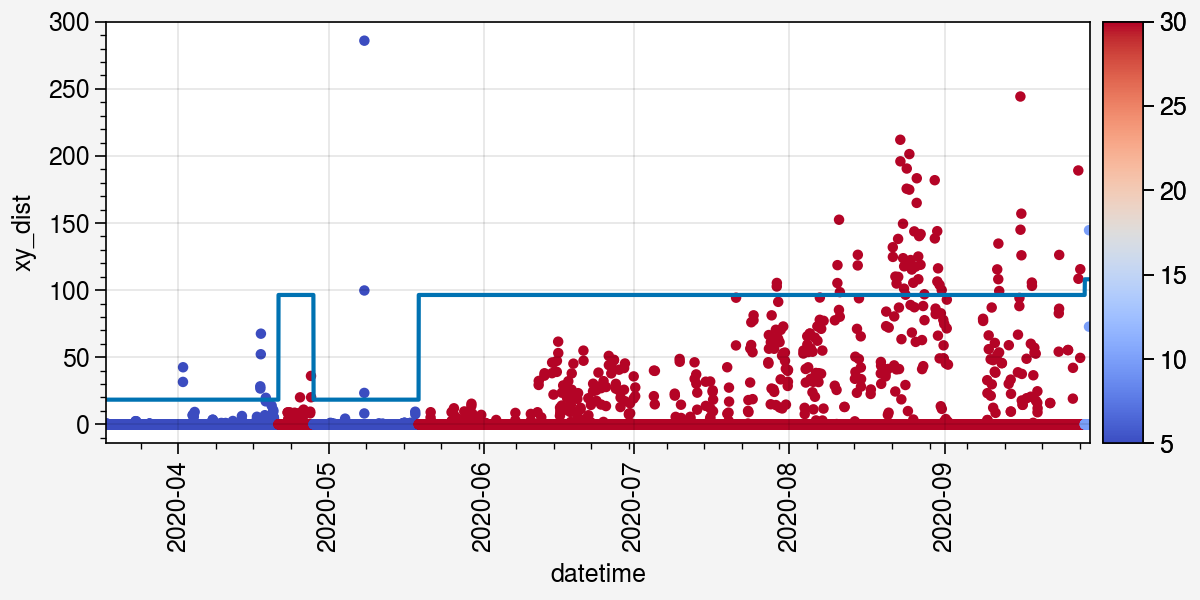

In [497]:
print(buoy)
fig, ax = pplt.subplots(width=6, height=3)
ax.scatter(buoy_data[buoy]['xy_dist'], s=10, c=buoy_data[buoy]['median_delta_t'], colorbar='r', cmap='coolwarm')
ax.plot(stdev * 6)

In [410]:
#interval_minutes['2020T60'].reindex_like(buoy_data['2020T60'], method='ffill')
buoy_data['2019P206'].loc[buoy_data['2019P206']['sigma_x_regrid'] > 10].index

DatetimeIndex(['2019-10-26 10:30:00'], dtype='datetime64[ns]', name='datetime', freq=None)

<a list of 1 Line2D objects>

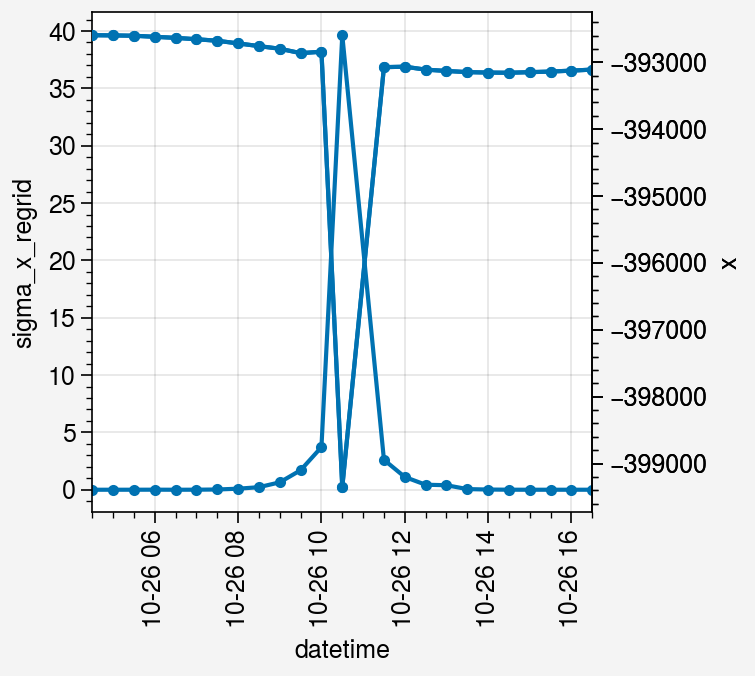

In [412]:
margin = pd.to_timedelta('6H')
fig, ax = pplt.subplots()
#idx = buoy_data['2020T60'].loc[buoy_data['2020T60']['sigma_x_regrid'] > 10].index
date = pd.to_datetime('2019-10-26 10:30:00')
ax.plot(buoy_data['2019P206'].loc[slice(date-margin, date+margin), 'sigma_x_regrid'], marker='.')
ax2 = ax.twinx()
ax2.plot(buoy_data['2019P206'].loc[slice(date-margin, date+margin), 'x'], marker='.',
        shadedata=buoy_data['2019P206'].loc[slice(date-margin, date+margin), 'sigma_x_regrid'])

In [384]:
interval_minutes = {}
for buoy in buoy_data:
    date = pd.Series(buoy_data[buoy].index)
    interval_minutes[buoy] = pd.Series(((date - date.shift(1)).dt.total_seconds()/60).values, index=date)
    interval_minutes[buoy] = pd.to_timedelta(interval_minutes[buoy].resample('7D').median(), unit='min').round('5min').dt.total_seconds()/60

In [385]:
n_changed = 0
n_the_same = 0
for buoy in buoy_data:
    freqs = np.unique(interval_minutes[buoy].dropna().astype(int))
    freqs = [f for f in freqs if f < 720]
    print(buoy, freqs)
    if len(freqs) > 1:
        n_changed += 1
    else:
        n_the_same += 1

2019R9 [60]
2019P142 [60, 90, 120]
2019T66 [30]
2020P164 [30, 60]
2019R8 [60]
2020P170 [30, 60]
2019P203 [30]
2019P91 [10]
2020P176 [30, 60]
2019P151 [60, 115, 120, 180]
2020P171 [30, 60]
ASFS50UCB4 [10]
2020P162 [30, 60]
2020P233 [60]
2019O4 [10, 20]
2020S97 [60]
2019T67 [30]
2019P143 [60, 120]
2019S87 [60]
2019P137 [60, 120, 180, 300]
ASFS30UCB5 [10]
2020P163 [30, 60]
2019O7 [10]
2020T84 [120]
2020P178 [30, 60]
ASFS30UCB4 [10]
2020P174 [30, 60]
2020T81 [120]
2020P215 [180, 360, 465, 630]
2019S95 [60]
2020R10 [60]
2019S94 [60]
2019O2 [10]
2019T70 [120]
2019P153 [60]
2020P230 [60]
2020P236 [60]
2019O3 [10]
2019P138 [60, 120]
2019P126 [60]
2019P161 [60]
2020P220 [5, 30, 60]
2020O10 [5, 10]
2019I2 [240]
2020P214 [180]
2019P187 [30]
2019P140 [60, 120]
2019P199 [30]
2019P146 [60, 105, 120]
2019O6 [10]
2020T74 [30]
2019P125 [60]
2019T56 [120]
2020P177 [30, 60]
2020R21 [60]
2019T68 [120]
2019P152 [60, 110, 120]
ASFS50UCB3 [10]
2020P223 [180]
2019P92 [10, 30]
2020T85 [30, 120]
2019V4 [60]
202

In [255]:
print(n_changed, n_the_same, n_changed + n_the_same)

55 139 194


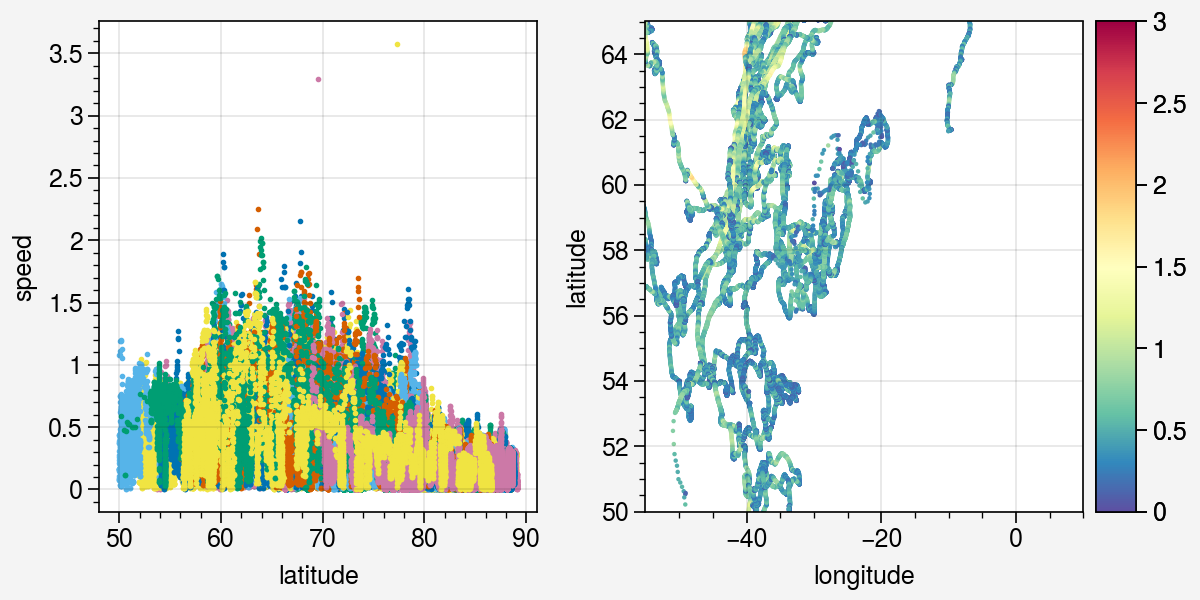

In [273]:
fig, ax = pplt.subplots(width=6, height=3, ncols=2, share=False)
for buoy in buoy_data:
    if buoy_data[buoy].latitude.min() < 70:
        ax[0].scatter(buoy_data[buoy].latitude, buoy_data[buoy].speed, s=2)
        m=ax[1].scatter(buoy_data[buoy].longitude,
                      buoy_data[buoy].latitude,
                      c=buoy_data[buoy].speed, s=1, cmap='spectral_r',
                     vmin=0, vmax=3)
ax[1].colorbar(m)
ax[1].format(ylim=(50, 65), xlim=(-55, 10))

In [373]:
# Aligning to a 5-minute grid and adding column pos_err_tgrid
from scipy.interpolate import interp1d
import pyproj

buoy_data_gridded = {}
for buoy in buoy_data:
    buoy_df = buoy_data[buoy]
    precision='5min'
    xvar = 'x'
    yvar = 'y'
    

2019R9 14.825446738330221
2019P142 7.226288724952325
2019R8 1.045452807343676
2019P203 3.1496113592707338
2019P91 11.926839187793506
2020P171 3.455552442638472
2019O4 4.354017194689569
2020S97 1.0215722418194184
2019P137 49.28590432871991
2019O3 2.883322737696478
2019P138 179.75838259490828
2020P220 17.414763977214786
2020O10 8.383011146134255
2019P146 8.022331037167831
2019O6 1.846870470156137
2019P92 5.731565332123664
2019V4 7.158638143488885
2019P90 6.535941753087944
2019P102 7.936874741576246
2019P139 1.3469559304112315
2019P88 6.369051571583068
2019P105 23.11860834781626
2020E1 3.0922709533659813
2020S108 1.1289600293689772
2020M23 31.24227923098786
2019V2 4.828056043346373
2019S96 1.528638161858992
2020P180 1.4135726990575763
2019P183 1.3492482095857707
2019P206 39.63546564995467
2019P196 1.111106898570532
2019S84 2.543705342050496
2020M27 4.073848123348015
2020P218 4.658344696602225
2019P127 14.82169997927189
2019P197 3.4850204318784903
2019P136 11.782829768451984
2019P135 34.31

<AxesSubplot:xlabel='datetime'>

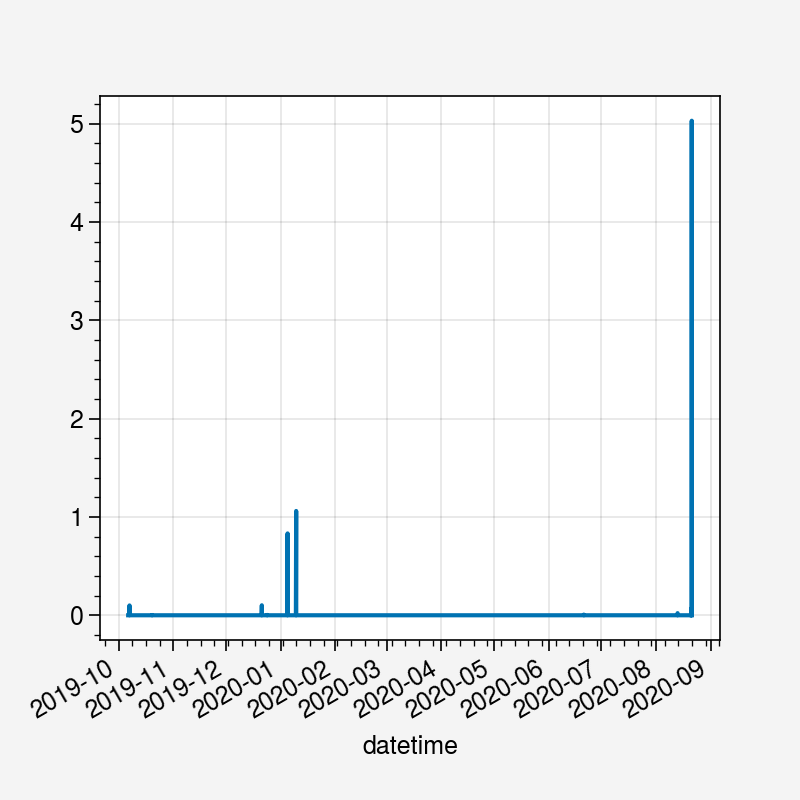

In [375]:
buoy_data_gridded['2019P138'].sigma_x_regrid.plot()

In [356]:
X_err.idxmax()

Timestamp('2020-05-10 09:29:00')

In [343]:
interp1d(t_seconds, X_err, bounds_error=False, kind='nearest')(tnew_seconds)

array([0.00000000e+00, 0.00000000e+00, 5.82076609e-11, ...,
       0.00000000e+00, 2.30068456e-06,            nan])

<a list of 1 Line2D objects>

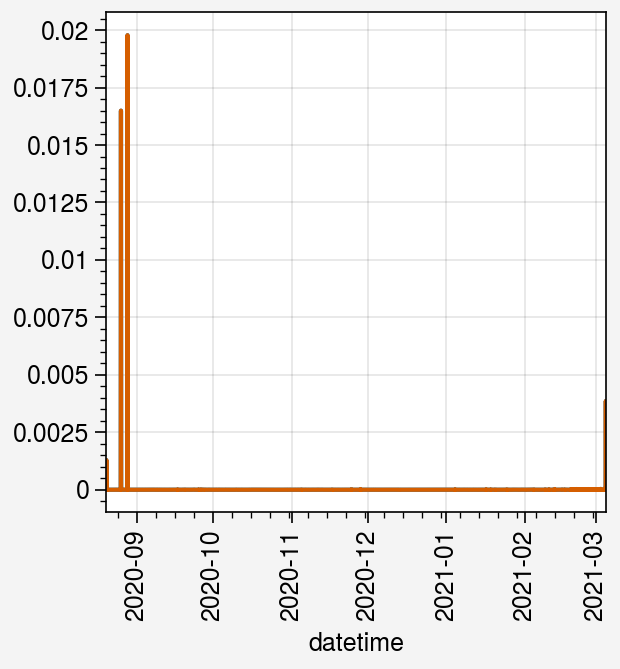

In [368]:
fig, ax = pplt.subplots()
ax.plot(X_err)
ax.plot(tnew, interp1d(t_seconds, X_err, bounds_error=False, kind='nearest')(tnew_seconds))

In [151]:
metadata = metadata.loc[[b for b in metadata.index if b in buoy_data]]
metadata['median_frequency'] = np.nan
for buoy in buoy_freq.index:
    metadata.loc[buoy, 'median_frequency'] = (buoy_freq[buoy]*60).astype(int)
metadata.groupby('median_frequency').count().median(axis=1)

median_frequency
4.0       2.0
10.0     29.0
29.0      1.0
30.0     44.0
59.0      5.0
60.0     88.0
61.0      1.0
119.0     1.0
120.0    23.0
dtype: float64

In [5]:
# Find typical uncertainties from interpolation with 12H fitting window
if recompute_thresh:
    data_thresh = pd.DataFrame({'freq': buoy_freq, 'error_thresh': np.nan})
    def est_middle(date, data, xvar, yvar):
        from scipy.interpolate import interp1d
        """Similar to the savgol filter, estimate the value at date with a polynomial fit.
        """
        t0 = (data.drop(date).index - data.index[0]).total_seconds()
        t1 = (date - data.index[0]).total_seconds()

        X = data.drop(date).loc[:,[xvar, yvar]].T
        return interp1d(t0, X.values, bounds_error=False, kind='cubic')(t1).T


    for buoy in buoy_data:
        buoy_df = buoy_data[buoy].copy()
        n = np.min([int(len(buoy_df)/2), 1000])
        date_sample = np.random.choice(buoy_df.index, replace=False, size=n)
        error = []
        for date in date_sample:
            x0 = buoy_df.loc[date, 'x']
            y0 = buoy_df.loc[date, 'y']
            try:
                x1, y1 = est_middle(date, buoy_df.loc[slice(date-margin, date+margin)], 'x', 'y')        
                error.append(np.sqrt((x0-x1)**2 + (y0-y1)**2))
            except:
                error.append(np.nan)
        sample = pd.Series(error, index=date_sample).sort_index()
        data_thresh.loc[buoy, 'error_thresh'] = sample.quantile(0.99)
        print(buoy, sample.quantile(0.99))
else: 
    data_thresh = pd.read_csv('../data/error_estimate_cubic_splines.csv', index_col=0)

In [115]:
metadata.columns

Index(['Deployment Leg', 'DN Station ID', 'IMEI', 'Deployment Date',
       'Deployment Datetime', 'First Data Datetime', 'Last Data Datetime',
       'Active', 'Sampling Frequency (hh:mm)', 'Re-deployed As',
       'Formerly Deployed As', 'Buoy Type', 'Manufacturer', 'Model', 'PI',
       'Data Authors', 'filename'],
      dtype='object')

In [113]:
p_sites = [x for x in metadata.index if metadata.loc[x, 'DN Station ID'][0] == 'P']
for name, group in metadata.loc[p_sites].groupby('Deployment Leg'):
    print(name)
    print(group.groupby('Model')['Buoy Type'].count())



1
Model
Ice Tracker          20
SIMBA V7              2
SVP-B                 9
SVP-I-BXGS-AP         7
SVP-I-XXGS-LP         8
Universal Tracker     5
iSVP                 12
iceST/30              4
Name: Buoy Type, dtype: int64
3
Model
SIMBA V7             4
SVP-B                1
SVP-I-BXGS-P         5
SVP-I-XXGS-LP        1
Universal Tracker    7
Name: Buoy Type, dtype: int64
5
Model
ICEB-I-TBAS-SH-A     2
Ice Tracker         20
SVP-I-BXGS-P         8
Name: Buoy Type, dtype: int64


In [114]:
for name, group in metadata.loc[p_sites].groupby('Deployment Leg'):
    print(name)
    print(group.groupby('')['Buoy Type'].count())




1
Manufacturer
MarlinYUG               4
MetOcean Telematics    16
PacificGyre IT         33
SAMS Enterprise Ltd     2
TUT                    12
Name: Buoy Type, dtype: int64
3
Manufacturer
MetOcean Telematics    7
PacificGyre IT         7
SAMS Enterprise Ltd    4
Name: Buoy Type, dtype: int64
5
Manufacturer
MetOcean Telematics    10
PacificGyre IT         20
Name: Buoy Type, dtype: int64


In [88]:
buoy_df_regridded[buoy]

x             y  sigma_x_regrid   longitude  \
datetime                                                                      
2020-08-19 20:00:00           NaN           NaN             NaN         NaN   
2020-08-19 21:00:00    -402.57580    -721.86811    5.684342e-14  150.852200   
2020-08-19 22:00:00    -349.29962    -810.31922    1.290961e-03  156.680855   
2020-08-19 23:00:00    -302.52084    -888.10247    3.464361e-04  161.189242   
2020-08-20 00:00:00    -278.64761    -954.22400    1.136868e-13  163.721410   
...                           ...           ...             ...         ...   
2021-03-04 22:00:00  268581.34490  711718.06156    1.033169e-03  -20.675023   
2021-03-04 23:00:00  268316.88887  712807.64438    3.862326e-03  -20.627470   
2021-03-05 00:00:00  268005.90572  714043.43911    0.000000e+00  -20.572900   
2021-03-05 01:00:00  267825.26351  715336.74005    0.000000e+00  -20.526124   
2021-03-05 02:00:00           NaN           NaN             NaN         NaN   

                      latitude  
datetime                        
2020-08-19 20:00:00        NaN  
2020-08-19 21:00:00  89.992600  
2020-08-19 22:00:00  89.992100  
2020-08-19 23:00:00  89.991600  
2020-08-20 00:00:00  89.991100  
...                        ...  
2021-03-04 22:00:00  83.185004  
2021-03-04 23:00:00  83.176695  
2021-03-05 00:00:00  83.167300  
2021-03-05 01:00:00  83.157006  
2021-03-05 02:00:00        NaN  

[4624 rows x 5 columns]

In [166]:
%%time
idx = 0
for buoy in buoy_data:
    if idx % 10 == 0:
        print(idx, buoy)
    idx += 1
    # Check for duplicate dates and isolated data.
    buoy_data[buoy]['flag_date'] = clean.check_dates(buoy_data[buoy], date_index=True) # Initial pass just looks for negative time steps

    buoy_data[buoy]['flag_gaps'] = clean.check_dates(buoy_data[buoy].where(
                                                buoy_data[buoy]['flag_date']==0),
                                          date_index=True, check_gaps=True,
                                          gap_threshold=np.min([6, 6/buoy_freq[buoy]]), gap_window='12H')
    
    # loop throough flagging gaps until no more are found
    num_flagged = sum((buoy_data[buoy]['flag_gaps']==1) & (buoy_data[buoy]['flag_date']==0))
    num_flagged_update = 0
    while num_flagged != num_flagged_update:
        num_flagged = sum((buoy_data[buoy]['flag_gaps']==1) & (buoy_data[buoy]['flag_date']==0))
        buoy_data[buoy]['flag_gaps'] = clean.check_dates(buoy_data[buoy].where(
                                                (buoy_data[buoy]['flag_date']==0) & (buoy_data[buoy]['flag_gaps']==0)),
                                          date_index=True, check_gaps=True,
                                          gap_threshold=np.min([4.1, 6/buoy_freq[buoy]]), gap_window='12H')    
        num_flagged_update = sum((buoy_data[buoy]['flag_gaps']==1) & (buoy_data[buoy]['flag_date']==0))

    buoy_data[buoy]['flag_position'] = clean.check_duplicate_positions(buoy_data[buoy], pairs_only=True)
    
    buoy_data[buoy] = clean.calc_speed_for_outlier_check(buoy_data[buoy], date_index=True)
    error_thresh = data_thresh.groupby('freq').quantile(0.9).loc[data_thresh.loc[buoy, 'freq']].values[0]
    
    flagged_already = buoy_data[buoy].flag_gaps | buoy_data[buoy].flag_position | buoy_data[buoy].flag_date
    
    x = buoy_data[buoy].where(~flagged_already)['x']
    buoy_data[buoy]['x_anom'] = x - x.rolling(3, center=True, min_periods=3).median()
    y = buoy_data[buoy].where(~flagged_already)['y']
    buoy_data[buoy]['y_anom'] = y - y.rolling(3, center=True, min_periods=3).median()
    
    buoy_data[buoy]['anom_dist'] = np.sqrt(buoy_data[buoy]['x_anom']**2 + buoy_data[buoy]['y_anom']**2)
    buoy_data[buoy]['flag_outlier'] = clean.identify_outliers(buoy_data[buoy].where(~flagged_already),
                                                        error_thresh, fit_margin='12H', sigma=6,
                                                        detailed_return=False)

# save qc'd data
for buoy in buoy_data:
    buoy_data[buoy].to_csv('../data/mosaic_qc/' + metadata.loc[buoy, 'filename'] + '.csv')                            

0 2019R9
10 2020P171
20 ASFS30UCB5
30 2019S94
40 2020P220
50 2020P177
60 2020P172
70 2020E1
80 2020S109
90 2020P160
100 ASFSTUCB3
110 2019T71
120 2019T59
130 2019P136
140 2020P232
150 ASFSTUCB1
160 2020P166
170 2019P144
180 2020R12
190 2019T64
CPU times: user 33.8 s, sys: 641 ms, total: 34.4 s
Wall time: 34.4 s


In [167]:
saveloc = '../data/mosaic_interpolated/'
buoy_data_interp = {}
for buoy in buoy_data:
    flagged = buoy_data[buoy][['flag_date', 'flag_gaps', 'flag_position', 'flag_outlier']].sum(axis=1) > 0 
    data = buoy_data[buoy].where(~flagged).dropna()
    
    data_interp = interp.interpolate_buoy_track(
        data.loc[slice(pd.to_datetime(begin)-margin,
                       pd.to_datetime(end)+margin)],
        xvar='longitude', yvar='latitude', freq='1H',
        maxgap_minutes=240)
    
    # What's the point of this step?
    data_interp['day_count'] = data_interp.rolling(window='1D', center=True).count()['longitude']
    data_interp = data_interp.where(data_interp.day_count >= 12).dropna()

    # Compute speed with interpolated data
    data_interp = clean.compute_speed(
        data_interp, date_index=True,
        rotate_uv=True, difference='centered')

    # Write to file
    data_interp.to_csv(saveloc + metadata.loc[buoy, 'filename'] + '.csv')


    buoy_data_interp[buoy] = data_interp

In [69]:
results = {}
for buoy in buoy_data:
    results[buoy] = buoy_data[buoy][['flag_date', 'flag_gaps', 'flag_position', 'flag_outlier']].sum()
results = pd.concat(results, axis=1).T

In [189]:
results.flag_outlier.sort_values()[::-1][0:10]

2020O10     94
2020P171     7
2019P137     6
2019O5       5
2019P139     5
2019P102     5
2019P91      5
2019O4       4
2019P105     4
2019P88      4
Name: flag_outlier, dtype: int64

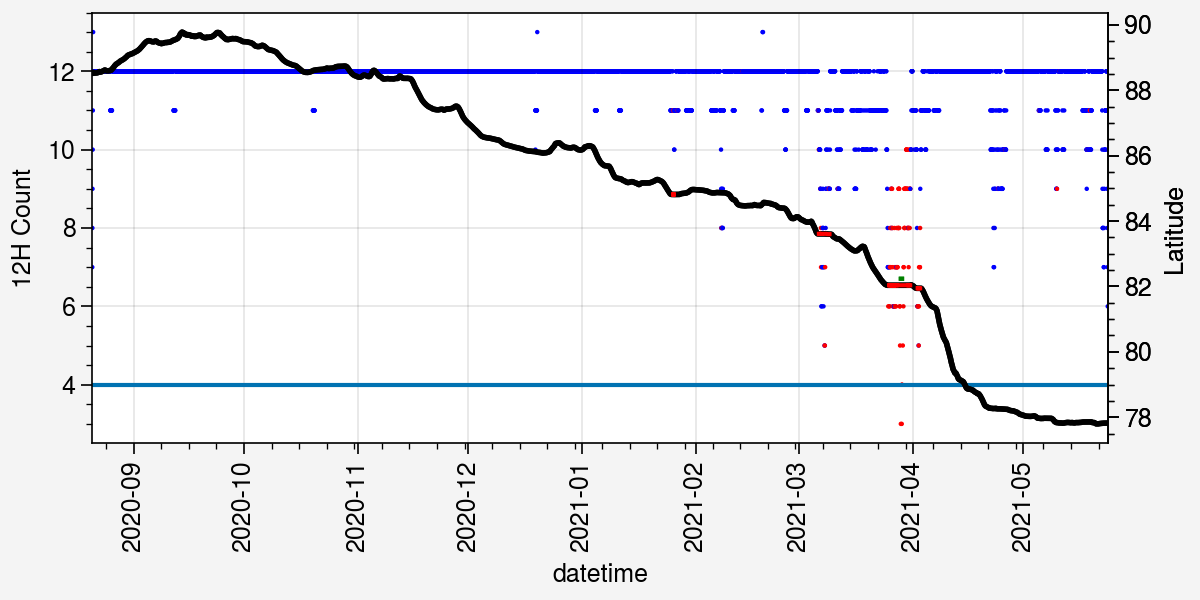

In [187]:
# Example flag positions
buoy = '2020P234'
fig, ax = pplt.subplots(ncols=1, share=False, width=6, height=3)
ax2=ax.twinx()
ax.scatter(buoy_data[buoy].latitude.rolling('12H', center=True).count(),
              c=buoy_data[buoy].flag_position.astype(int), cmap='bwr', markersize=1)
ax2.plot(buoy_data[buoy].latitude, color='k', lw=2)
ax2.plot(buoy_data[buoy].where(buoy_data[buoy].flag_position==1).latitude, color='r')
ax2.plot(buoy_data[buoy].where(clean.check_dates(buoy_data[buoy].where(buoy_data[buoy]['flag_date']==0),
                  date_index=True, check_gaps=True,
                  gap_threshold=np.min([4.1, 6/buoy_freq[buoy]]), gap_window='12H')).latitude + 0.2, color='g')


ax.format(ylabel='12H Count')#, ylim=(0, 48))
ax2.format(ylabel='Latitude')
ax.axhline(4)

In [25]:
# Visualize flagged data
fix_buoys = ['2019P101', '2019P137', '2019P138', '2019P139',
'2019P146', '2019P143', '2019P142', '2019P136',
'2019T63', '2019S84', '2019T72', '2020E1', 'ASFSTUCB1',
'2019P187', '2019S81']
for buoy in fix_buoys:
    margin = pd.to_timedelta('12H')
    flagged = buoy_data[buoy].loc[buoy_data[buoy]['flag_outlier']==1].index
    n = len(flagged)
    print(buoy, n)

2019P101 1
2019P137 6
2019P138 0
2019P139 2
2019P146 2
2019P143 1
2019P142 3
2019P136 1
2019T63 0
2019S84 1
2019T72 0
2020E1 1
ASFSTUCB1 0
2019P187 0
2019S81 0


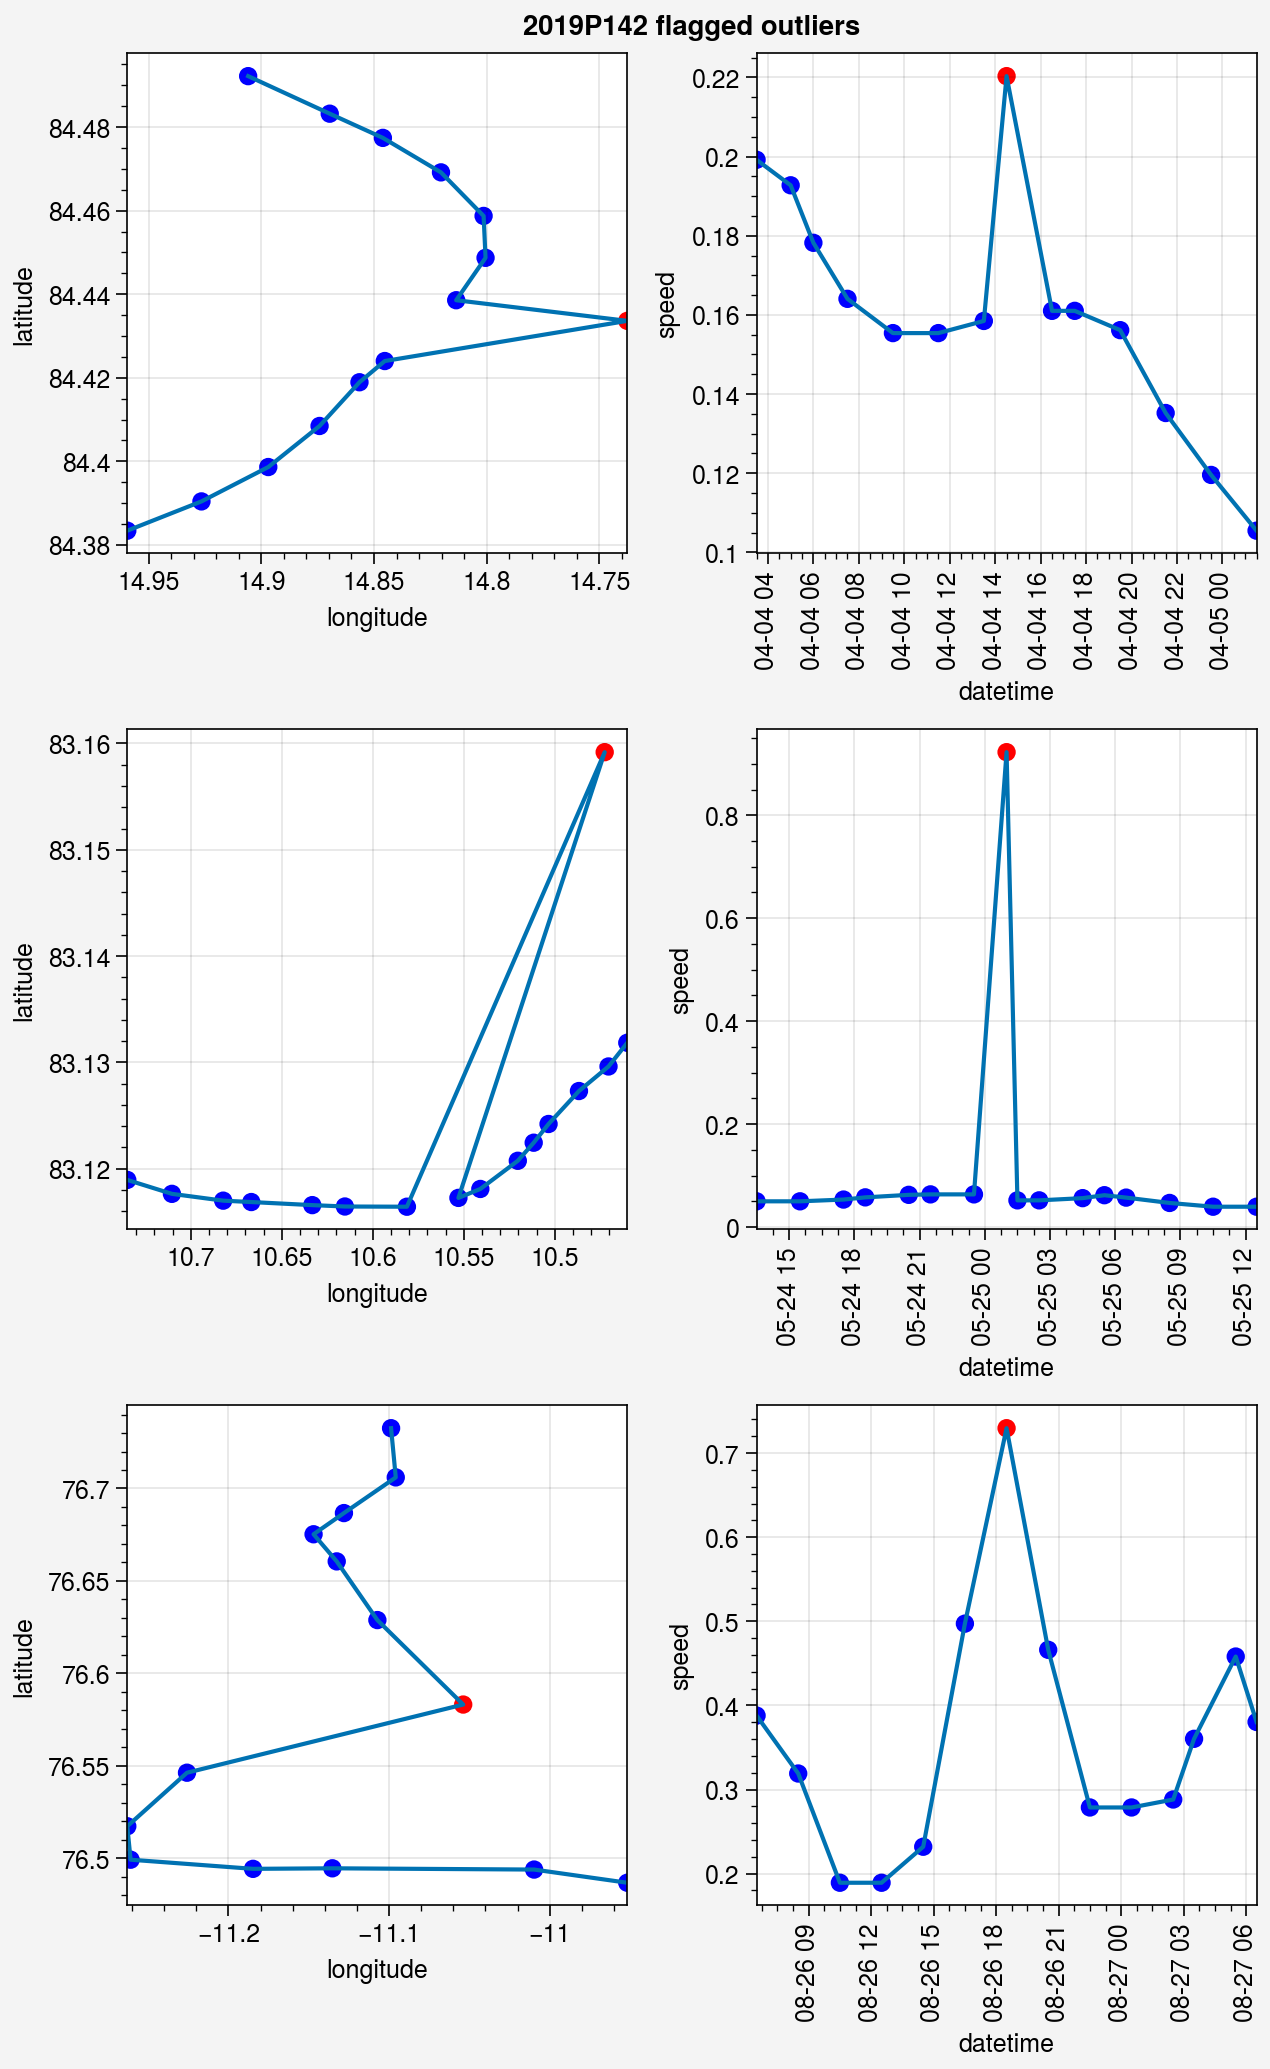

In [103]:
buoy = '2019P142'
margin = pd.to_timedelta('12H')
flagged = buoy_data[buoy].loc[buoy_data[buoy]['flag_outlier']==1].index
n = len(flagged)

fig, axs = pplt.subplots(ncols=2, nrows=n, share=False)

for row, date in enumerate(flagged):
    axs[row,0].plot(buoy_data[buoy].loc[slice(date-margin, date+margin), 'longitude'],
                   buoy_data[buoy].loc[slice(date-margin, date+margin), 'latitude'])

    
    axs[row,0].scatter(buoy_data[buoy].loc[slice(date-margin, date+margin), 'longitude'],
                   buoy_data[buoy].loc[slice(date-margin, date+margin), 'latitude'],
                      c=buoy_data[buoy].loc[slice(date-margin, date+margin), 'flag_outlier'].astype(int),
                      cmap='bwr')
    axs[row, 1].plot(buoy_data[buoy].loc[slice(date-margin, date+margin), 'speed'])
    axs[row, 1].scatter(buoy_data[buoy].loc[slice(date-margin, date+margin), 'speed'],
                       c=buoy_data[buoy].loc[slice(date-margin, date+margin), 'flag_outlier'].astype(int),
                      cmap='bwr')
axs.format(suptitle=buoy + ' flagged outliers')
fig.save('../sample/examples/' + buoy + '.jpg', dpi=150)

In [33]:
results.flag_gaps[fix_buoys]

2019P101       70
2019P137       11
2019P138        7
2019P139     3500
2019P146        5
2019P143        7
2019P142        4
2019P136      440
2019T63         0
2019S84         4
2019T72         0
2020E1          0
ASFSTUCB1       0
2019P187        0
2019S81         0
Name: flag_gaps, dtype: int64

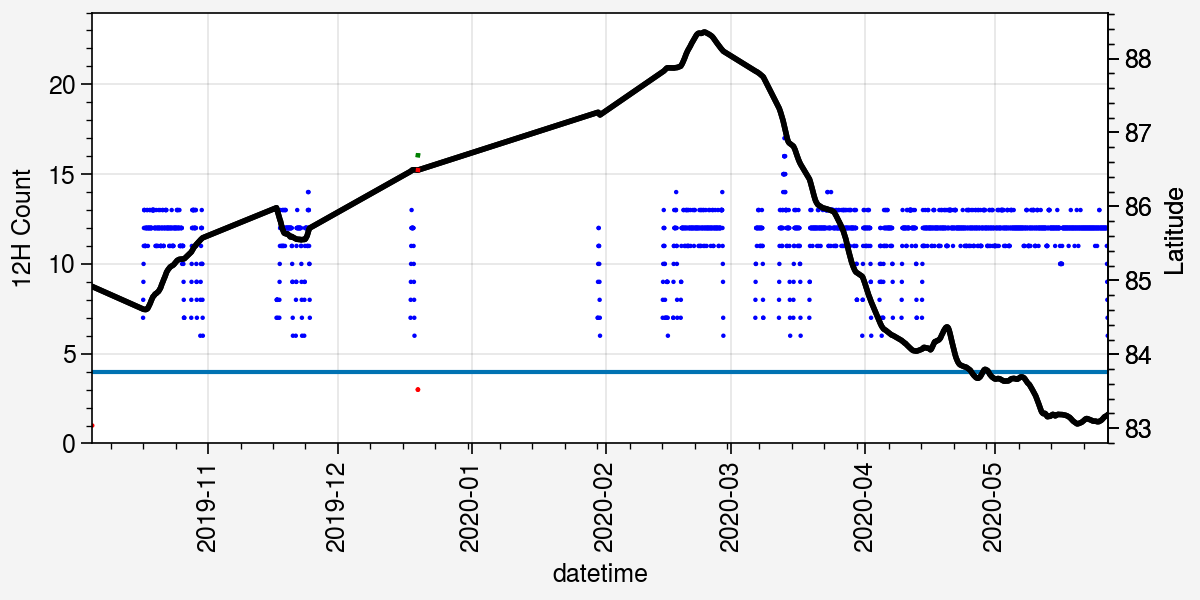

In [71]:
# Is the flag_gaps function overactive?
buoy = '2019S84'
fig, ax = pplt.subplots(ncols=1, share=False, width=6, height=3)
ax2=ax.twinx()
ax.scatter(buoy_data[buoy].latitude.rolling('12H', center=True).count(),
              c=buoy_data[buoy].flag_gaps.astype(int), cmap='bwr', markersize=1)
ax2.plot(buoy_data[buoy].latitude, color='k', lw=2)
ax2.plot(buoy_data[buoy].where(buoy_data[buoy].flag_gaps==1).latitude, color='r')
ax2.plot(buoy_data[buoy].where(clean.check_dates(buoy_data[buoy].where(buoy_data[buoy]['flag_date']==0),
                  date_index=True, check_gaps=True,
                  gap_threshold=np.min([4.1, 6/buoy_freq[buoy]]), gap_window='12H')).latitude + 0.2, color='g')


ax.format(ylabel='12H Count', ylim=(0, 24))
ax2.format(ylabel='Latitude')
ax.axhline(4)

In [55]:
clean.check_dates(buoy_data[buoy].where(buoy_data[buoy]['flag_date']==0),
                  date_index=True, check_gaps=True,
                  gap_threshold=np.min([6, 6/buoy_freq[buoy]]), gap_window='12H')

datetime
2019-10-07 03:30:00     True
2019-10-07 04:30:00     True
2019-10-07 05:30:00    False
2019-10-07 07:30:00    False
2019-10-07 09:30:00    False
                       ...  
2020-10-07 19:30:00    False
2020-10-07 20:29:59    False
2020-10-07 21:30:01    False
2020-10-08 13:40:01     True
2020-10-08 17:29:59     True
Length: 6645, dtype: bool

In [11]:
# save qc'd data
for buoy in buoy_data:
    buoy_data[buoy].to_csv('../data/mosaic_qc/' + metadata.loc[buoy, 'filename'] + '.csv')

In [68]:
saveloc = '../data/mosaic_interpolated/'
buoy_data_interp = {}
for buoy in buoy_data:
    flagged = buoy_data[buoy][['flag_date', 'flag_gaps', 'flag_position', 'flag_outlier']].sum(axis=1) > 0 
    data = buoy_data[buoy].where(~flagged).dropna()
    
    data_interp = interp.interpolate_buoy_track(
        data.loc[slice(pd.to_datetime(begin)-margin,
                       pd.to_datetime(end)+margin)],
        xvar='longitude', yvar='latitude', freq='1H',
        maxgap_minutes=240)
    
    # What's the point of this step?
    data_interp['day_count'] = data_interp.rolling(window='1D', center=True).count()['longitude']
    data_interp = data_interp.where(data_interp.day_count >= 12).dropna()

    # Compute speed with interpolated data
    data_interp = clean.compute_speed(
        data_interp, date_index=True,
        rotate_uv=True, difference='centered')

    # Write to file
    data_interp.to_csv(saveloc + metadata.loc[buoy, 'filename'] + '.csv')


    buoy_data_interp[buoy] = data_interp

In [124]:
files = os.listdir(saveloc)
files = [f for f in files if f != '.DS_Store']
buoy_data_interp = {}
for file in files:
    buoy = file.split('_')[-1].split('.')[0]
    buoy_data_interp[buoy] = pd.read_csv(saveloc + file,
                                        index_col=0, parse_dates=True)

For the most part, the interpolation looks good. There's a few where I think
the flagging step may have been too aggressive, so the speed in the interpolated
data has lots of gaps. High frequency (likely in my opinion spurious, but checking 
coherence between nearby buoys would help) is smoothed out by the interpolation and
downsampling steps.

P137 has a particularly bad spell in November. S81 and S84 also. P136 in December. (and 146 and 148).
There's also periods where I'm likely being to aggressive with masking data.

In [81]:
fix_buoys = ['2019P101', '2019P137', '2019P138', '2019P139',
'2019P146', '2019P143', '2019P142', '2019P136',
'2019T63', '2019S84', '2019T72', '2020E1', 'ASFSTUCB1',
'2019P187', '2019S81']

TypeError: 'slice' object is not subscriptable

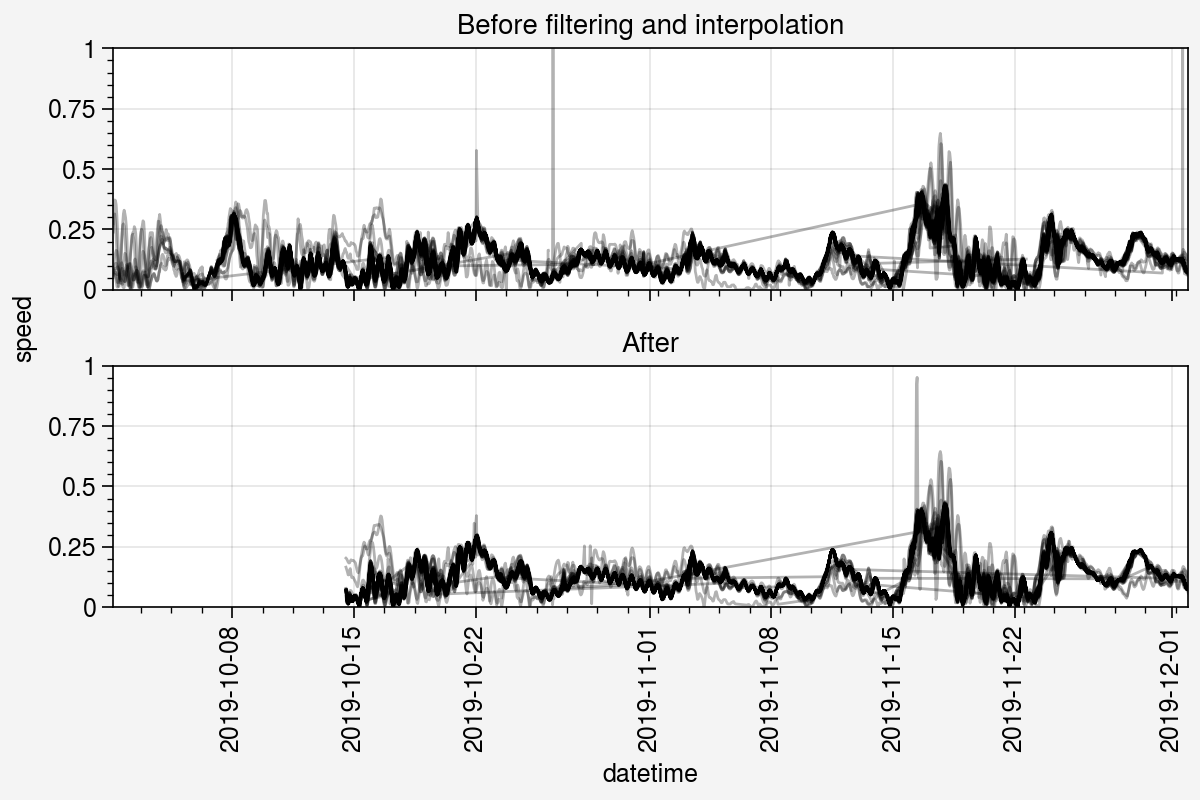

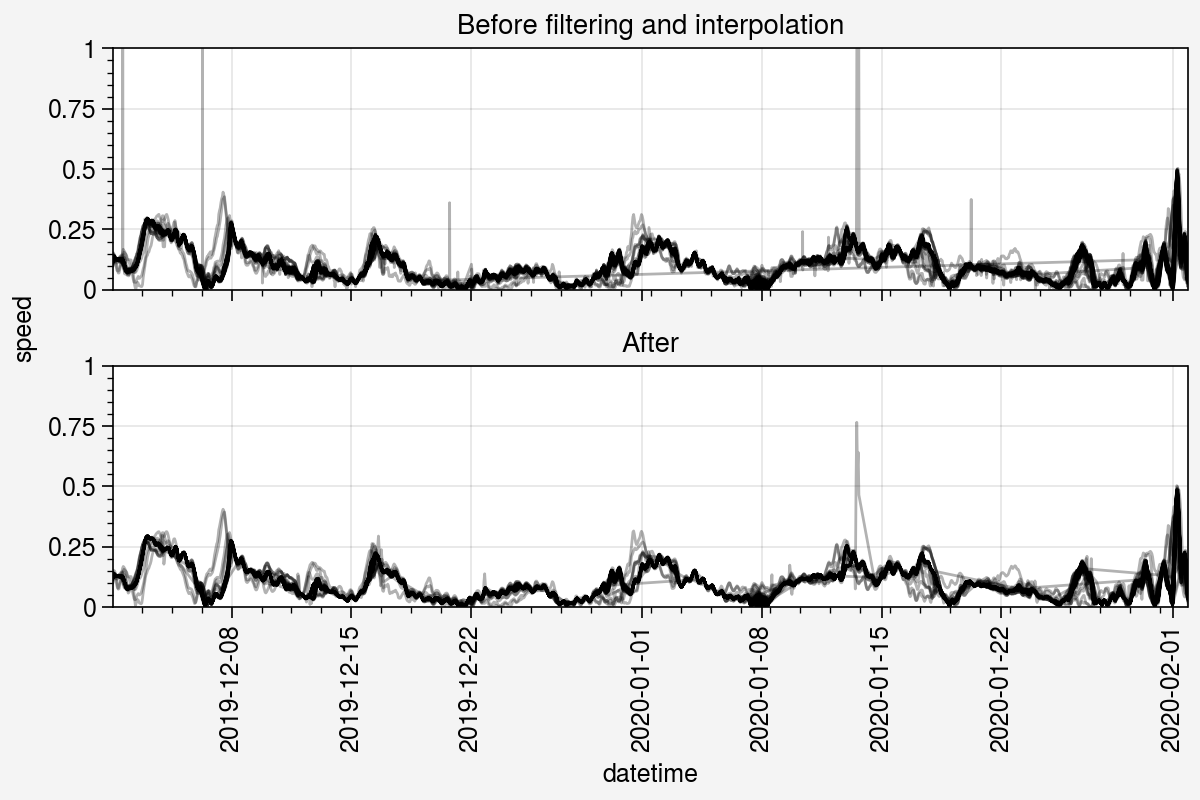

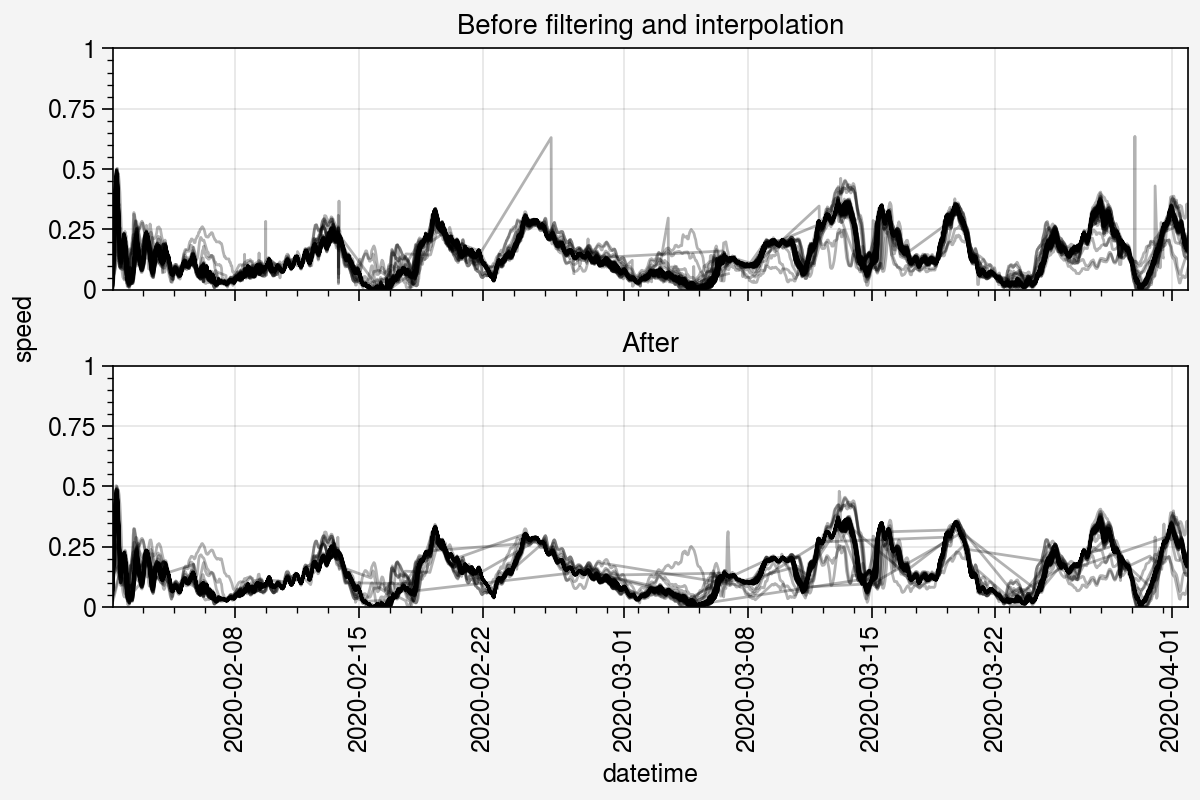

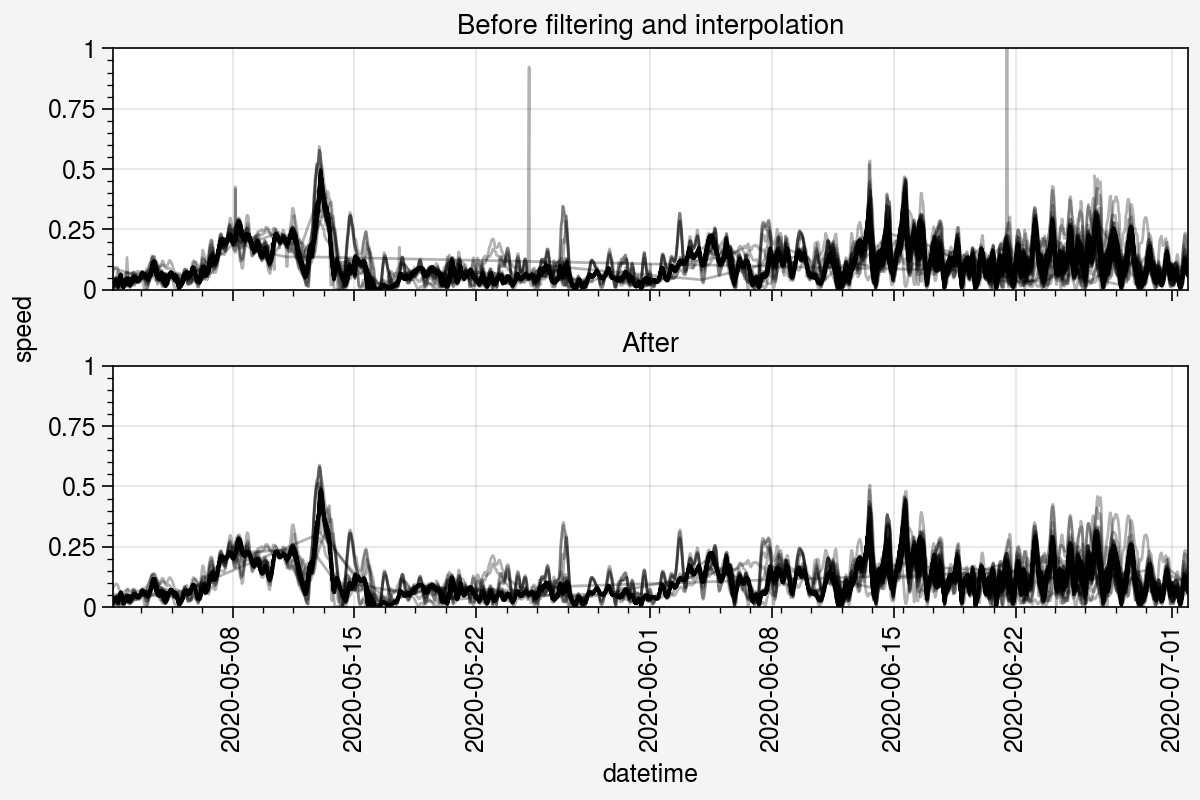

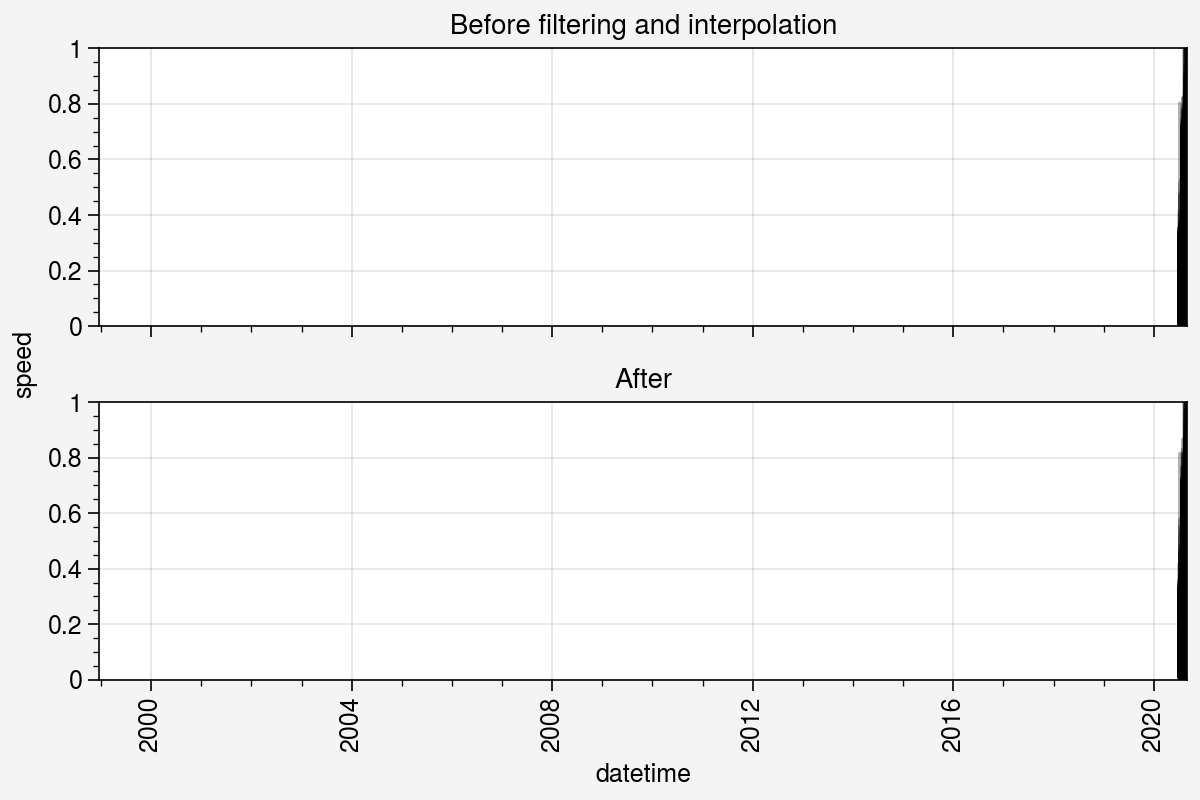

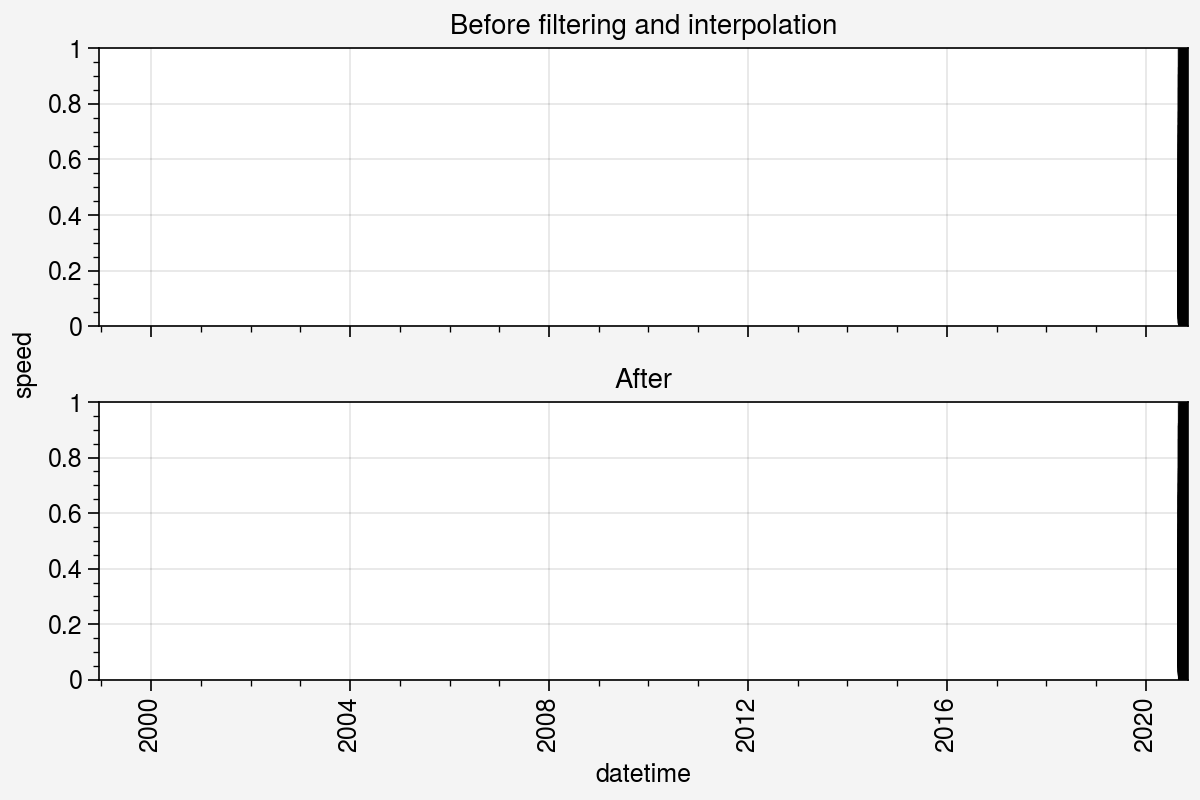

In [102]:

times_to_check = [slice('2019-10-01', '2019-12-01'),
                  slice('2019-12-01', '2020-02-01'),
                  slice('2020-02-01', '2020-04-01'),
                  slice('2020-05-01', '2020-07-01'),
                  slice('2020-07-01', '2020-09-01'),
                  slice('2020-09-01', '2020-11-01')]

for name, timeslice in zip(['oct', 'dec', 'feb', 'may', 'jul', 'sep'], times_to_check):
    buoys = [buoy for buoy in buoy_data if len(buoy_data[buoy].loc[timeslice]) > 20]
    low_lat = [buoy for buoy in buoy_data if buoy_data[buoy]['latitude'].loc[timeslice].median() < 65]

    if len(low_lat) == 0:
        fig, ax = pplt.subplots(width=6, height=4, nrows=2)
        for buoy in buoy_data_interp:

#             if buoy in fix_buoys:
#                 c='r'
#             else:
#                 c='k'

            c = 'k'
            ax[0].plot(buoy_data[buoy]['speed'].loc[timeslice], lw=1, marker='', markersize=2,
                    alpha=0.3, color=c)


            ax[1].plot(buoy_data_interp[buoy]['speed'].loc[timeslice], lw=1, marker='', markersize=2,
                    alpha=0.3, color=c)
            ax[0].format(title='Before filtering and interpolation', ylim=(0, 1))
            ax[1].format(title='After', ylim=(0, 1))
        fig.save('../sample/examples/' + name + '_speed.jpg', dpi=300)

    else:
        fig, ax = pplt.subplots(width=6, height=4, nrows=2)
        for buoy in low_lat:

#             if buoy in fix_buoys:
#                 c='r'
#             else:
#                 c='k'
            c = 'k'

            ax[0].plot(buoy_data[buoy]['speed'].loc[timeslice], lw=1, marker='', markersize=2,
                    alpha=0.3, color=c)


            ax[1].plot(buoy_data_interp[buoy]['speed'].loc[timeslice], lw=1, marker='', markersize=2,
                    alpha=0.3, color=c)
            ax[0].format(title='Before filtering and interpolation', ylim=(0, 1))
            ax[1].format(title='After', ylim=(0, 1))
        fig.save('../sample/examples/' + name + '_speed_lowlat.jpg', dpi=300)

        fig, ax = pplt.subplots(width=6, height=4, nrows=2)
        for buoy in [b for b in buoys if b not in low_lat]:
            if buoy in fix_buoys:
                c='r'
            else:
                c='k'

            ax[0].plot(buoy_data[buoy]['speed'].loc[timeslice], lw=1, marker='', markersize=2,
                    alpha=0.3, color=c)


            ax[1].plot(buoy_data_interp[buoy]['speed'].loc[timeslice], lw=1, marker='', markersize=2,
                    alpha=0.3, color=c)
            ax[0].format(title='Before filtering and interpolation', ylim=(0, 1))
            ax[1].format(title='After', ylim=(0, 1))
        fig.save('../sample/examples/' + name + '_speed.jpg', dpi=300)

In [125]:
gaps['oct']

2019R9       0
2019P142    74
2019T66      0
2019R8       0
2019P203     0
            ..
2019S81      0
2019O5       0
2019P158     0
2019T64      0
2019P103     0
Length: 112, dtype: int64

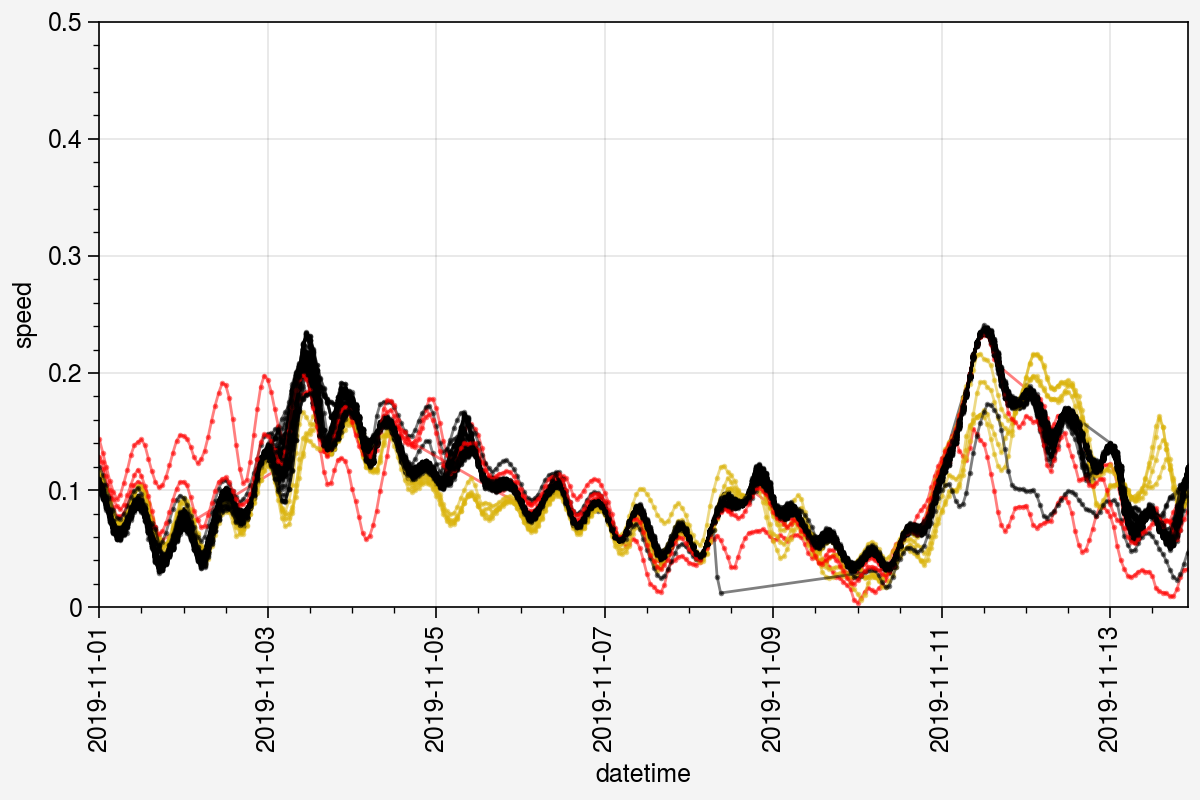

In [128]:
timeslice=slice('2019-11-01', '2019-11-13')
buoys = [buoy for buoy in buoy_data if len(buoy_data[buoy].loc[timeslice]) > 20]
low_lat = [buoy for buoy in buoy_data if buoy_data[buoy]['latitude'].loc[timeslice].median() < 65]
distant_east = ['2019P128', '2019P182', '2019P184', '2019P127']
distant_south = ['2019P152', '2019P155', '2019P156', '2019P157']


fig, ax = pplt.subplots(width=6, height=4, nrows=1)
for buoy in buoy_data_interp:
    if buoy in gaps['oct']:
        if gaps['oct'][buoy]==0:
            c = 'k'
            if buoy in distant_east:
                c='gold'
            elif buoy in distant_south:
                c='red'
            ax.plot(buoy_data_interp[buoy]['speed'].loc[timeslice], lw=1, marker='.', markersize=2,
                alpha=0.5, color=c)
name = 'example_differences'
ax.format(ylim=(0, 0.3))
fig.save('../sample/examples/' + name + '_speed.jpg', dpi=300)



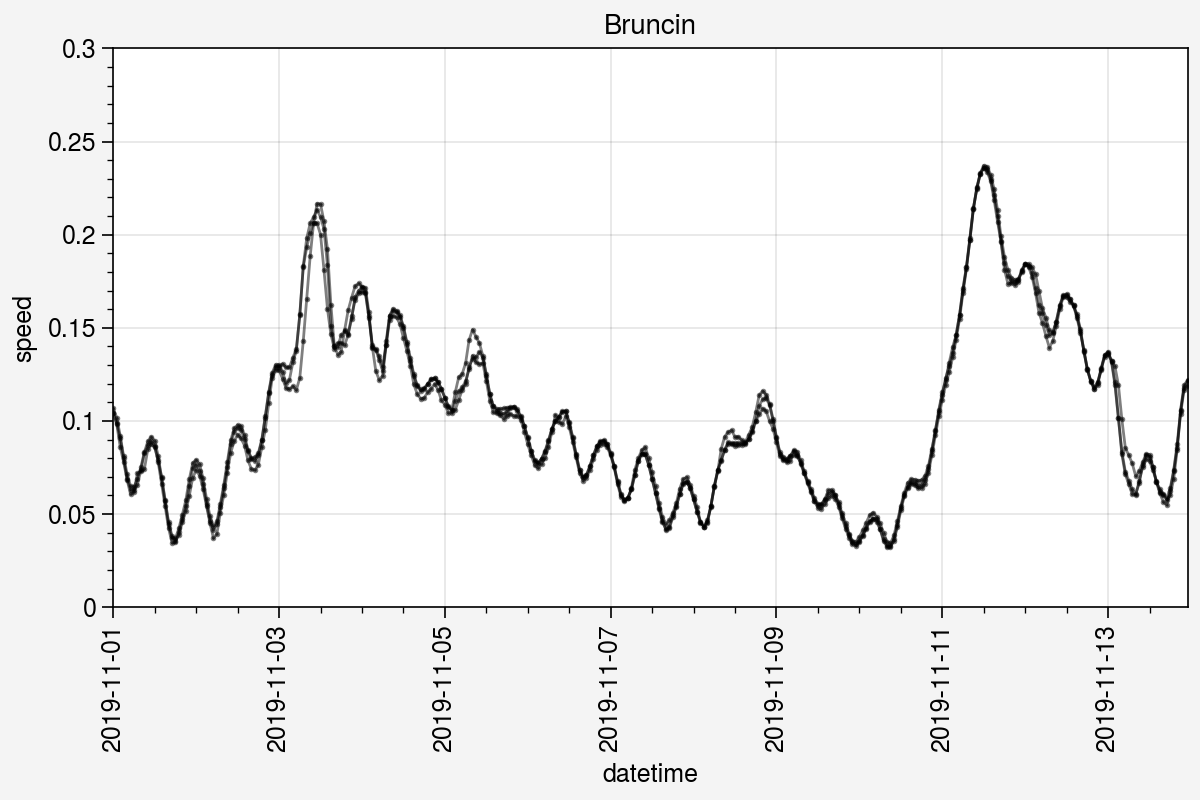

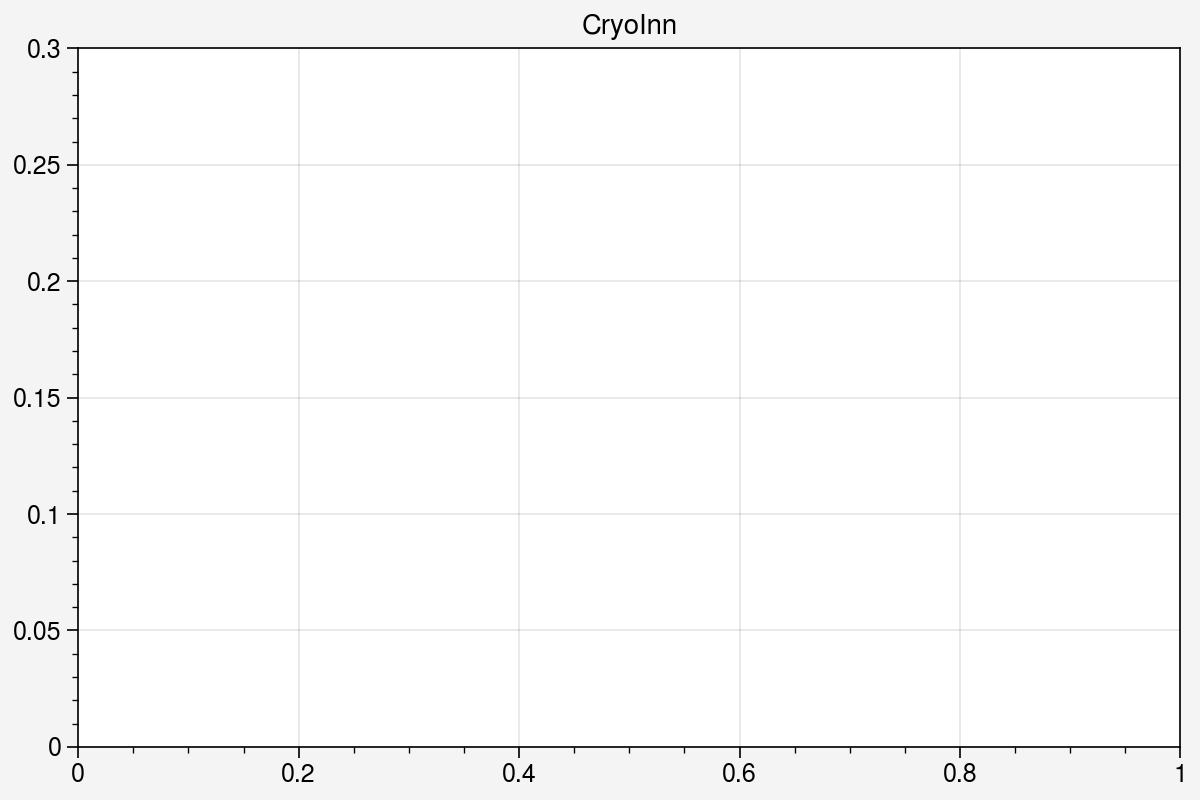

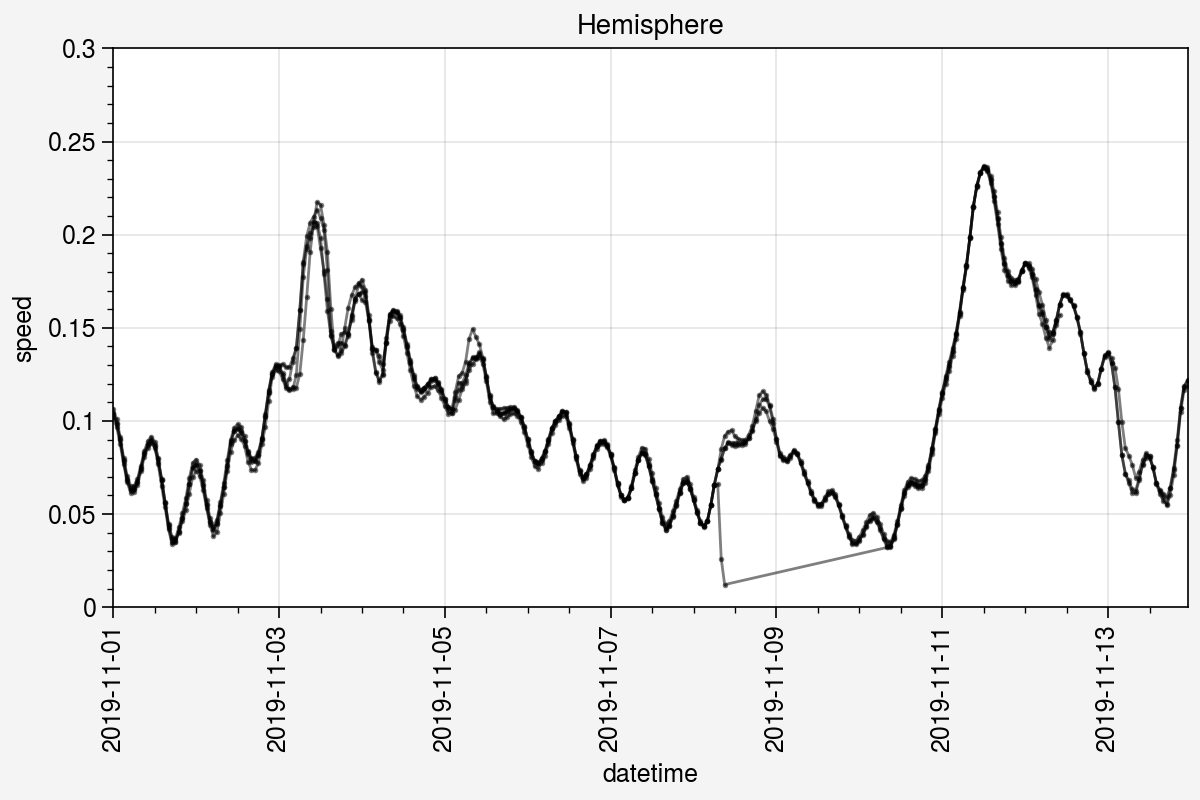

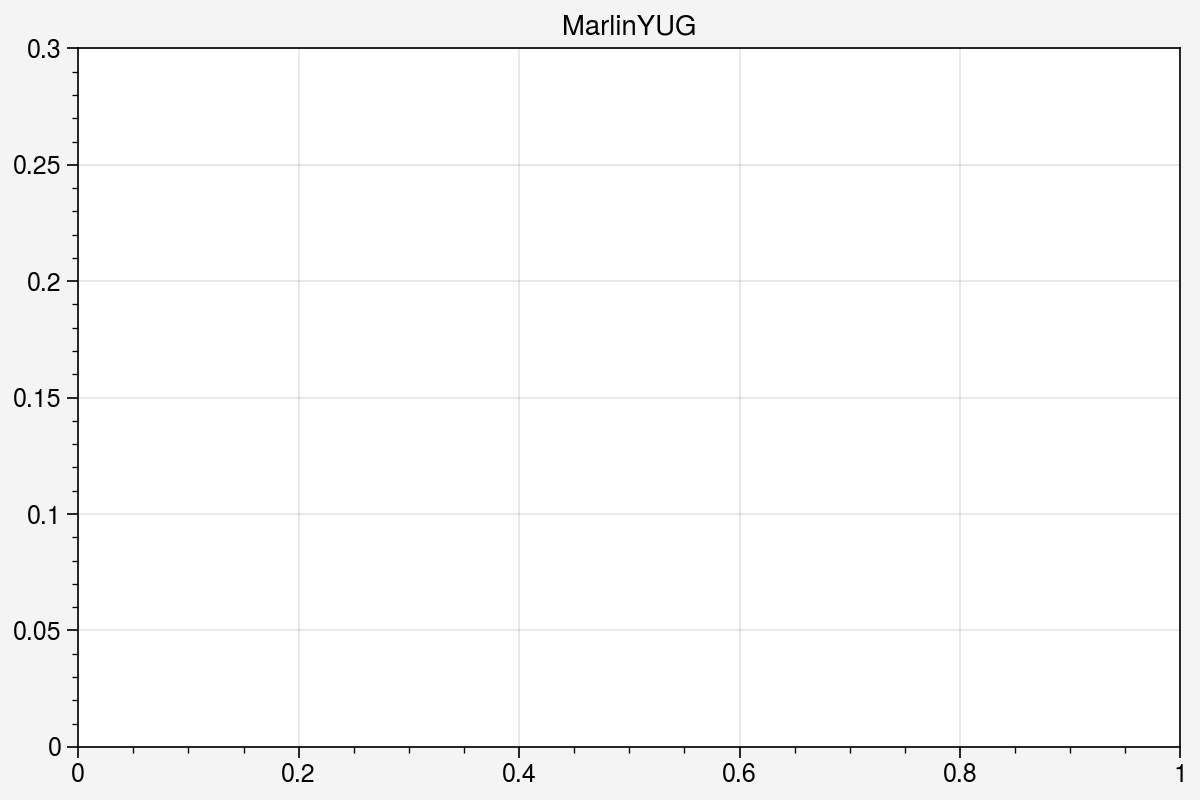

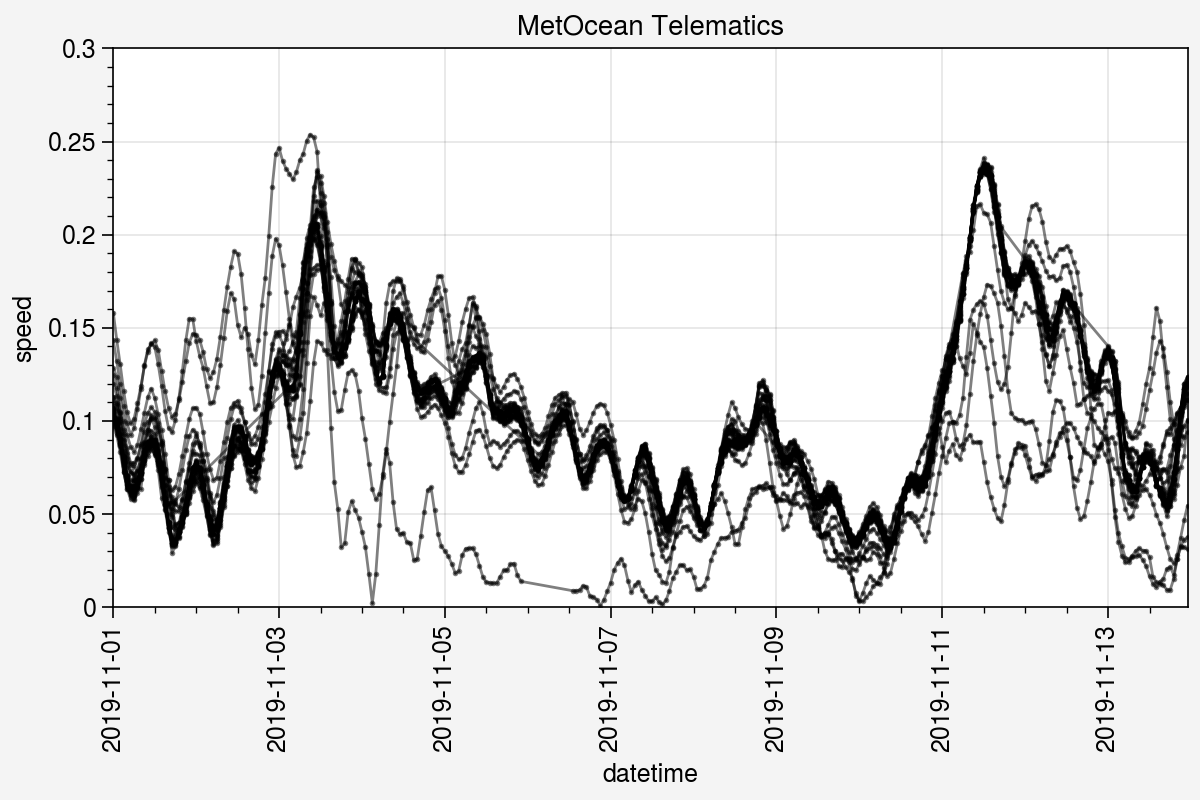

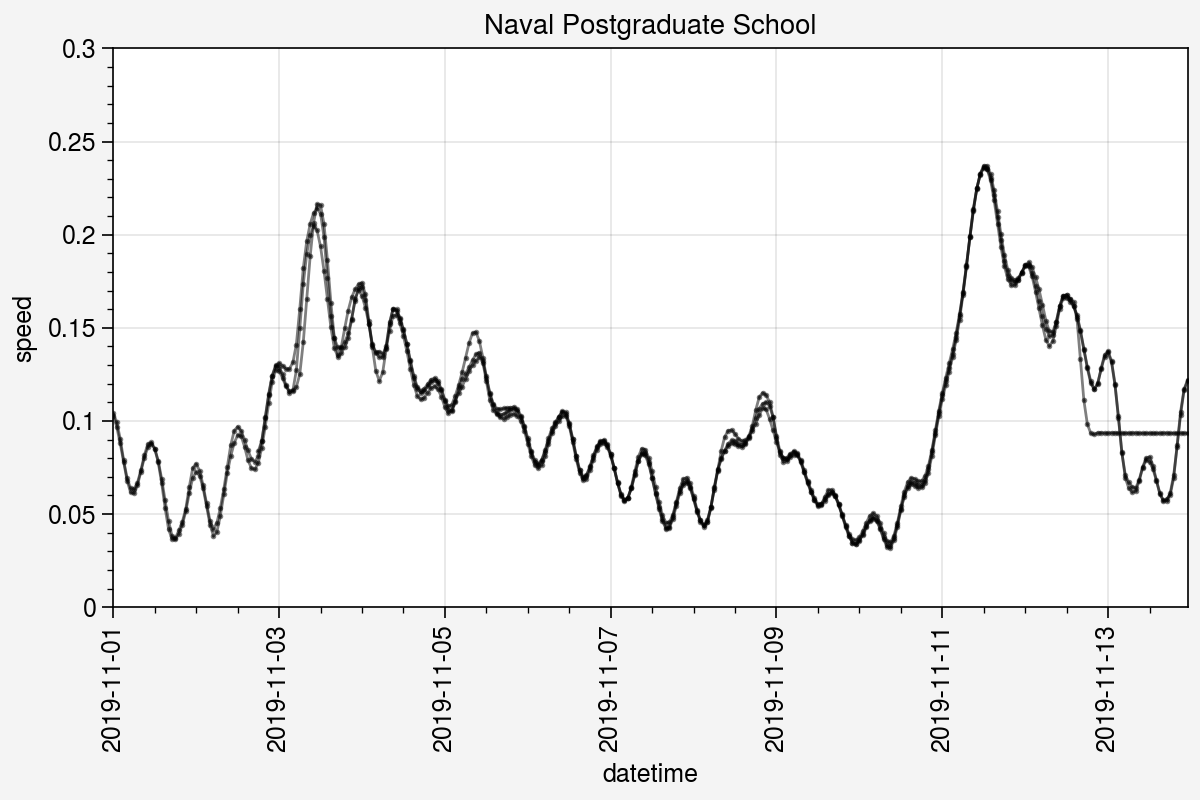

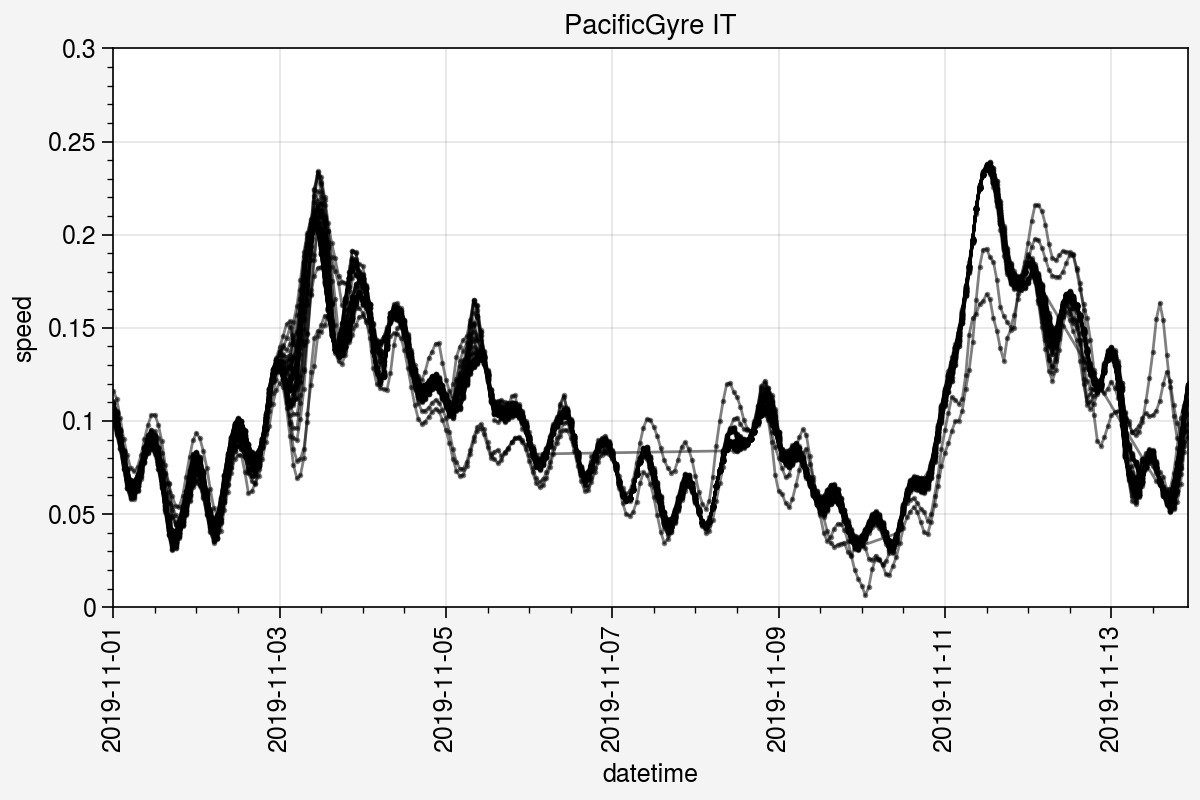

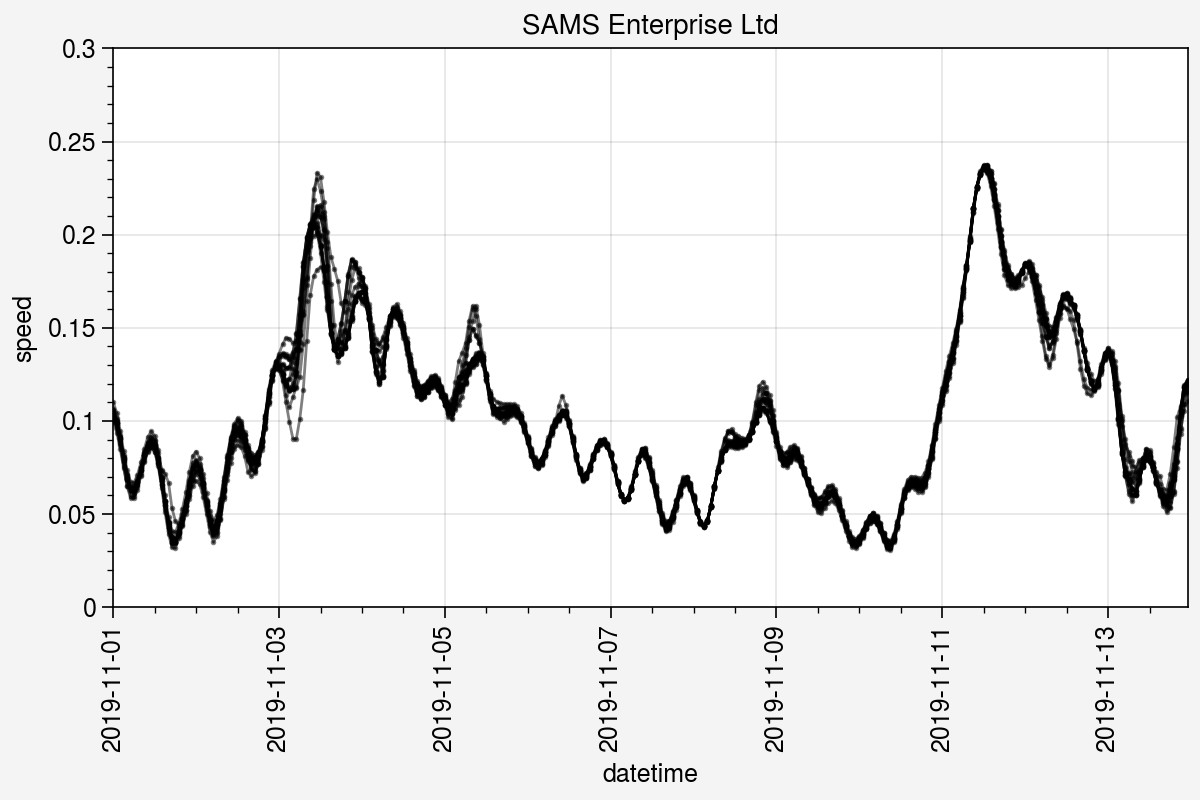

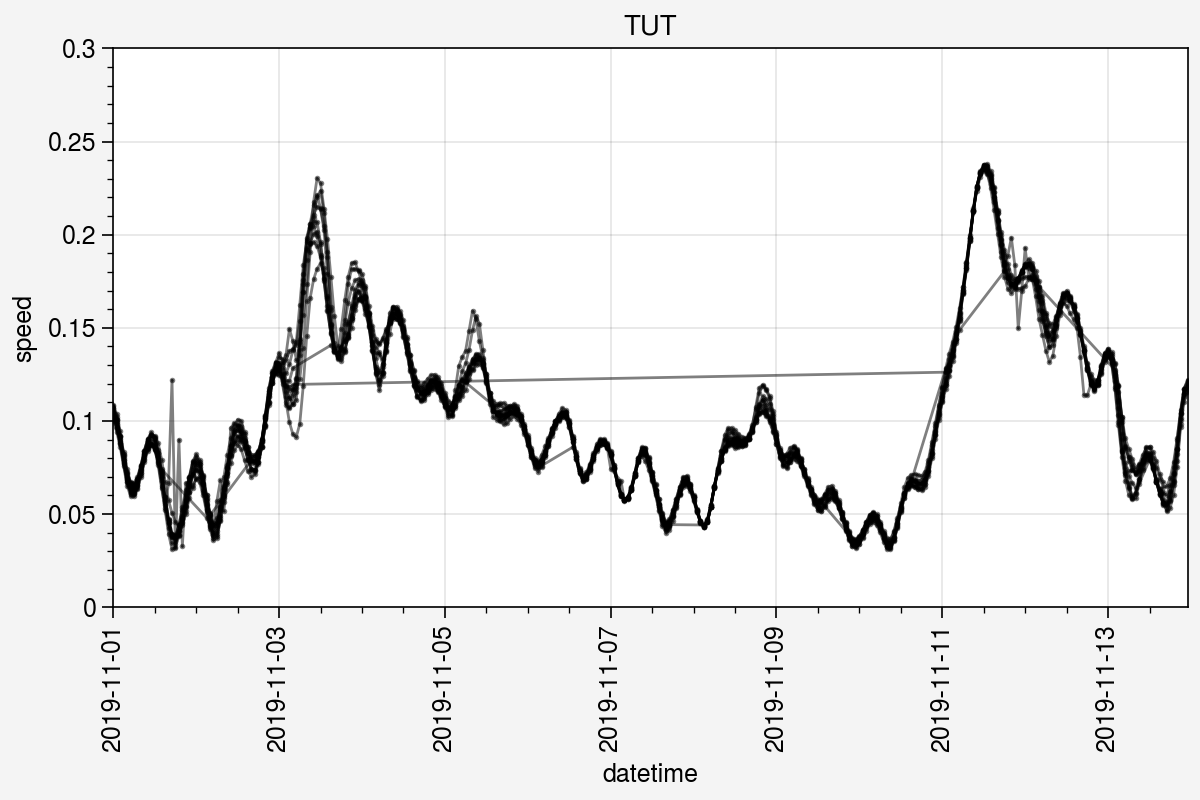

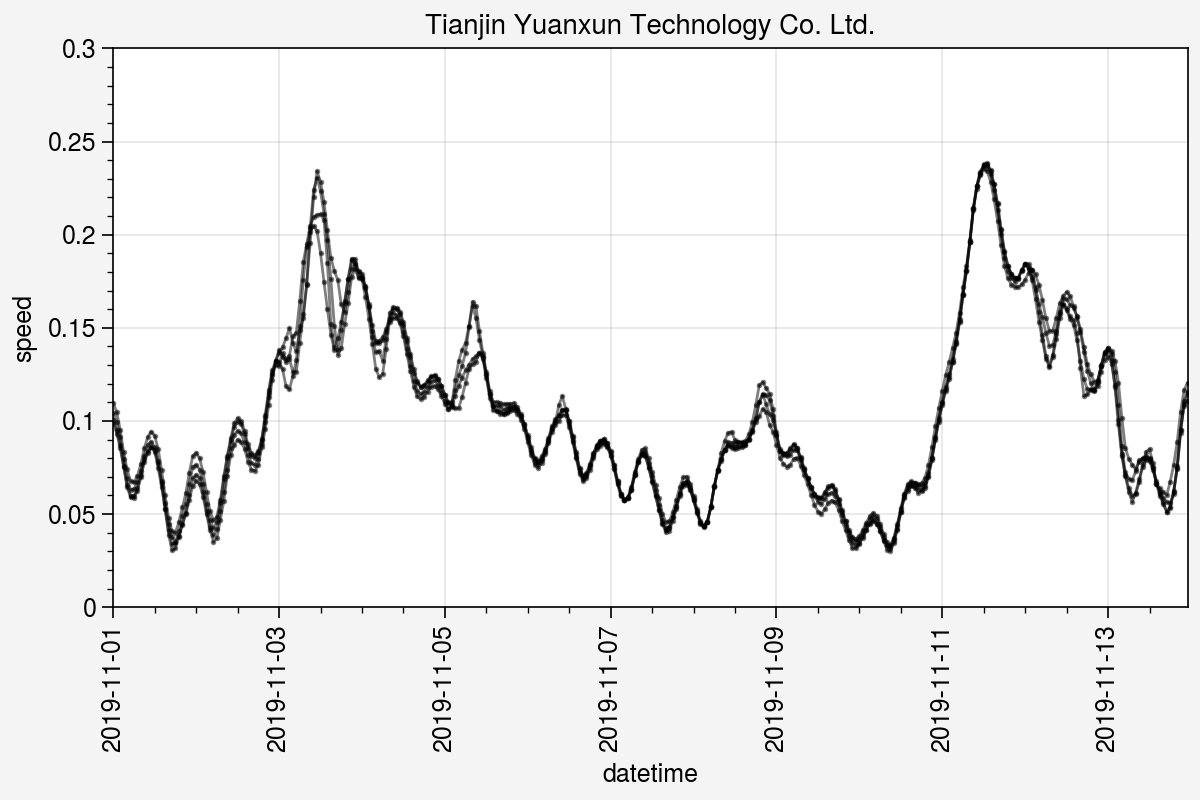

In [137]:
timeslice=slice('2019-11-01', '2019-11-13')
buoys = [buoy for buoy in buoy_data if len(buoy_data[buoy].loc[timeslice]) > 20]
low_lat = [buoy for buoy in buoy_data if buoy_data[buoy]['latitude'].loc[timeslice].median() < 65]
distant_east = ['2019P128', '2019P182', '2019P184', '2019P127']
distant_south = ['2019P152', '2019P155', '2019P156', '2019P157']


for name, group in metadata.groupby('Manufacturer'):
    fig, ax = pplt.subplots(width=6, height=4, nrows=1)
    for buoy in buoy_data_interp:
        if buoy in metadata.loc[metadata.Manufacturer==name].index:
            ax.plot(buoy_data_interp[buoy]['speed'].loc[timeslice], lw=1, marker='.', markersize=2,
                alpha=0.5, color=c)
    ax.format(ylim=(0, 0.3), title=name)
    #fig.save('../sample/examples/' + name + '_speed.jpg', dpi=300)




In [85]:
gaps = {}
for name, timeslice in  zip(['oct', 'dec', 'feb', 'may', 'jul', 'sep'], times_to_check):
    gaps[name] = pd.Series({buoy: (buoy_data_interp[buoy].loc[timeslice].data_gap_minutes > 120).sum()
           for buoy in buoy_data_interp if len(buoy_data_interp[buoy].loc[timeslice]) > 0})


In [94]:
for name in gaps:
    print(name, len(gaps[name][gaps[name] < 12]))

oct 96
dec 82
feb 94
may 92
jul 102
sep 79


In [100]:
for name in gaps:
    print(name, len(gaps[name][gaps[name] < 12]), gaps[name].sort_values()[::-1][0:5].index.values)

oct 96 ['2019F4' '2019F2' '2019P148' '2019P137' '2019P135']
dec 82 ['2019P137' '2019P138' '2019P146' '2019P148' '2019P101']
feb 94 ['2019F4' '2019P136' '2019P138' '2019P146' '2019P148']
may 92 ['2019P137' '2019P143' '2019P148' '2019P146' '2019O4']
jul 102 ['2019P148' '2019P137' '2019P146' '2019P142' '2019P143']
sep 79 ['2019P148' '2019P139' '2020P213' '2019P136' '2019P192']


In [90]:
big_gaps = gaps['oct'][gaps['oct'] > 12]
pd.DataFrame({'gaps': big_gaps, 'station': [metadata.loc[buoy, 'DN Station ID'] for buoy in big_gaps.index]}).sort_values('station')

gaps station
2019F4      262     CO1
ASFSTUCB1    22     CO1
2019F2      240      L2
2019V1       16      M1
2019P142     74    P008
2019P138     80    P013
2019P140    100    P021
2019P139     42    P022
2019P144     46    P024
2019P137    138    P026
2019P143     17    P032
2019P135    126    P033
2019P146    119    P034
2019P148    152    P035
2019P101     28    P042

mkdir: ../sample/dec: File exists


IndexError: list index out of range

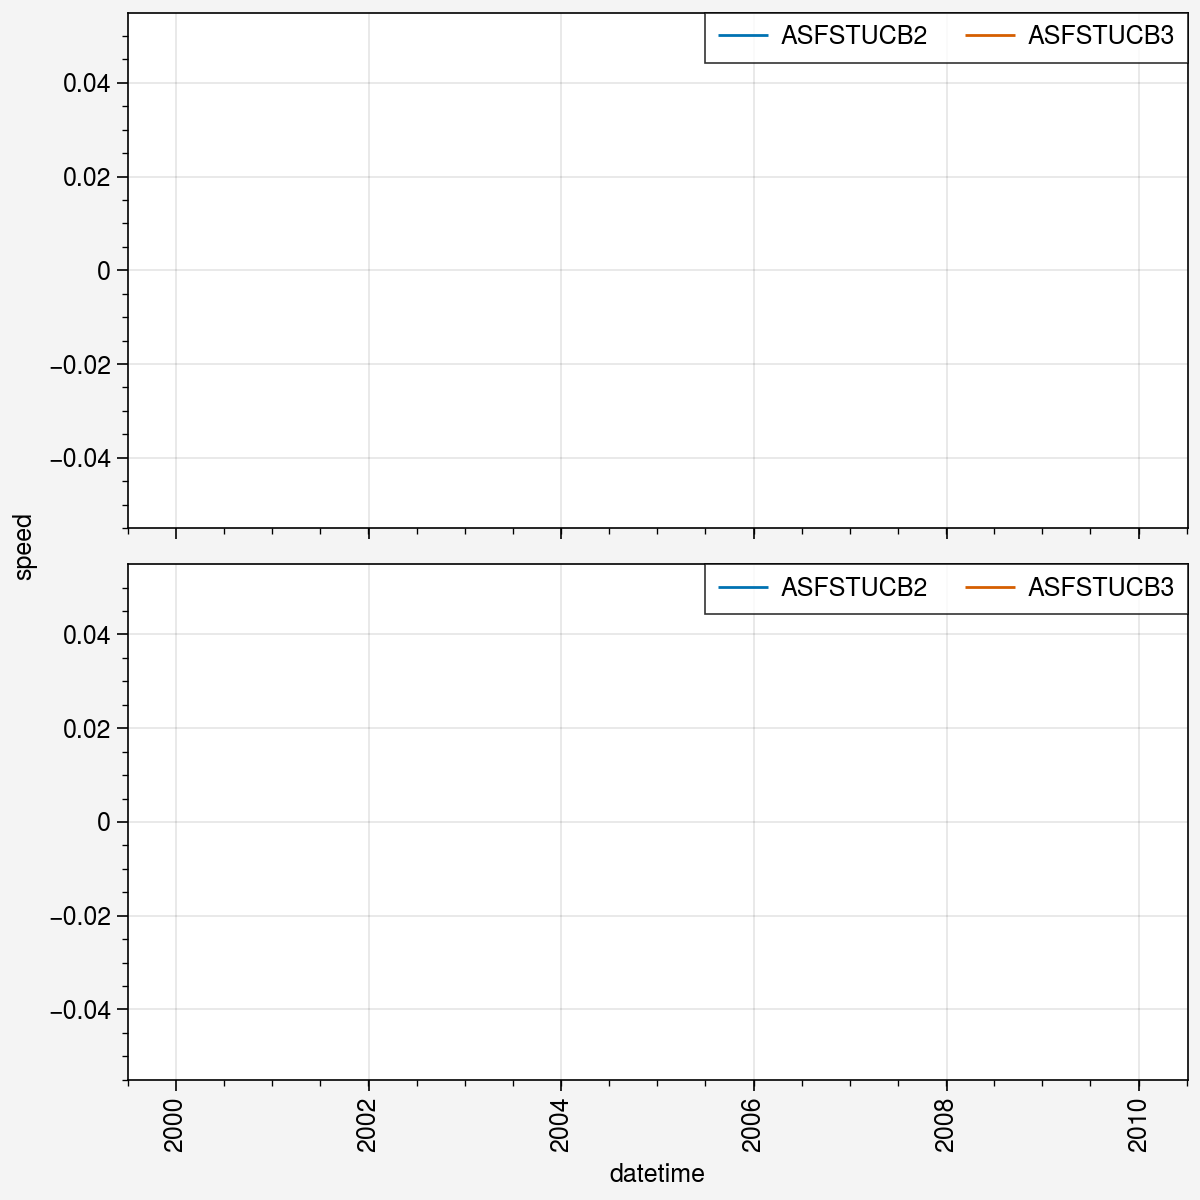

In [97]:
case = 'nov'
timeslice = slice('2019-11-15', '2019-11-20')

case = 'dec'
timeslice = slice('2019-12-15', '2019-12-20')

!mkdir ../sample/$case
for idx in np.arange(0, len(buoys))[::6]:
    fig, ax = pplt.subplots(width=6, height=6, nrows=2)
    for jdx in range(6):
        if idx + jdx < len(buoys):
            buoy = buoys[idx + jdx]
            ax[0].plot(buoy_data_interp[buoy]['speed'].loc[timeslice], marker='', lw=1, label=buoy)
            ax[1].plot(buoy_data[buoy]['speed'].loc[timeslice], marker='', lw=1, label=buoy)    
    ax[0].legend()
    ax[1].legend()
    fig.save('../sample/' + case + '/' + case + '_test_' + buoys[idx] + '-' + buoys[idx + jdx-1] + '.jpg', dpi=150)
    pplt.close(fig)

In [122]:
# Hypothesis: I'm not catching times when the speed is abnormally low - I was looking for spikes.
# The result of the error is that a spike and a dip is introduced.


In [ ]:
2019P156: too much droppin in may 2020

In [84]:
skip_buoys = ['2019P101']

'2019P101'

In [135]:
clean = reload(clean)


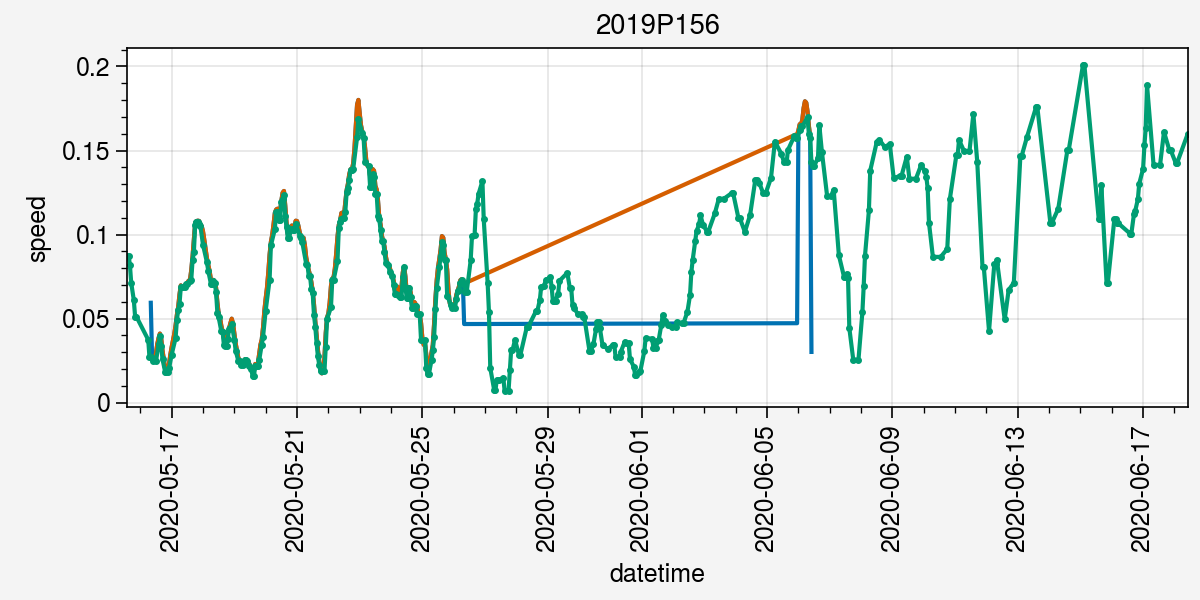

In [197]:
buoy = '2019P156'
buoy_df = buoy_data_interp[buoy].copy()
test = clean.compute_speed(buoy_df, date_index=True, rotate_uv=True, difference='centered')
timeslice=slice('2020-05-15 13:00', '2020-06-18 15:00')
fig, ax = pplt.subplots(width=6, height=3)
#ax.plot(buoy_data_interp['2019P146'].loc[timeslice, 'speed'],  marker='.')
#ax.plot(buoy_data_interp['2019P148'].loc[timeslice, 'speed'], marker='.')
ax.plot(buoy_data_interp[buoy].loc[timeslice, 'speed'], marker='')
ax.plot(test.loc[timeslice, 'speed'], marker='')
ax.plot(buoy_data[buoy].loc[timeslice, 'speed'], marker='.', markersize=3)
ax.format(title=buoy)

In [171]:
fix_buoys = ['2019P101', '2019P137', '2019P138', '2019P139',
'2019P146', '2019P143', '2019P142', '2019P136',
'2019T63', '2019S84', '2019T72', '2020E1', 'ASFSTUCB1',
'2019P187', '2019S81']

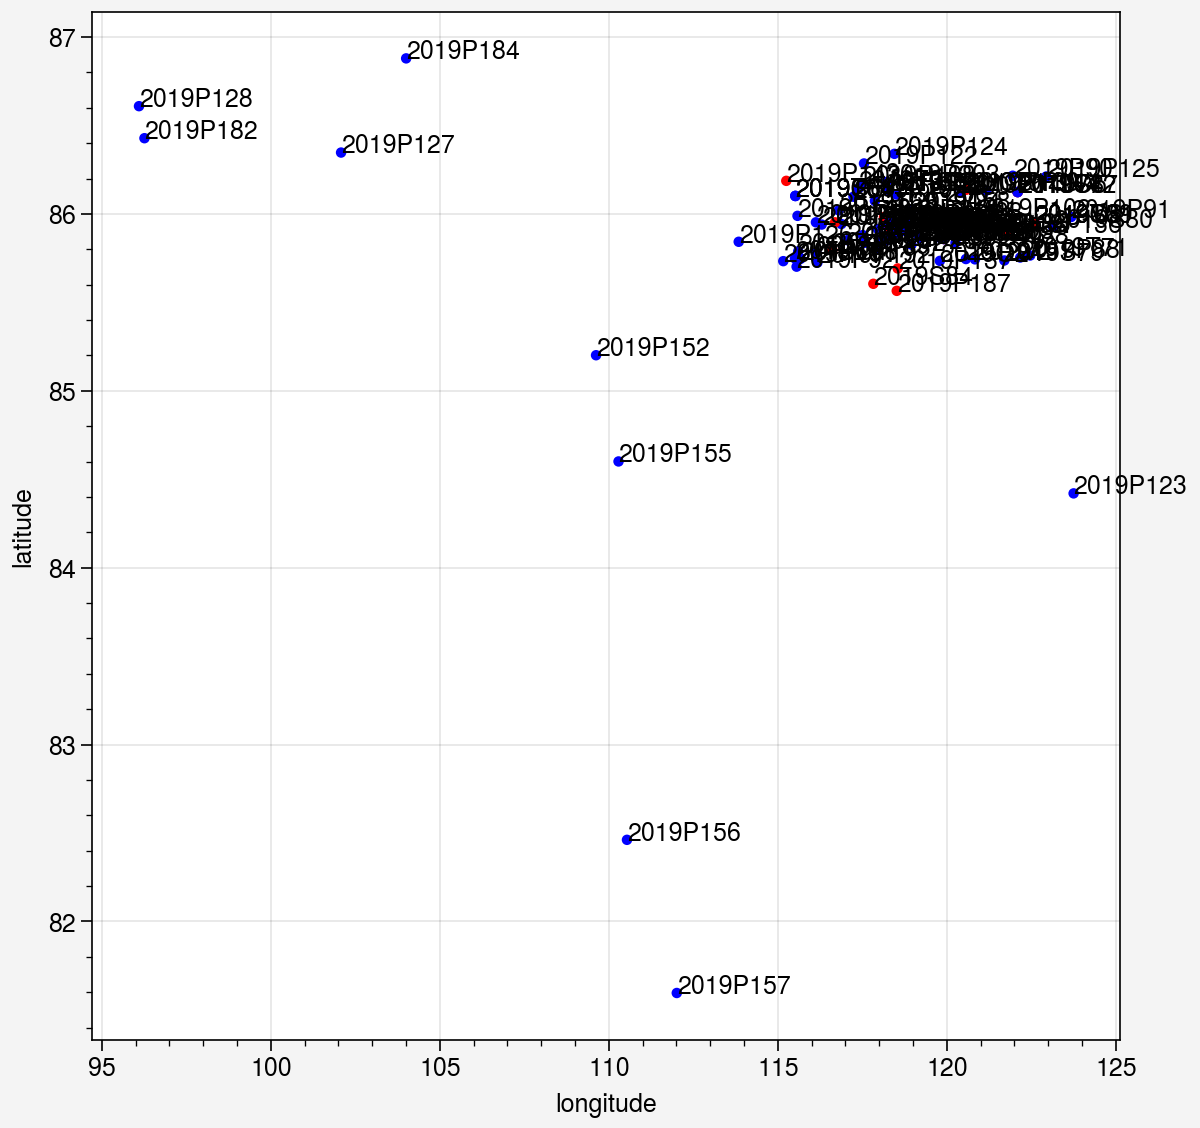

In [132]:
timeslice = slice('2019-11-01', '2019-12-01')
fig, ax = pplt.subplots(width=6)
mosdata = pd.DataFrame({buoy: buoy_data_interp[buoy].loc[timeslice].median() for buoy in buoy_data_interp}).T
mosdata['fix_buoy'] = [x in fix_buoys for x in mosdata.index]
mosdata = mosdata.dropna(subset=['latitude', 'longitude'])
#mosdata = mosdata.loc[mosdata.latitude > 80]
#mosdata = mosdata.loc[(mosdata.longitude > 60) & (mosdata.longitude < 132.2)]
ax.scatter(mosdata.longitude, mosdata.latitude,
           c=mosdata.fix_buoy.astype(int), cmap='bwr',
           markersize=10)
for x in mosdata.index:

    ax.text(mosdata.loc[x, 'longitude'],
            mosdata.loc[x, 'latitude'], x)

In [ ]:
# Key buoys to repair if possible
# 2019S84, 2019P187, 2019P137, 2019P139, 2019P143, 2019P136, 2019P146
# Less important:
# 2019P138, as long as 2019P193 is functioning (they're close to each other)


<a list of 1 Line2D objects>

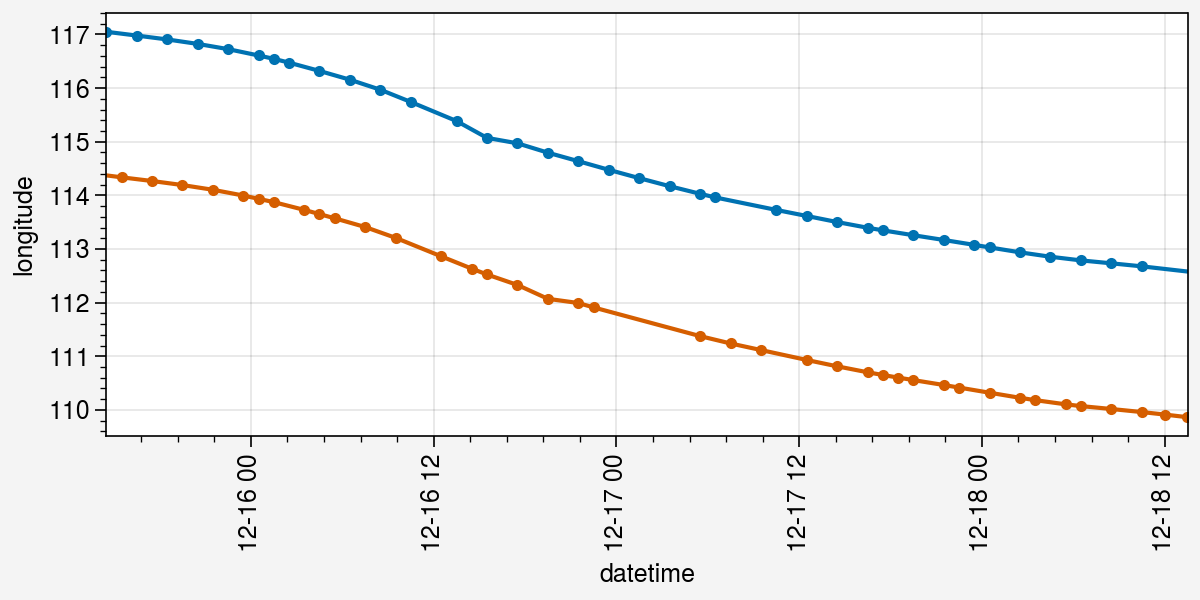

In [80]:
timeslice=slice('2019-12-15 13:00', '2019-12-18 15:00')
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(buoy_data['2019P146'].loc[timeslice, 'longitude'],  marker='.')
ax.plot(buoy_data['2019P148'].loc[timeslice, 'longitude'], marker='.')
#ax.plot(buoy_data_interp['2019P146'].loc[timeslice, 'latitude'],  marker='.')
#ax.plot(buoy_data_interp['2019P148'].loc[timeslice, 'latitude'], marker='.')

In [15]:
for buoy in buoy_data:
    buoy_data[buoy]['flag'] = buoy_data[buoy].flag_date | buoy_data[buoy].flag_position | buoy_data[buoy].flag_gaps

In [17]:
# Drift speed:
for buoy in buoy_data:
    buoy_df = buoy_data[buoy].where(buoy_data[buoy]['flag'] == 0)
    w_speed = clean.compute_speed(buoy_df.dropna().copy(), date_index=True, difference='forward')
    buoy_df.loc[w_speed.index, 'speed'] = w_speed['speed'].copy()
    buoy_df.loc[w_speed.index, 'x'] = w_speed['x'].copy()    
    buoy_df.loc[w_speed.index, 'y'] = w_speed['y'].copy()        
    buoy_data[buoy] = buoy_df

Because the buoys vary in their time resolution and in the inherent noise, naive screening for fixed velocity thresholds will not identify most spikes in estimated velocities. Furthermore, data at very high resolution (e.g. < 15min) provide noisy estimates of position, because the inherent error in position of between 10-100 m is close to the magnitude of position change. For example, if ice is moving at 0.5 m/s, it moves 450 meters in between measurements. Estimated difference in position will be between 430 and 470 in the best case scenario, and between 350 and 550 in the worst case. For ice moving more slowly, as it often is, the result of the noise could be that the uncertainty in position is larger than the position change. Per Dierking et al. 2022,
$$\sigma^2_u = \frac{1}{\Delta t^2}\sigma_{x}^2$$
With smaller time steps, the uncertainty in velocity is larger (in a sense).

In [336]:
for buoy in buoy_data:
    buoy_data[buoy]['fwd_disp'] = np.sqrt(
        (buoy_data[buoy]['x'].shift(-1) - buoy_data[buoy]['x'])**2 +\
        (buoy_data[buoy]['y'].shift(-1) - buoy_data[buoy]['y'])**2)
    buoy_data[buoy]['bwd_disp'] = np.sqrt(
        (buoy_data[buoy]['x'] - buoy_data[buoy]['x'].shift(1))**2 +\
        (buoy_data[buoy]['y'] - buoy_data[buoy]['y'].shift(1))**2)

    date = buoy_data[buoy].index.to_series()
    time_till_next = date.shift(-1) - date
    time_since_last = date - date.shift(1)

    buoy_data[buoy]['fwd_endpoint'] = time_till_next.dt.total_seconds() > \
            2*(time_till_next.dt.total_seconds()).rolling(7, ).median()
    buoy_data[buoy]['bwd_endpoint'] = time_since_last.dt.total_seconds() > \
            2*(time_since_last.dt.total_seconds()).rolling(7, ).median()

In [291]:
test_df = pd.DataFrame(
    [['2019R9', '2020-04-23 11:01:09', 'check_speed', True],
     ['2019R9', '2020-05-17 01:02:20', 'check_speed', True],
     ['2020P171','2020-12-13 00:04:00', 'check_speed', True],
     ['2020P171', '2021-01-08 20:04:01', 'check_speed', True],
     ['2020P171', '2021-01-08 16:04:02', 'check_speed', True],
     ['2019P178', '2021-01-21 13:00:28', 'check_speed', True],
     ['2019P142', '2020-04-04 14:30:00', 'check_speed', True],
     ['2019P142', '2020-05-25 01:00:00', 'check_speed', True], 
      ['2019P142', '2020-07-23 00:59:59', 'check_speed', True]],
    columns=['buoy_id', 'date', 'check_var', 'true_val'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [18]:
for buoy in buoy_data:
    x = buoy_data[buoy].where(buoy_data[buoy].flag != 1)['x']
    anomalyx = x - x.rolling(3, center=True, min_periods=3).median()
    buoy_data[buoy]['x_anom'] = anomalyx
    y = buoy_data[buoy].where(buoy_data[buoy].flag != 1)['y']
    anomalyy = y - y.rolling(3, center=True, min_periods=3).median()
    buoy_data[buoy]['y_anom'] = anomalyy
    buoy_data[buoy]['anom_dist'] = np.sqrt(anomalyx**2 + anomalyy**2)

In [195]:
def spline_check_v2(buoy_df, anom_thresh, df):
    anom_x = buoy_data[buoy].x_anom
    anom_y = buoy_data[buoy].y_anom
    anom = np.sqrt(anom_x**2 + anom_y**2)
    if 'flag_position_spline' not in buoy_df.columns:
        buoy_df['flag_position_spline'] = 0

    for date in anom[anom > anom_thresh].index:
        test = clean.test_point(date, buoy_data[buoy],
                                xvar='x', yvar='y', df=df, fit_window='24H', sigma=6)['flag']
        if np.any(test):
            buoy_df.loc[test[test].index, 'flag_position_spline'] = 1
    
    return buoy_df

In [155]:
def calc_speed_for_outlier_check(buoy_df, date_index=True):
    """Computes a measure of speed adapted for flagging bad data.
    Since most of the buoy data has some gaps, the algorithm needs 
    to calculate speed different at the start and end of regular observations
    versus in the middle of regular observations. It does this by looking
    at delta_t_prior and delta_t_post, the times since last and till
    next. If both are approximately the same size, then the returned 
    speed is the minimum of the forward and the backward difference estimates
    of velocity. If delta_t_prior << delta_t_post, only the backward difference is
    used. Otherwise the forward difference is used."""

    date_index=True
    buoy_df = buoy_df.dropna(subset=['latitude', 'longitude']).copy()
  
    if date_index:
        date = pd.Series(pd.to_datetime(buoy_df.index.values).round('1min'),
                         index=buoy_df.index)
    else:
        date = pd.to_datetime(buoy_df.date).round('1min')

    delta_t_next = date.shift(-1) - date
    delta_t_prior = date - date.shift(1)

    fwd_speed = clean.compute_speed(buoy_df.copy(), date_index=True, difference='forward')['speed']  
    bwd_speed = clean.compute_speed(buoy_df.copy(), date_index=True, difference='backward')['speed']

    min_dt = pd.DataFrame({'dtp': delta_t_prior, 'dtn': delta_t_next}).min(axis=1)

    # bwd endpoint means the next expected obs is missing: last data before gap
    bwd_endpoint = (delta_t_prior < delta_t_next) & (np.abs(delta_t_prior - delta_t_next) > 2*min_dt)
    fwd_endpoint = (delta_t_prior > delta_t_next) & (np.abs(delta_t_prior - delta_t_next) > 2*min_dt)

    buoy_df['speed'] = pd.DataFrame({'bwd': bwd_speed, 'fwd': fwd_speed}).min(axis=1)
    buoy_df.loc[fwd_endpoint, 'speed'] = fwd_speed.loc[fwd_endpoint]
    buoy_df.loc[bwd_endpoint, 'speed'] = bwd_speed.loc[bwd_endpoint]
    
    return buoy_df

In [369]:
def identify_outliers(buoy_df, error_threshold, fit_margin, sigma=6, detailed_return=False):
    """Flags data that are likely outliers based on three criteria:
    1. Data have anom_dist > sigma*anom_std
    2. anom_dist is a local max
    3. speed is a local max
    4. Interpolation error is greater than the error_threshold
    Returns a boolean series of the same length as buoy_df, unless
    detailed_return=True, in which case a dataframe with the tested values is returned."""

    def est_middle(date, data, xvar, yvar):
        from scipy.interpolate import interp1d
        """Similar to the savgol filter, estimate the value at date with a polynomial fit.
        """
        t0 = (data.drop(date).index - data.index[0]).total_seconds()
        t1 = (date - data.index[0]).total_seconds()

        X = data.drop(date).loc[:,[xvar, yvar]].T
        return interp1d(t0, X.values, bounds_error=False, kind='cubic')(t1).T
   
    fit_margin = pd.to_timedelta(fit_margin)
    #anom_std = np.sqrt(2 * buoy_df['anom_dist'].where(buoy_df['anom_dist'] > 0).mean())
    anom_std = np.sqrt(2 * buoy_df['anom_dist'].where(buoy_df['anom_dist'] > 0).mean())
    test_dates = buoy_df[['anom_dist', 'speed']][buoy_df['anom_dist'] > sigma*anom_std]
    test_dates = test_dates.sort_values('anom_dist')[::-1]

    #anom_above_threshold = buoy_df['anom_dist'] > (buoy_df.where(buoy_df.anom_dist > 0)['anom_dist']).rolling('30D', center=True).median()*2
    #speed_above_threshold = buoy_df['speed'] > buoy_df['speed'].rolling('30D', center=True).median()*2
    anom_local_max = buoy_df['anom_dist'] == buoy_df['anom_dist'].rolling(fit_margin, center=True).max()
    speed_local_max = buoy_df['speed'] == buoy_df['speed'].rolling(fit_margin, center=True).max()

    test_dates['anom_max'] = anom_local_max.loc[test_dates.index]
    test_dates['speed_max'] = speed_local_max.loc[test_dates.index]
    #canidates = (test_dates.anom_max & test_dates.speed_max).index
    test_dates['interp_error'] = np.nan

    for date in test_dates.index:
        date=pd.to_datetime(date)
        x0 = buoy_df.loc[date, 'x']
        y0 = buoy_df.loc[date, 'y']
        x1, y1 = est_middle(date, buoy_df.loc[slice(date-fit_margin, date+fit_margin)], 'x', 'y') 
        test_dates.loc[date, 'interp_error'] = np.sqrt((x0-x1)**2 + (y0-y1)**2)

    test_dates['exceeds_threshold'] = test_dates['interp_error'] > error_thresh
    test_dates['decision'] = (test_dates.anom_max & test_dates.speed_max) & test_dates.exceeds_threshold

    if detailed_return:
        return test_dates

    else:
        flag = pd.Series(dtype=bool, index=buoy_df.index)
        flag[test_dates['decision'].index] = True
        return flag

In [372]:

buoy = '2019O1'
buoy_df = buoy_data[buoy].copy()
buoy_df = calc_speed_for_outlier_check(buoy_df, date_index=True)
error_thresh = data_thresh.groupby('freq').quantile(0.9).loc[data_thresh.loc[buoy, 'freq']].values[0]


flag = identify_outliers(buoy_df, error_thresh, fit_margin='12H', sigma=6, detailed_return=False)
outliers = identify_outliers(buoy_df, error_thresh, fit_margin='12H', sigma=6, detailed_return=True)
outliers.loc[outliers.decision]

anom_dist     speed  anom_max  speed_max  interp_error  \
datetime                                                                       
2020-02-09 17:00:00  145.576593  0.283768      True       True    189.443471   
2019-10-05 06:00:00   55.817117  0.116493      True       True     79.299327   
2019-12-14 00:50:00   46.681790  0.082313      True       True     49.458549   
2020-03-22 17:20:01   29.563803  0.059591      True       True     41.877571   
2020-02-20 02:20:01   24.805255  0.211816      True       True     72.074188   
2020-07-25 04:40:01   22.604462  0.037727      True       True     47.523197   
2019-12-10 05:40:00   11.132817  0.145212      True       True     27.796640   

                     exceeds_threshold  decision  
datetime                                          
2020-02-09 17:00:00               True      True  
2019-10-05 06:00:00               True      True  
2019-12-14 00:50:00               True      True  
2020-03-22 17:20:01               True      True  
2020-02-20 02:20:01               True      True  
2020-07-25 04:40:01               True      True  
2019-12-10 05:40:00               True      True

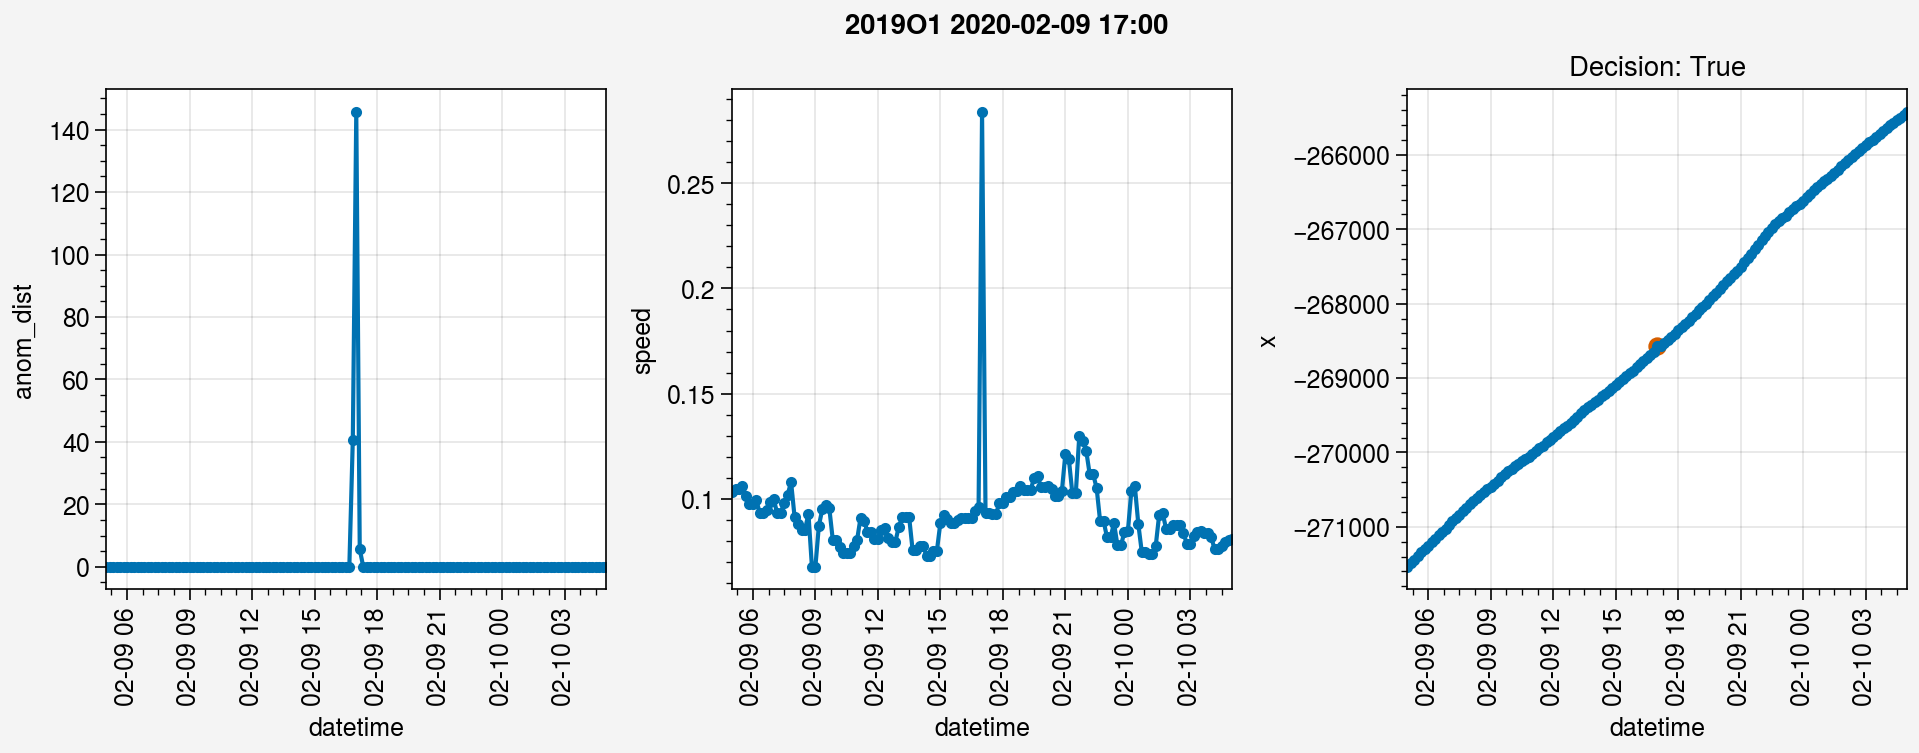

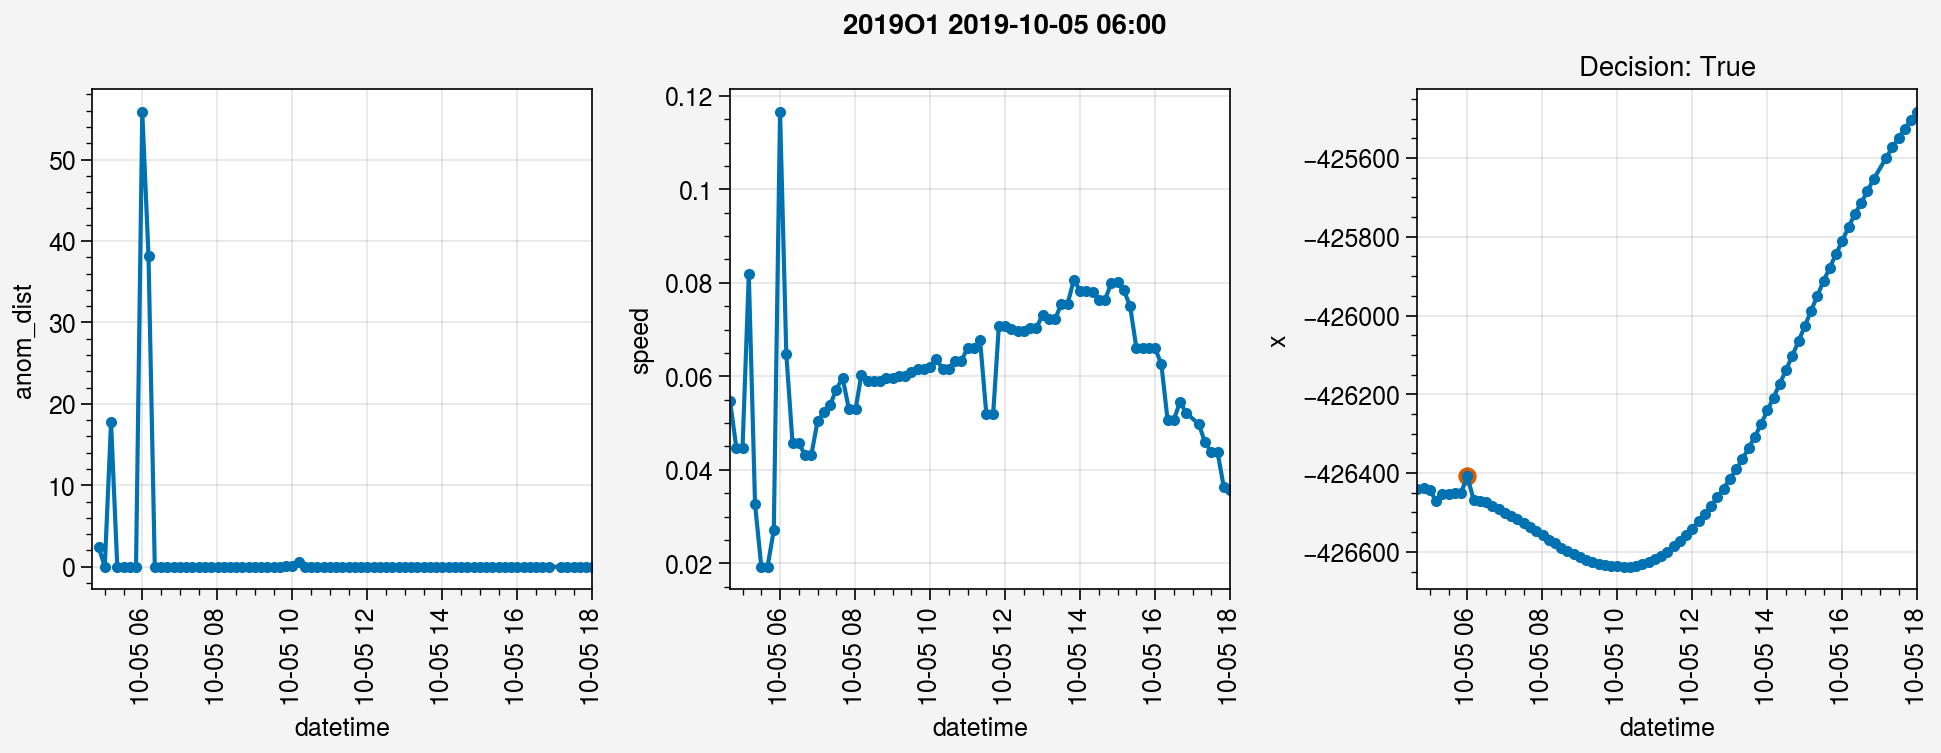

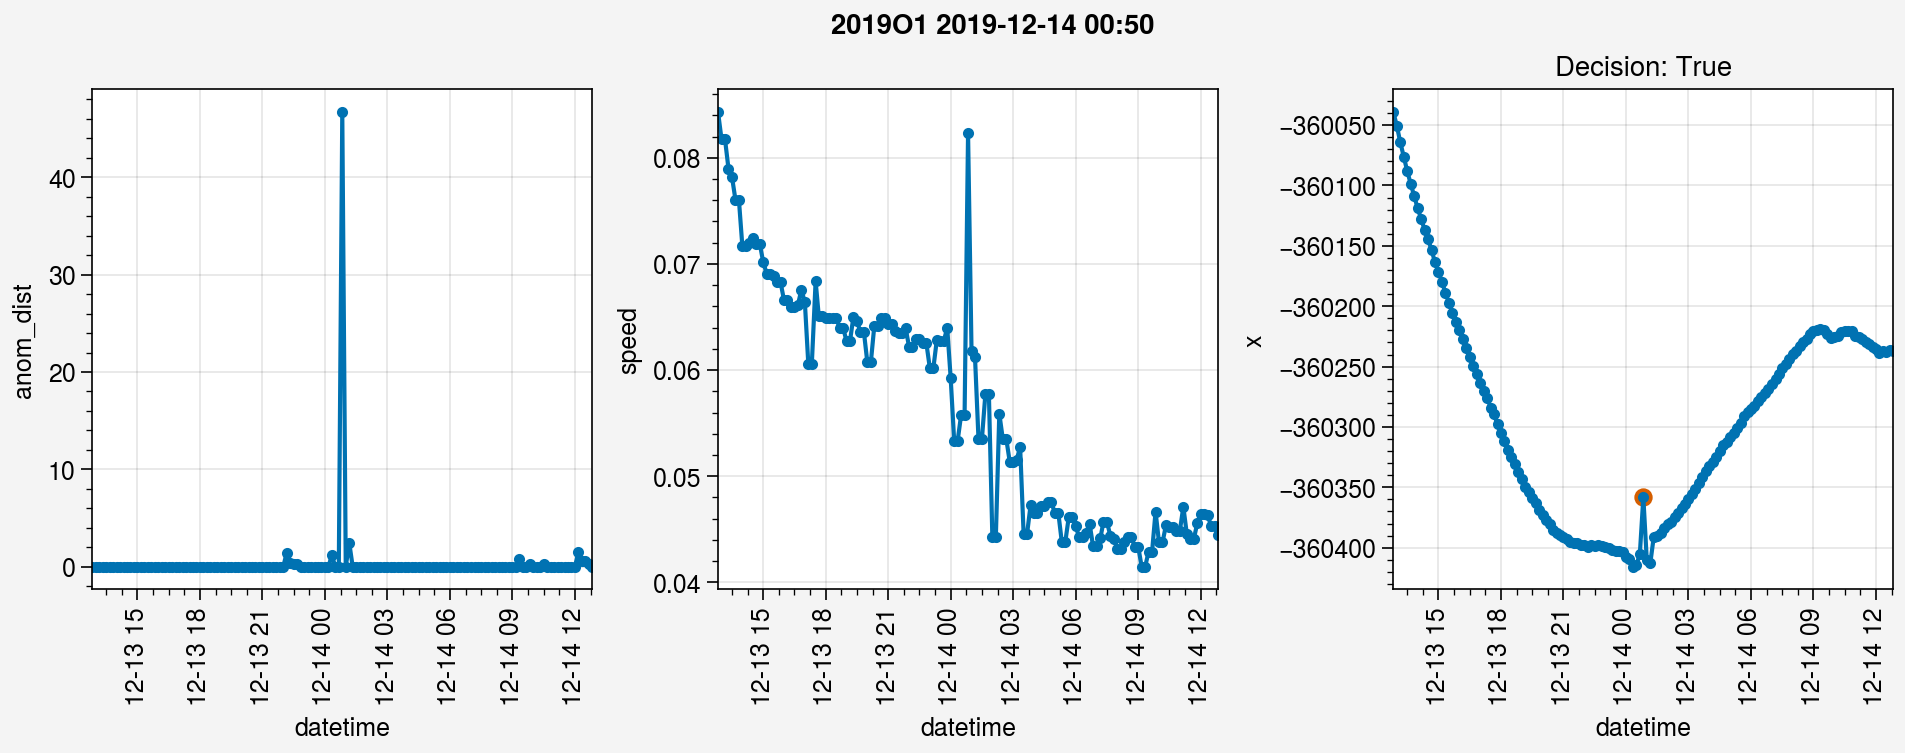

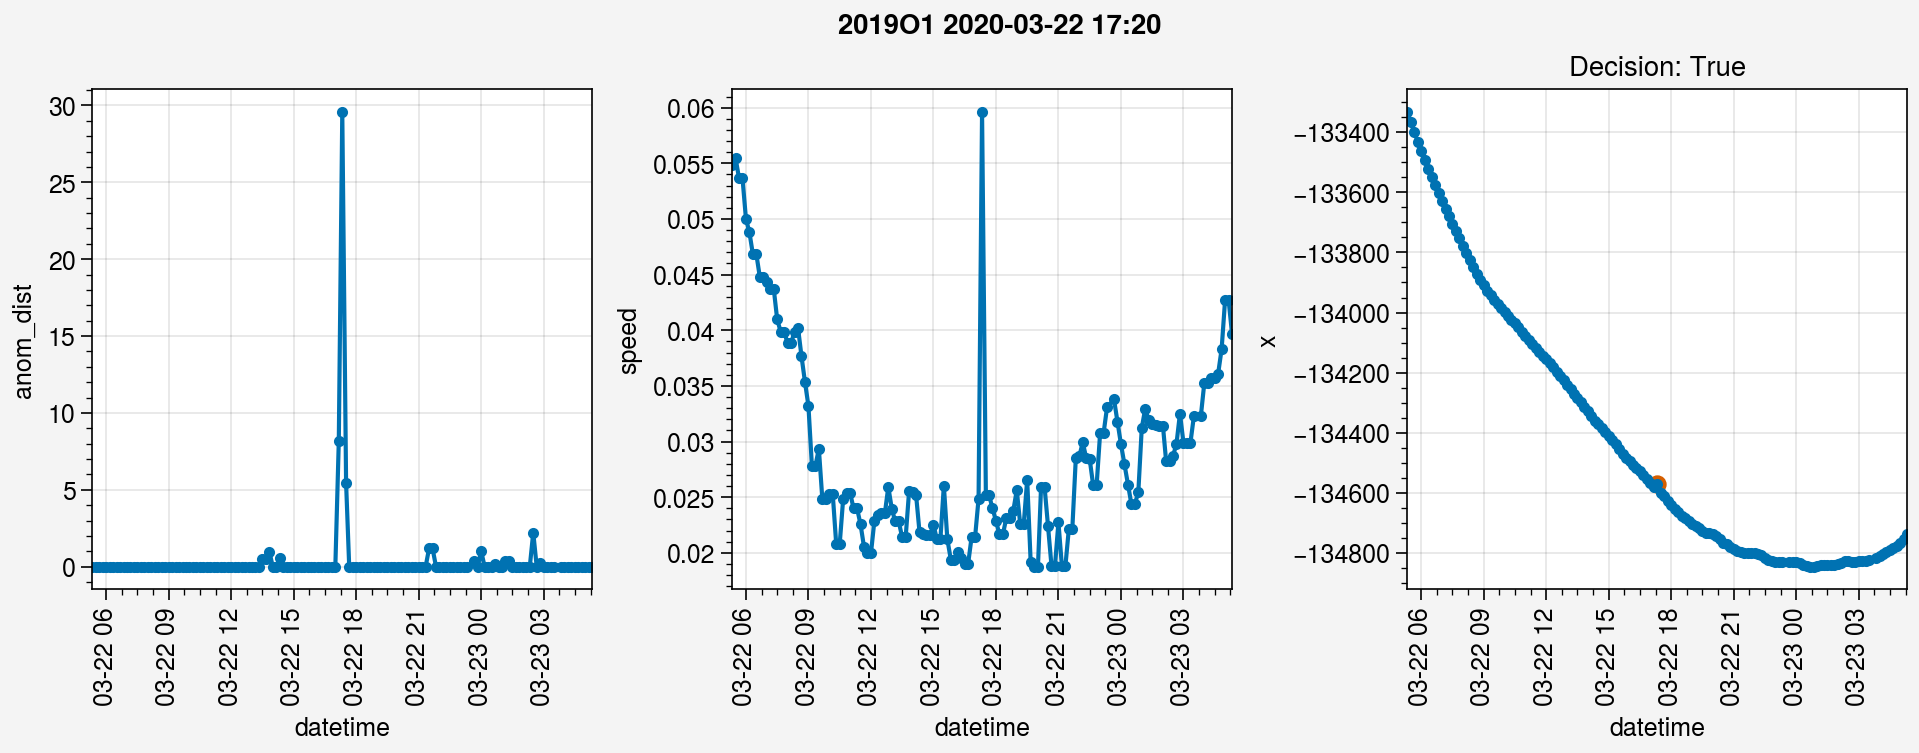

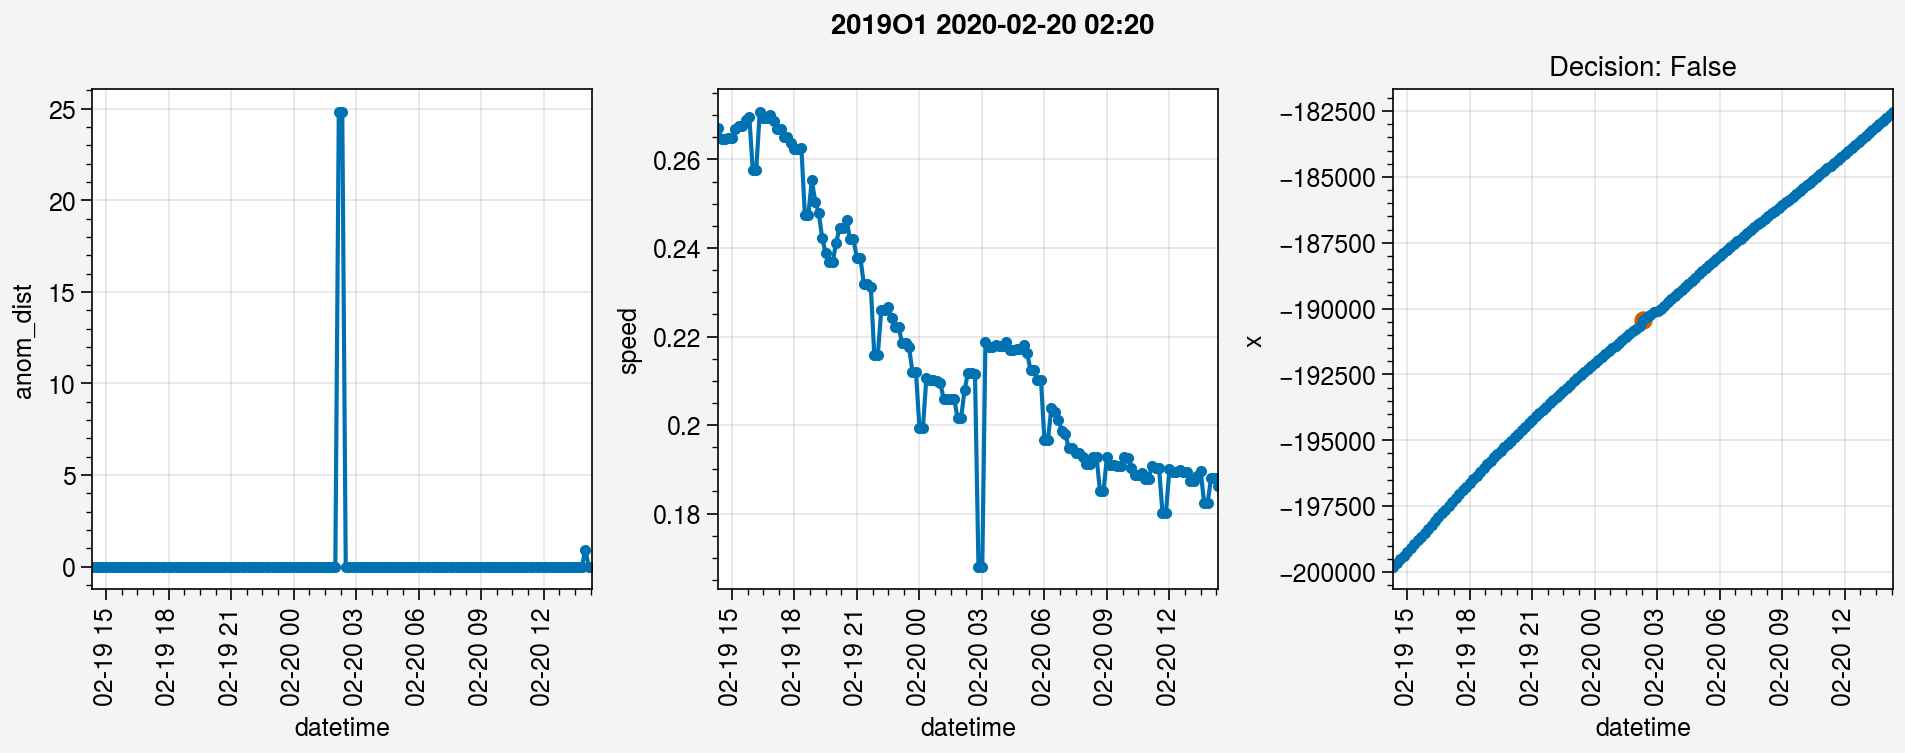

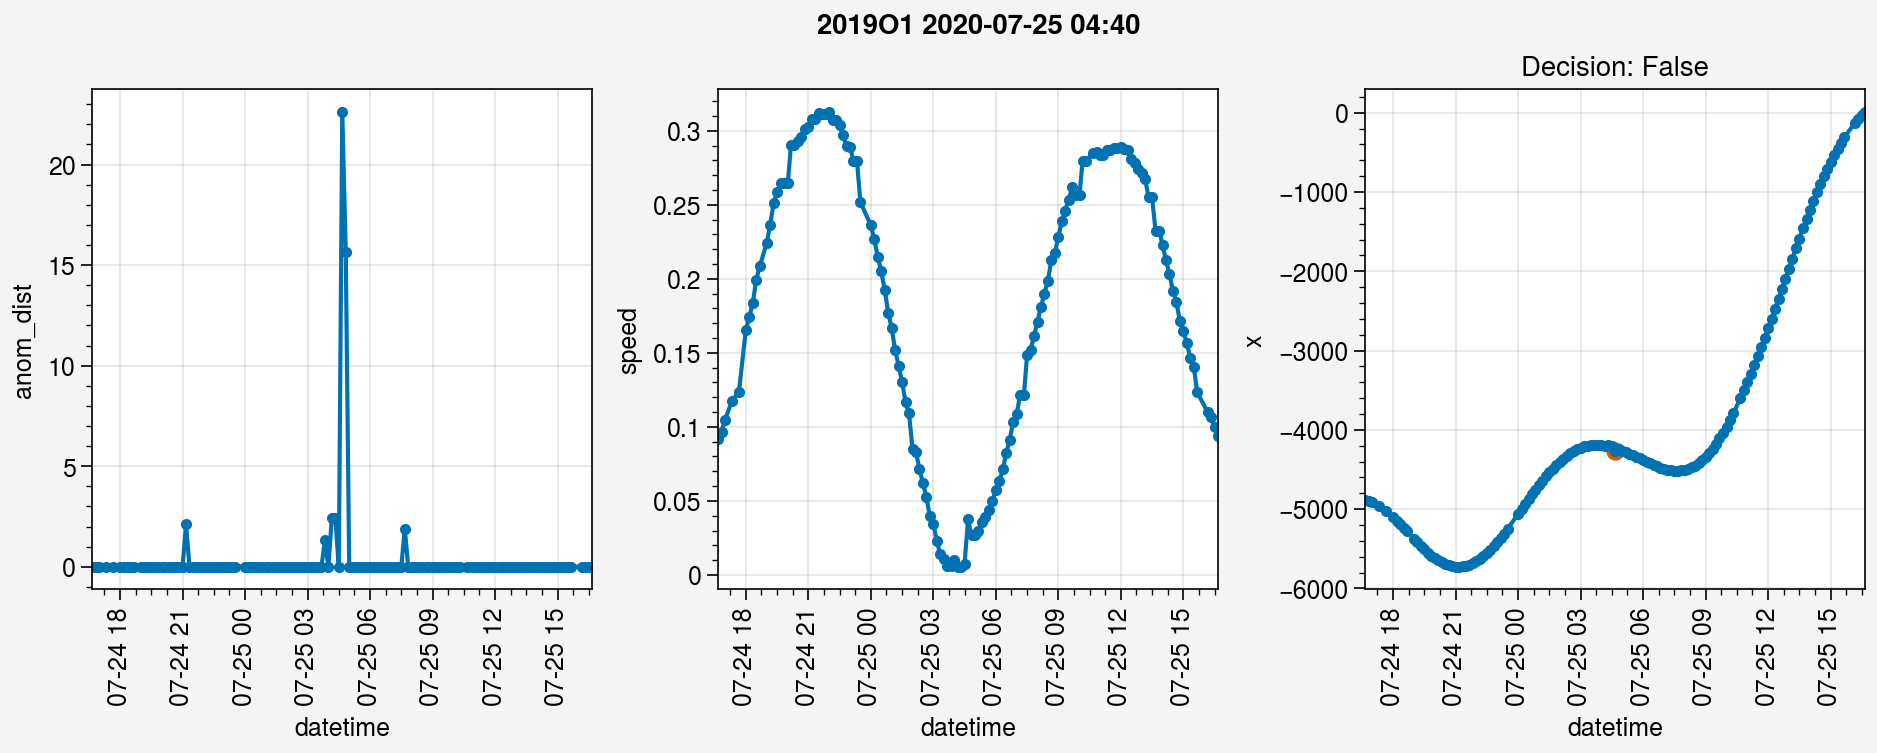

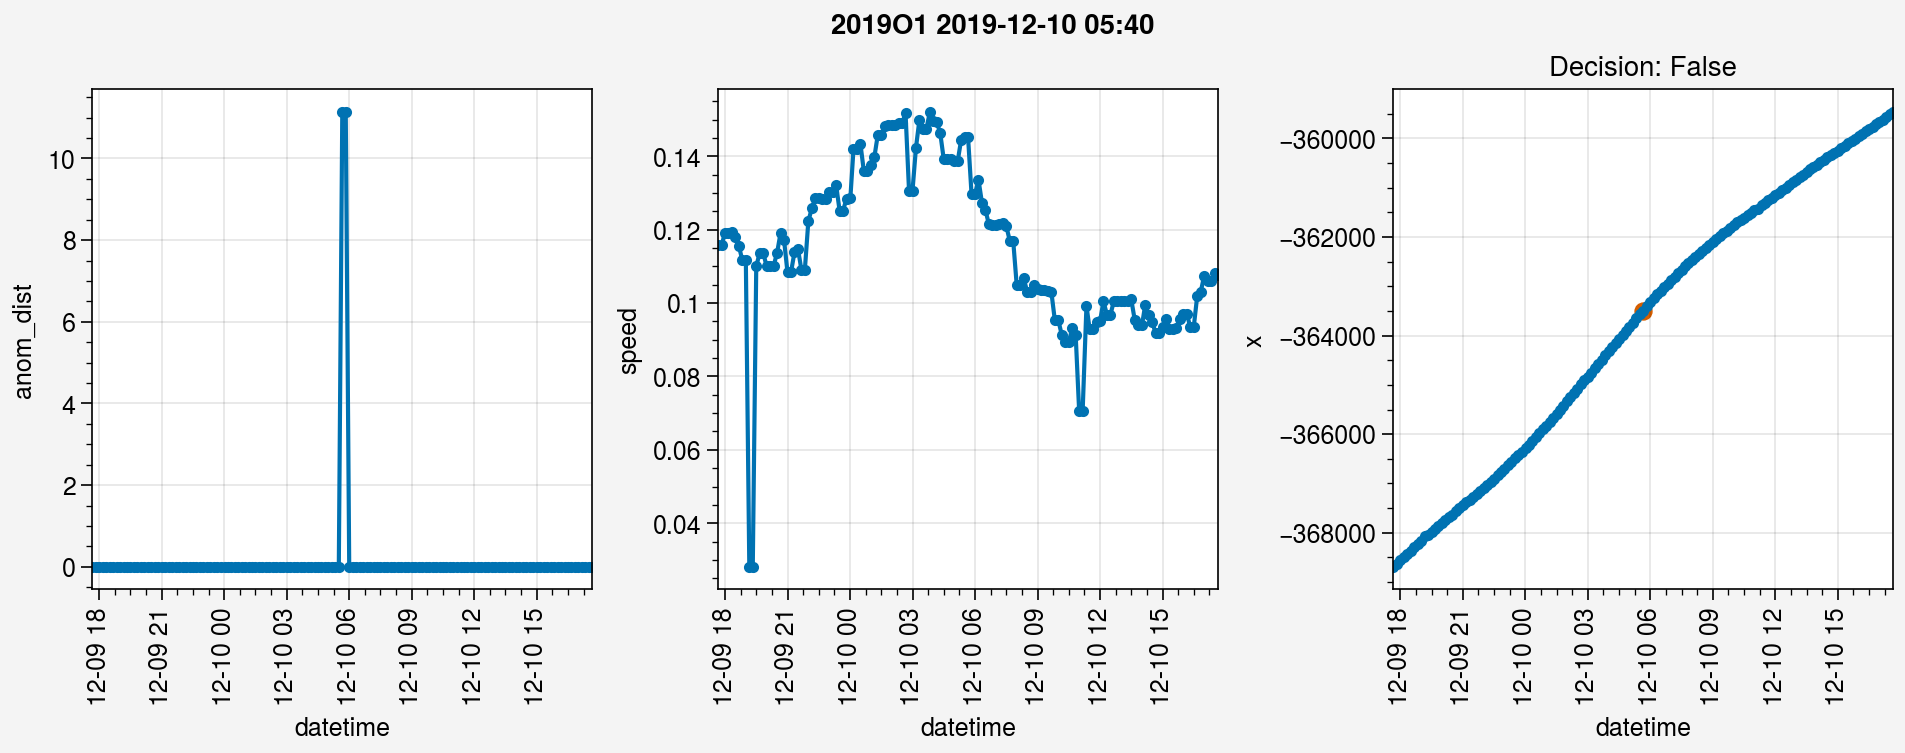

In [373]:
subset = outliers.decision # replace if checking other combinations of anom max, speed max, exceed thresh
for date in outliers.loc[subset].index:
    fig, ax= pplt.subplots(ncols=3, share=False)
    ax[0].plot(buoy_df.loc[slice(date-margin, date+margin), 'anom_dist'], marker='.')
    ax[1].plot(buoy_df.loc[slice(date-margin, date+margin), 'speed'], marker='.')
    ax[2].plot(buoy_df.loc[slice(date-margin, date+margin), 'x'], marker='.')
    ax.format(suptitle=buoy + ' ' + date.strftime('%Y-%m-%d %H:%M'))
    ax[2].format(title='Decision: ' + str(test_dates.loc[date, 'decision']))
    ax[2].scatter(date, buoy_df.loc[date, 'x'])

Process for identifying bad datapoints. A statistical model must be built. But this model must not be so stringent as to remove local extrema in the quest to remove single outlier points. It must also be flexible enough to handle data that have irregular reporting.

Assumptions  
At an outlier point,
- anom_dist will be a local maximum
- speed will be a local maximum
- replacing x,y with a cubic spline interpolatant results in a large change in position

To estimate the uncertainty in the cubic spline interpolant, for each buoy, I randomly select 1000 dates, calculate the spline interpolant, and measure the residual. For the buoys with less than 1000 observations, I use half the data. There's a clear (and expected) relationship between the 99th percentile of the error and the buoy frequency - the errors are larger with larger data gaps. It's for this reason that a single threshold doesn't work for the full dataset. 

TBD: identify periods with different frequencies, and apply the outlier finder individually on each.

1. Calculate anom_dist and sigma
    1. sigma estimated as sqrt of 2$*$mean(anom_dist s.t. anom_dist > 0)
    2. tbd: test assumption that the positive values of anom_dist are chi2 distributed
2. Beginning with max(anom_dist):
    1. Check if speed is a local maximum
    2. Calculate the difference between xhat, yhat and x, y
    3. If dist > threshold given the frequency, flag the point.
3. Continue until each data point with anom_dist $> 6*$sigma has been tested.

Where I left off: I'm evaluating whether it's necessary to check the max anom and max speed. It is doing pretty well for P142. Need to check for a sampling of other buoys too.

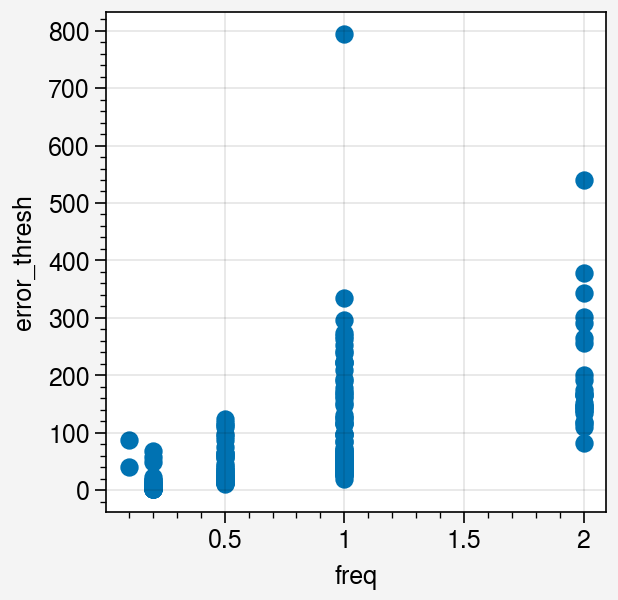

In [251]:
fig, ax = pplt.subplots()
ax.scatter(data_thresh.freq, data_thresh.error_thresh)

In [252]:
data_thresh.to_csv('../data/error_estimate_cubic_splines.csv')

In [254]:
data_thresh.idxmax()

freq            2019P142
error_thresh    2019P139
dtype: object

In [81]:
est_middle(date, buoy_df.loc[slice(date-margin, date+margin)], 'x', 'y')

array([-21322.87183869, 317859.8201724 ])

In [82]:
margin = pd.to_timedelta('24H')
test = [est_middle(date, buoy_df.loc[slice(date-margin, date+margin)], 'x', 'y') 
 for date in buoy_df.loc[timeslice].index]
test = pd.DataFrame(test, columns=['x', 'y'], index=buoy_df.loc[timeslice].index)

<a list of 1 Line2D objects>

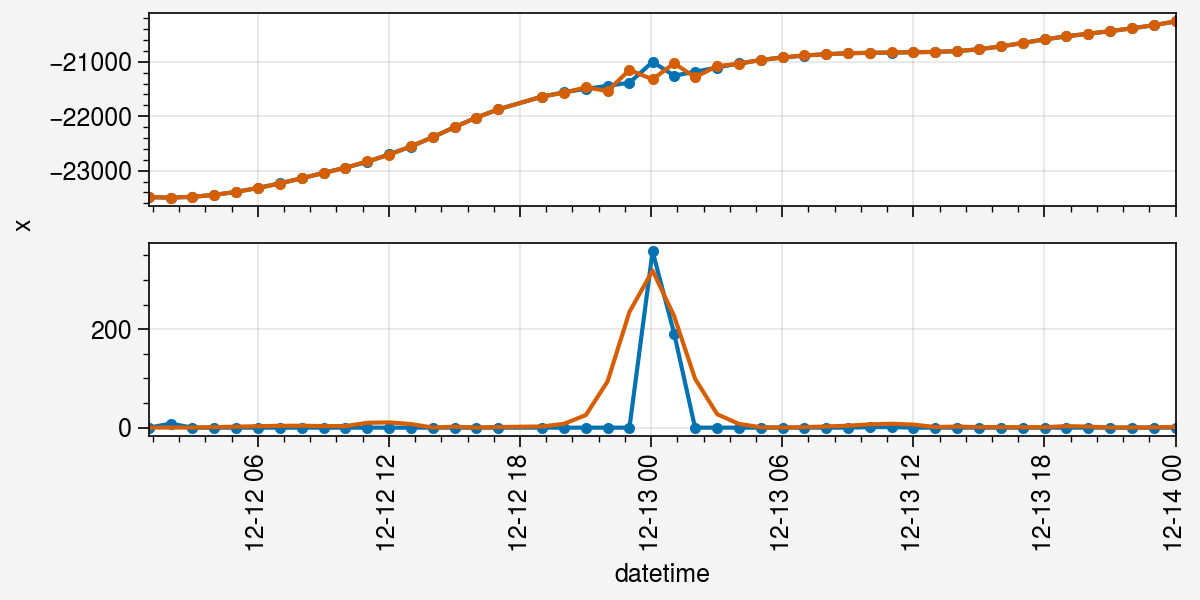

In [83]:
#timeslice = slice('2020-01-30', '2020-02-02')
fig, ax = pplt.subplots(width=6, height=3, nrows=2)
ax[0].plot(buoy_df.loc[timeslice]['x'], marker='.')
ax[0].plot(test['x'], marker='.')
ax[1].plot(buoy_df.loc[timeslice]['anom_dist'], marker='.')
ax[1].plot(np.abs(buoy_df.loc[timeslice]['x'] - test['x']))

In [ ]:
# Identify potential error points


In [219]:
dates = buoy_df.index[buoy_df.flag_position_spline==1][0:10]

DatetimeIndex(['2021-01-08 15:04:03', '2021-01-08 16:04:02',
               '2021-01-08 19:03:59', '2021-01-08 20:04:01',
               '2021-02-10 04:03:59', '2021-02-10 05:04:01',
               '2021-02-18 08:04:01', '2021-03-05 12:04:03',
               '2021-03-05 13:04:04', '2021-03-30 08:04:01',
               '2021-04-09 12:04:03'],
              dtype='datetime64[ns]', name='datetime', freq=None)


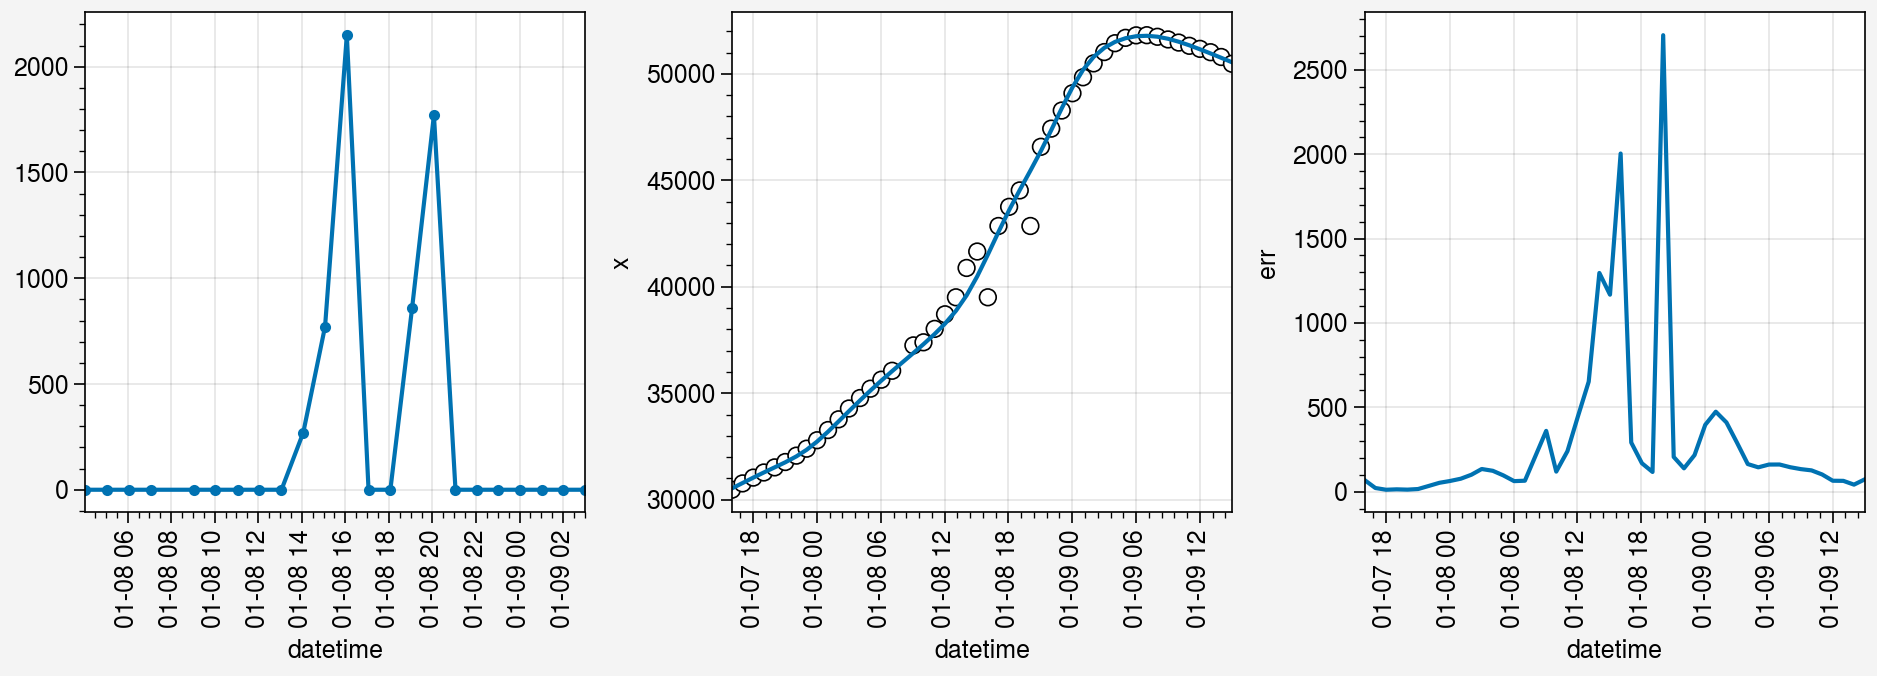

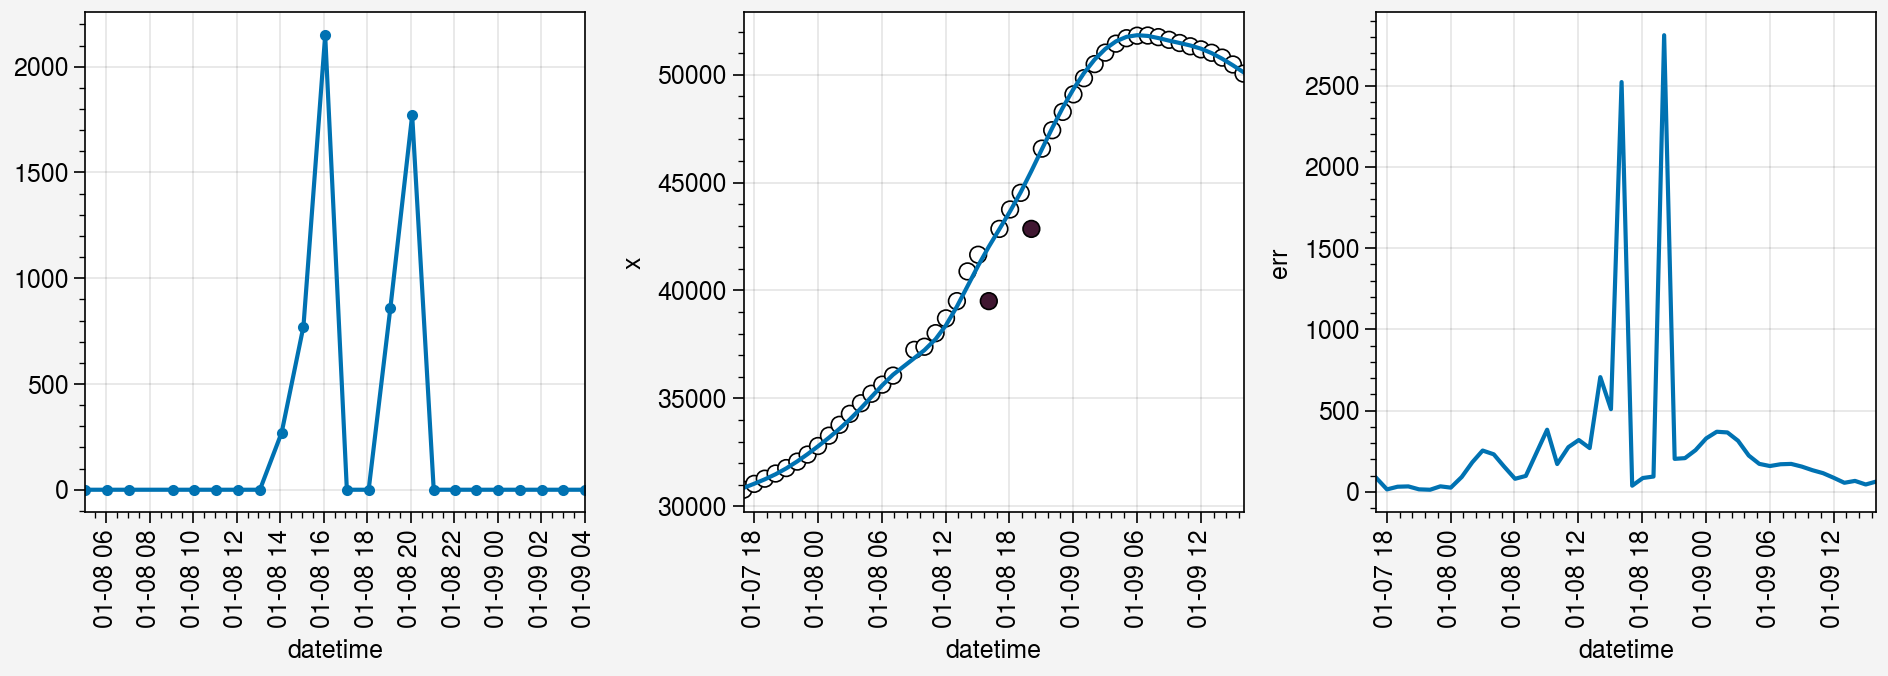

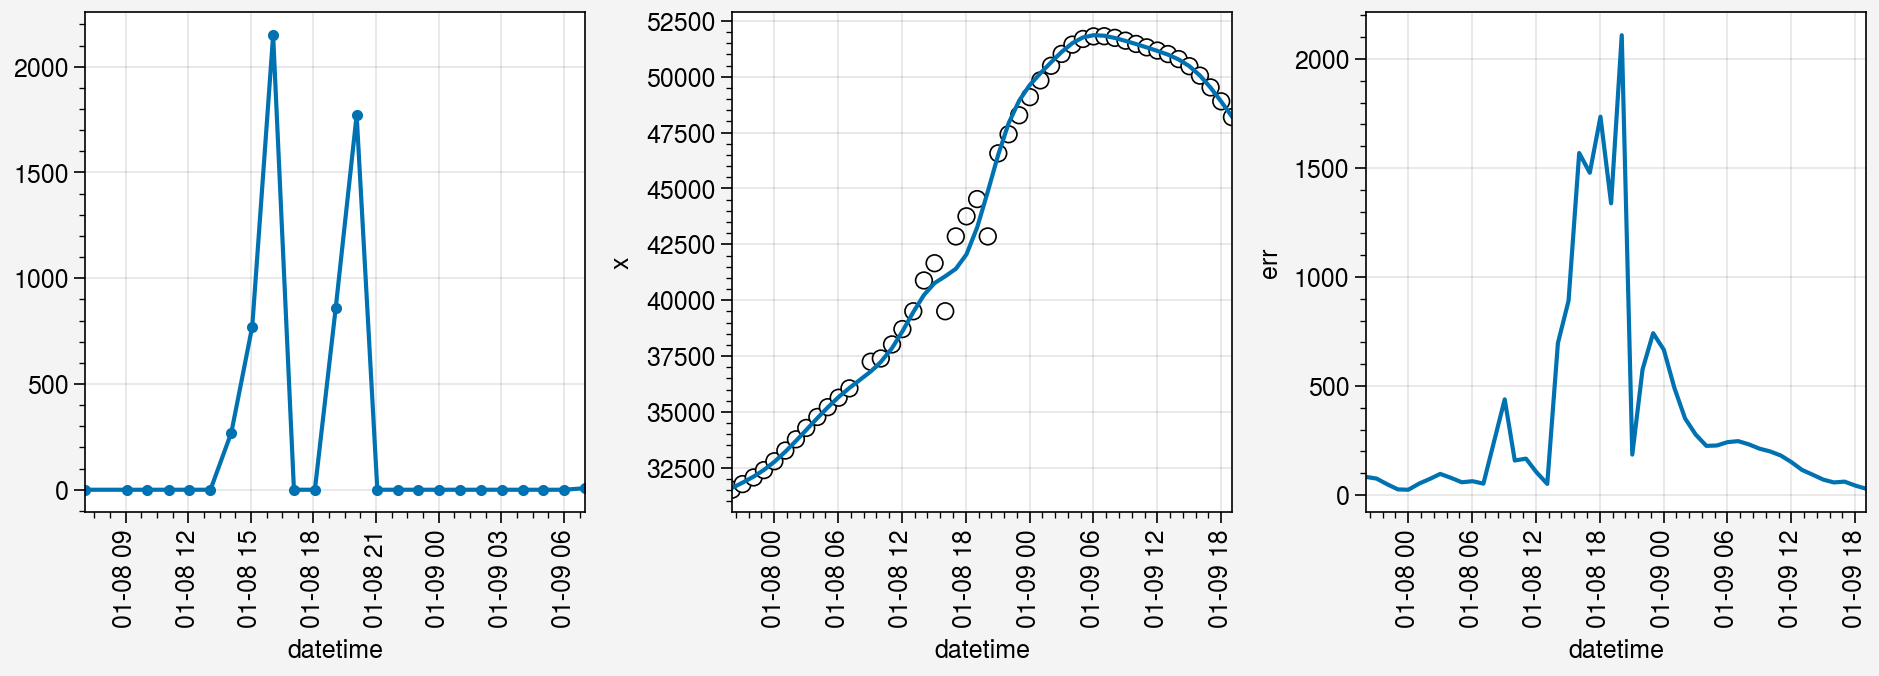

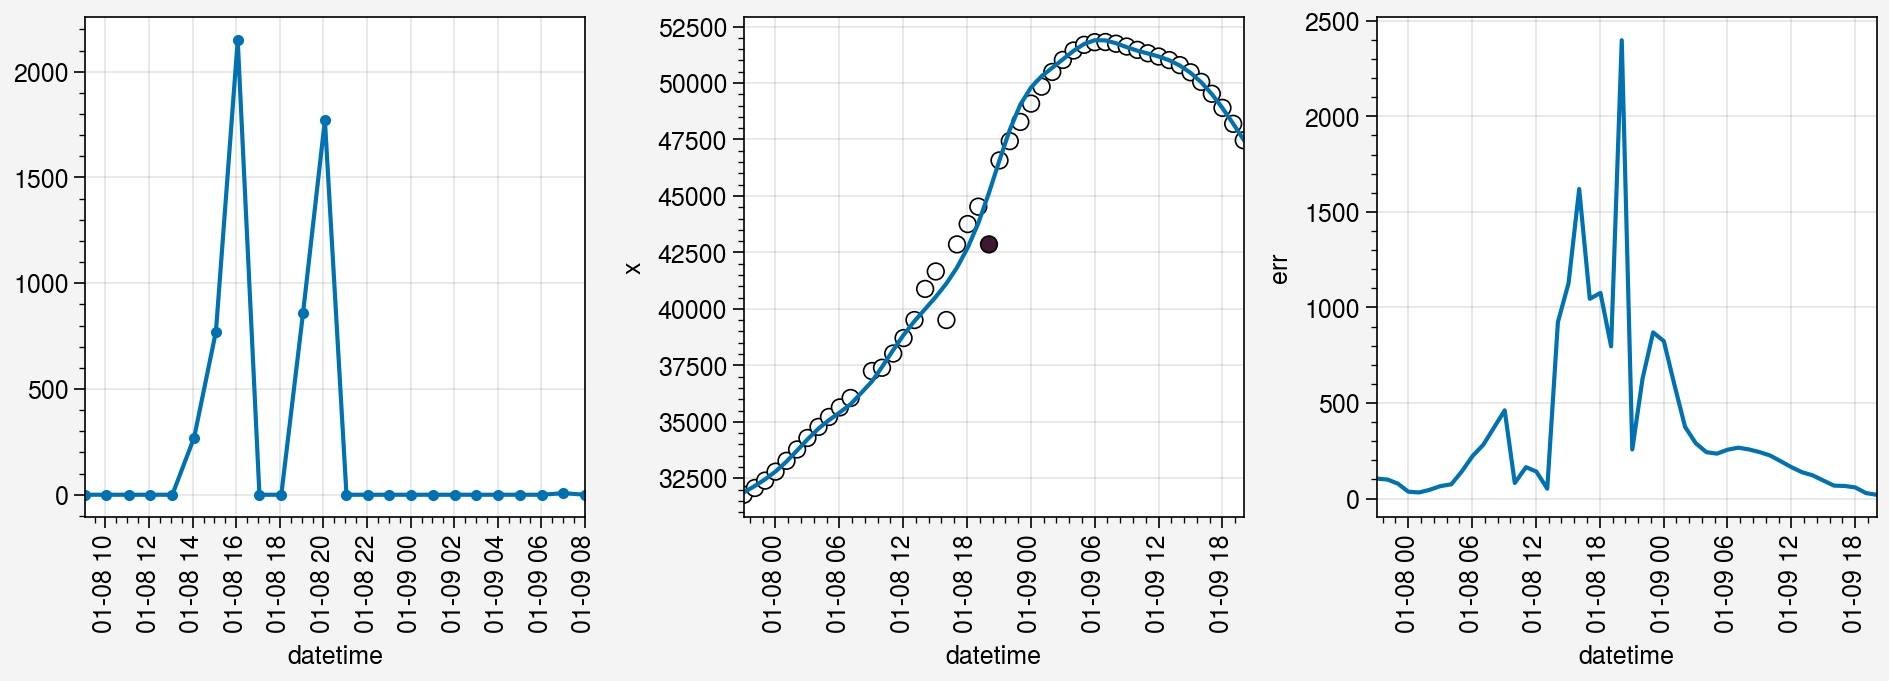

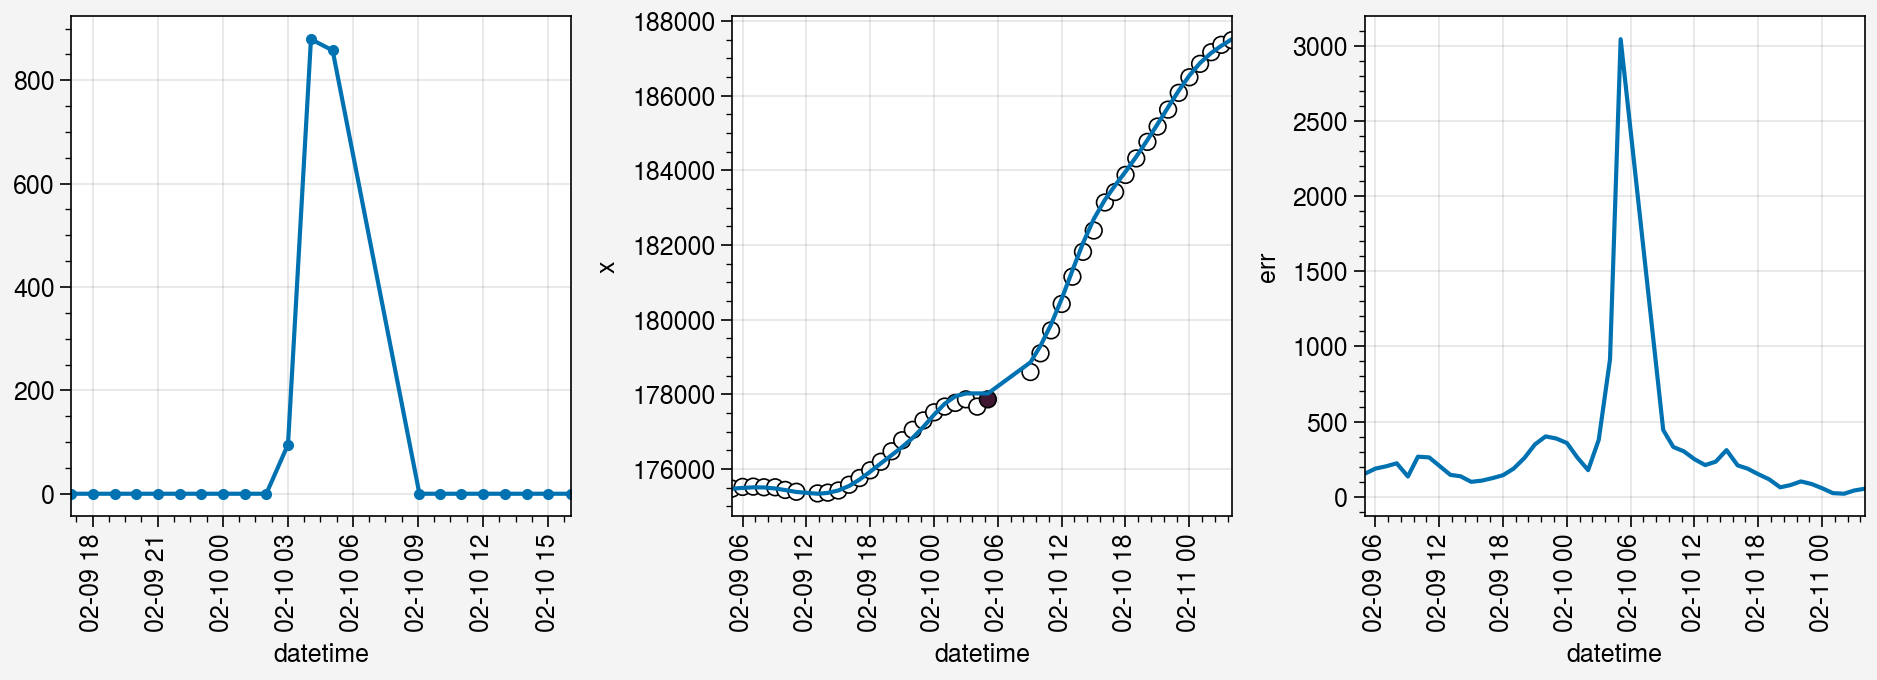

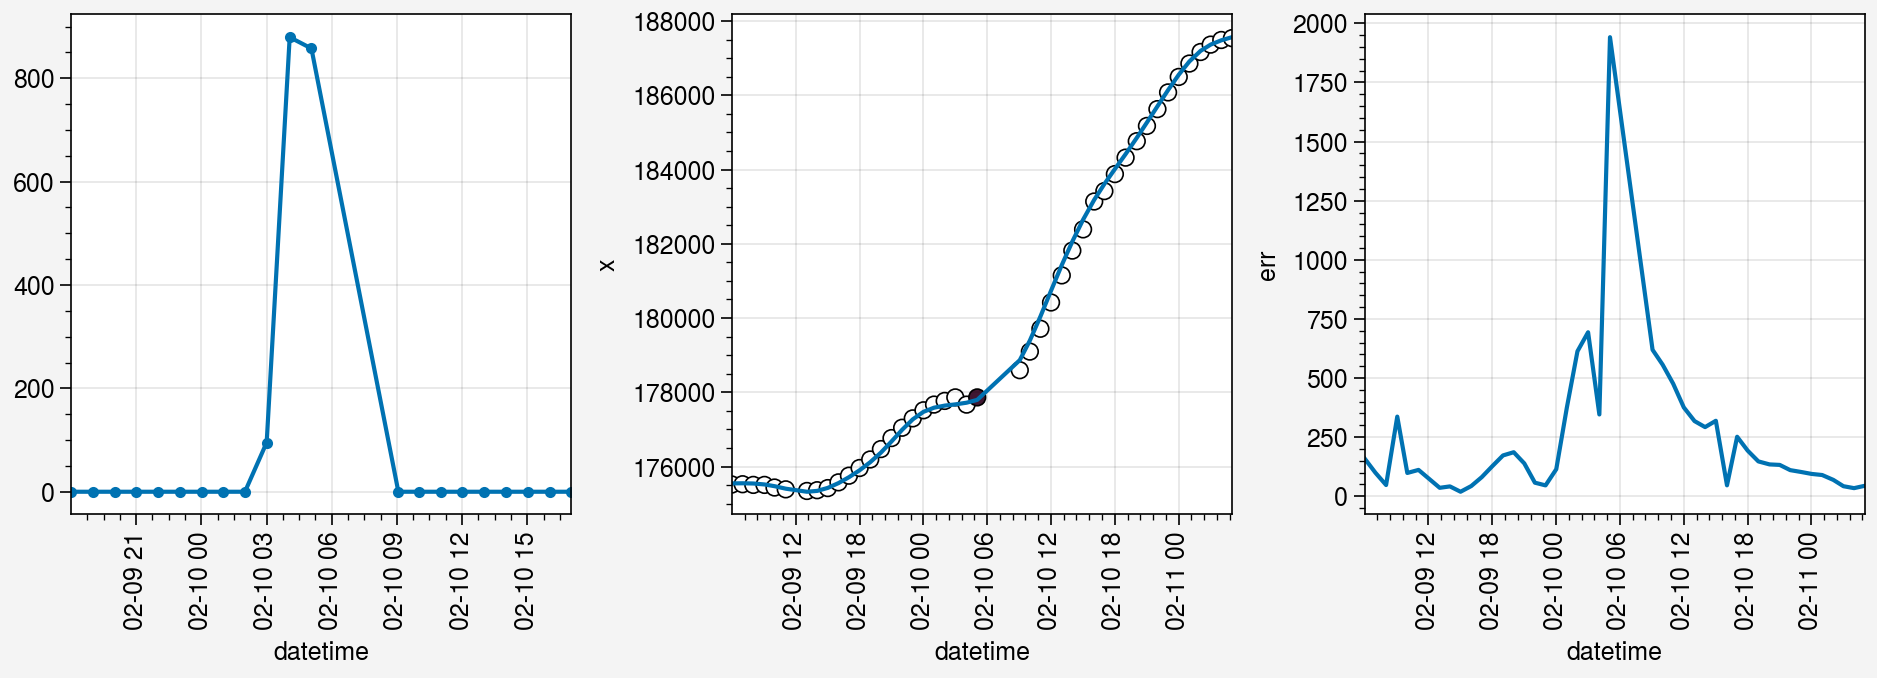

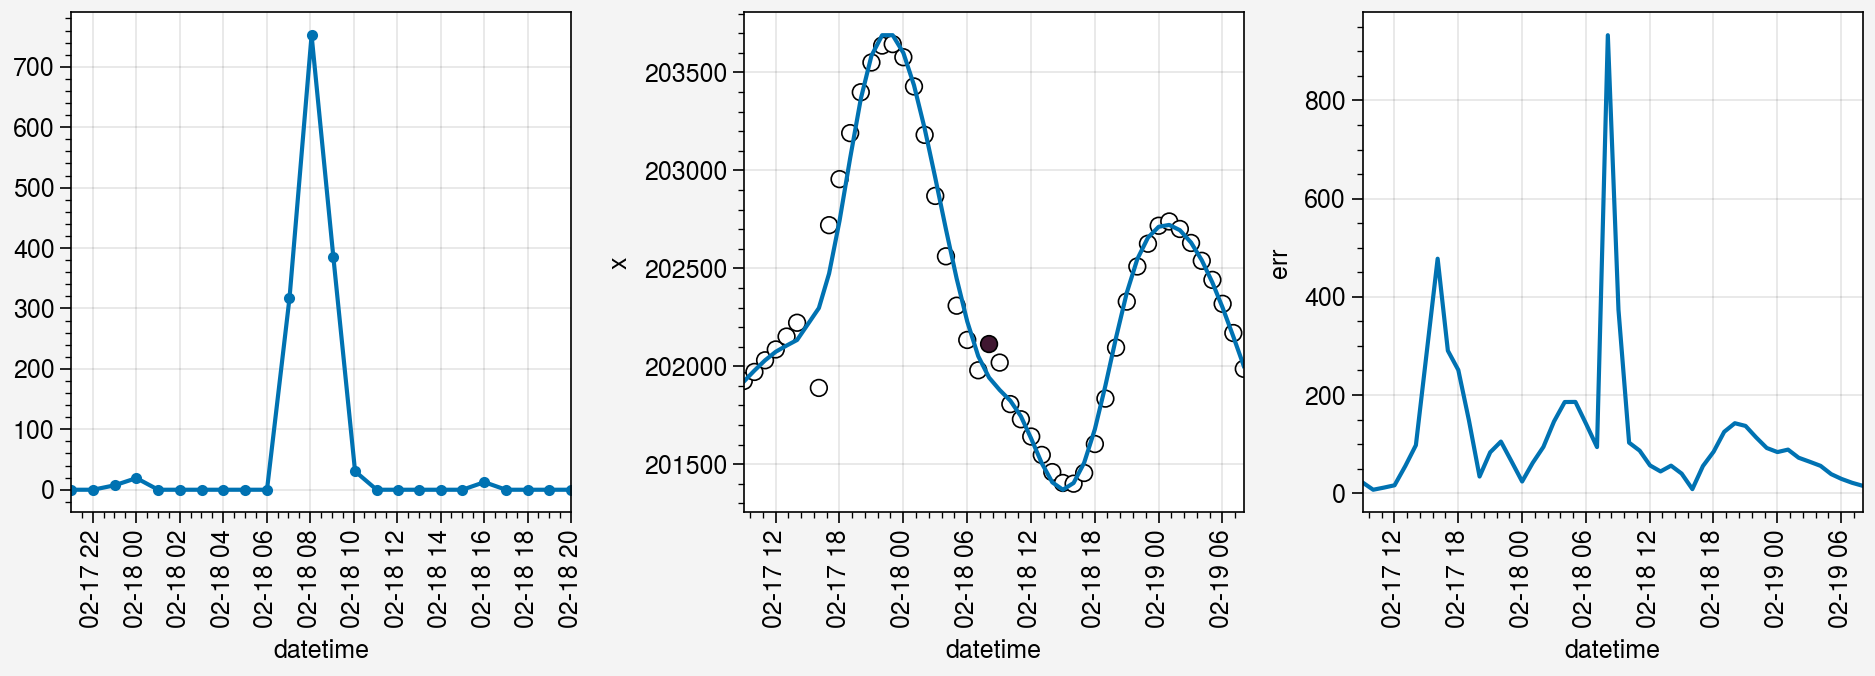

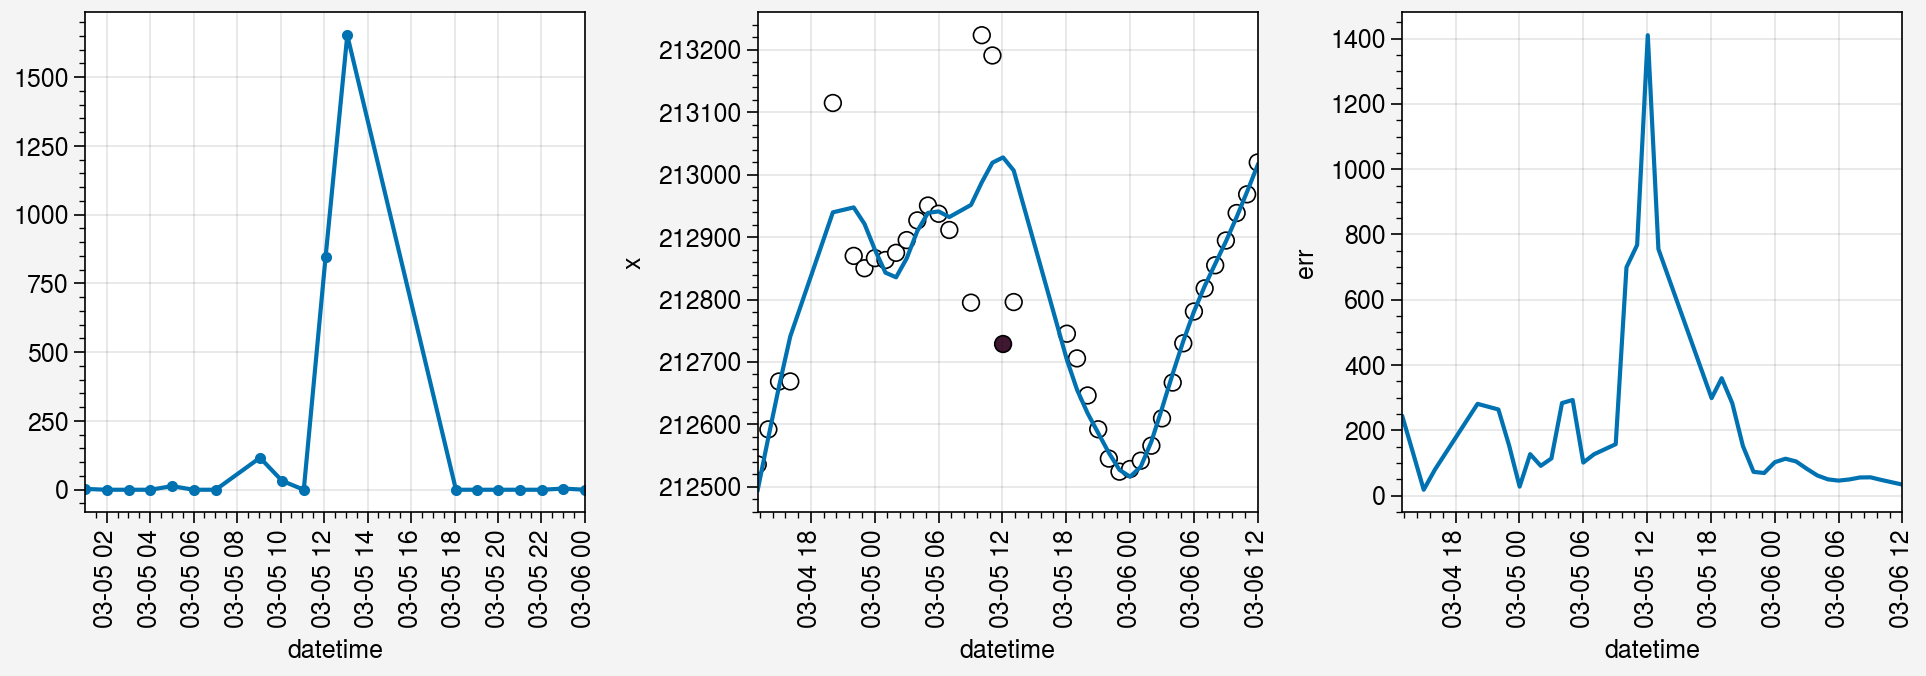

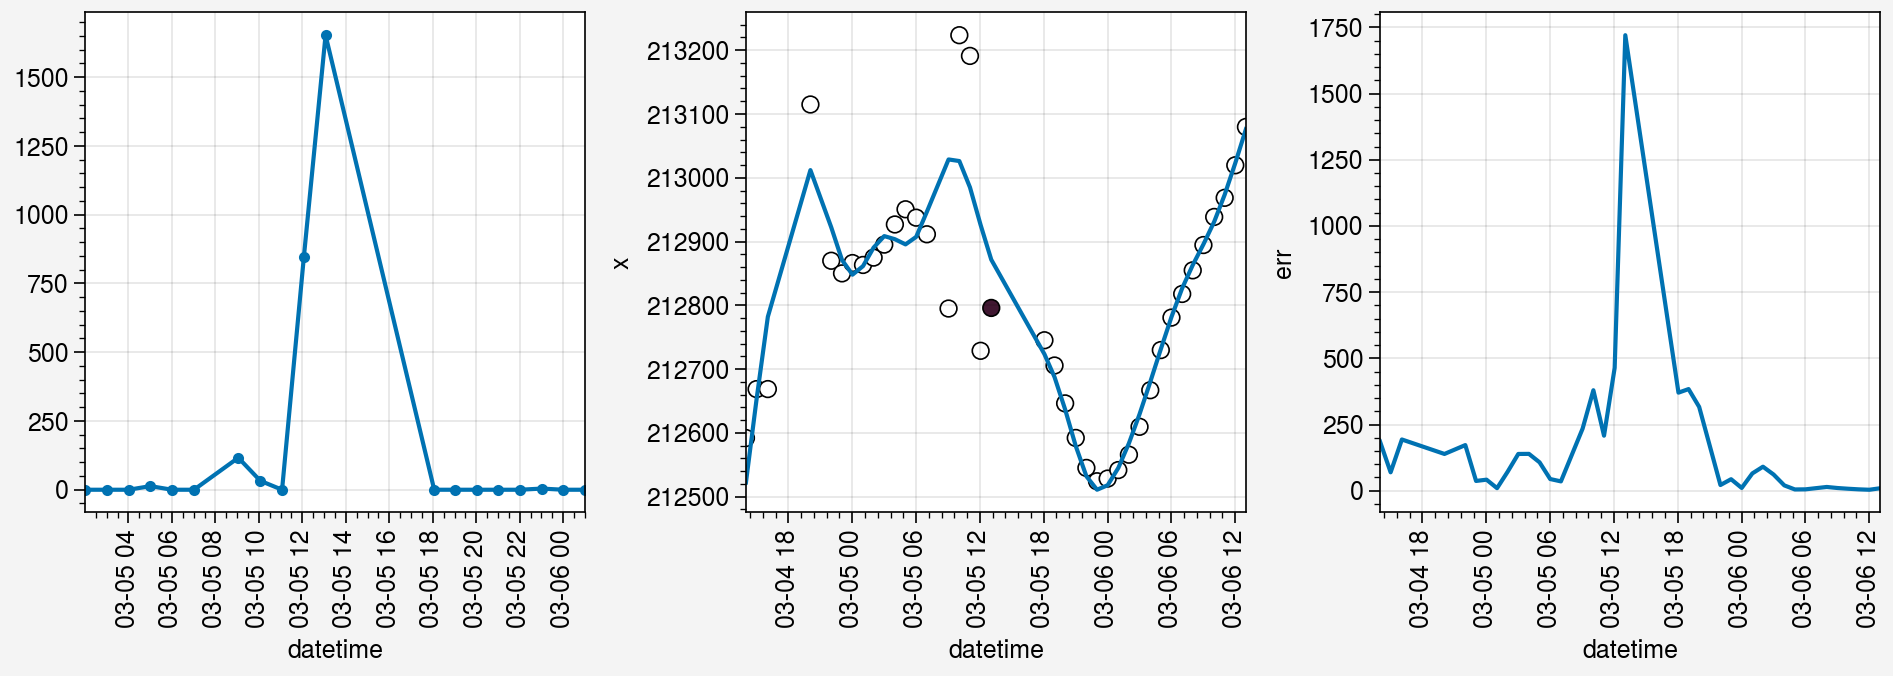

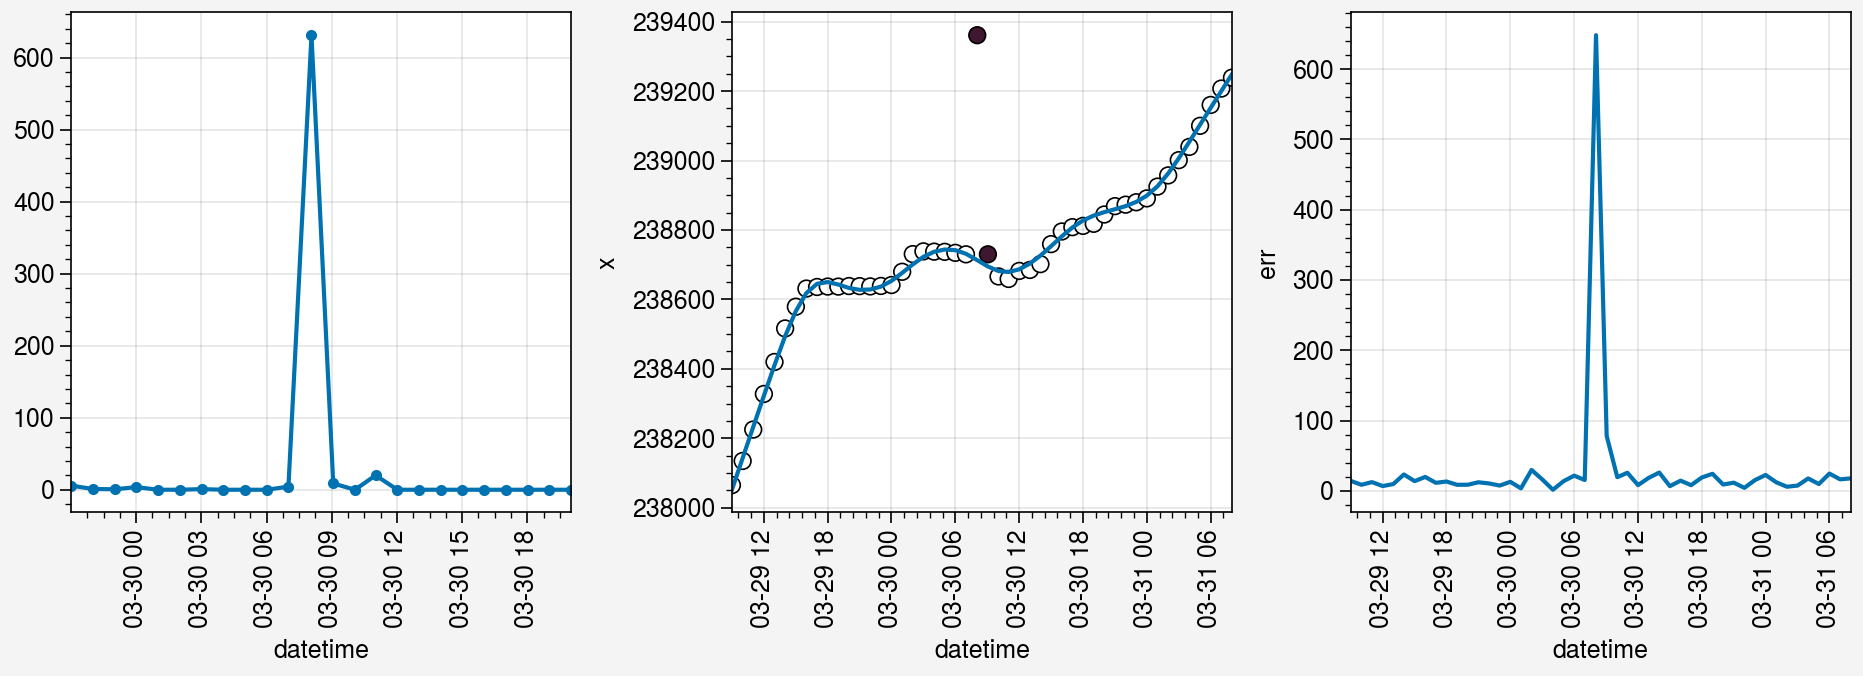

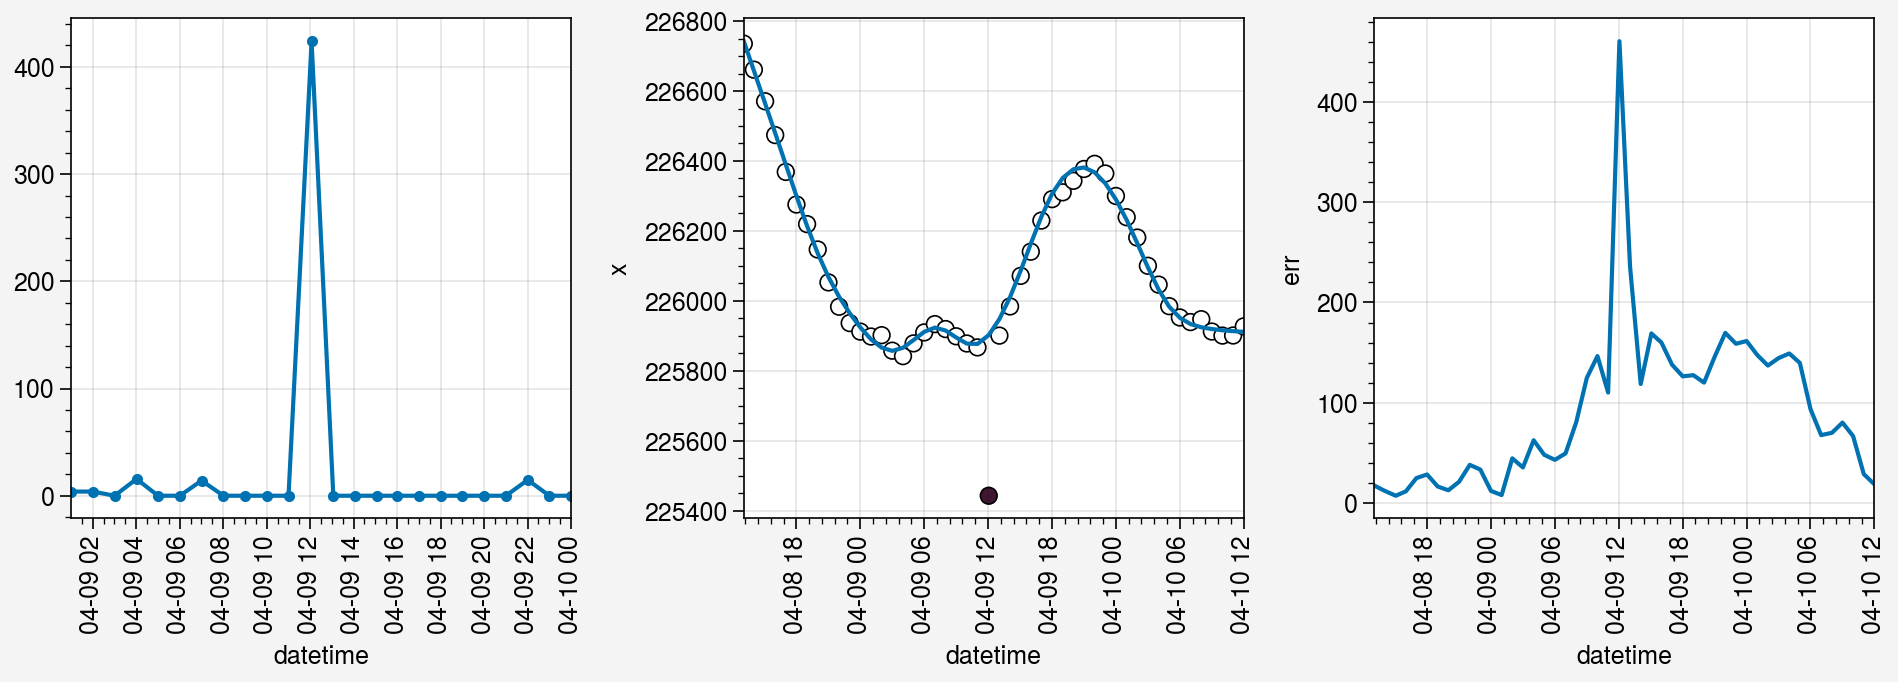

In [191]:
date = test_df.loc[2, 'date']
margin = pd.to_timedelta('12H')
buoy = test_df.loc[2, 'buoy_id']
anom_x = buoy_data[buoy].x_anom
anom_y = buoy_data[buoy].y_anom
anom = np.sqrt(anom_x**2 + anom_y**2)
buoy_data[buoy]['flag_position_spline'] = 0
print(anom[anom > 400].index)
for date in anom[anom > 400].index:
    test = clean.test_point(date, buoy_data[buoy],
                            xvar='x', yvar='y', df=13, fit_window='24H', sigma=6)
    if np.any(test.flag.notnull()):
        buoy_data[buoy].loc[test.loc[test.flag.notnull()].index, 'flag_position_spline'] = 1
                            
    fig, ax= pplt.subplots(ncols=3, share=False)
    ax[0].plot(anom.loc[slice(date-margin, date+margin)], marker='.')
    ax[1].scatter(test.x, c=test.flag.astype(int), edgecolor='k')
    ax[1].plot(test.x_hat)
    ax[2].plot(test.err)

In [41]:
fix_buoys = ['2019O3', '2019O4', '2019P102', '2019P103', '2019P105', '2019P138',
             '2019P140', '2019P142', '2019P183', '2019P203', '2019P88', '2019P91', '2019P196',
             '2019R9', '2019S96', '2019V4', '2020E3', '2020P219', '2020P220', '2020T73']
fix_buoys.sort()



In [75]:
t0 = pd.to_datetime('2019-11-01 00:00')
t = (buoy_data[buoy].index - t0).total_seconds()
x = buoy_data[buoy].longitude
y = buoy_data[buoy].latitude
# fraction used: it'd be better to have a moving window.
xhat = lowess(x, t, frac=12/len(t))

2019O3


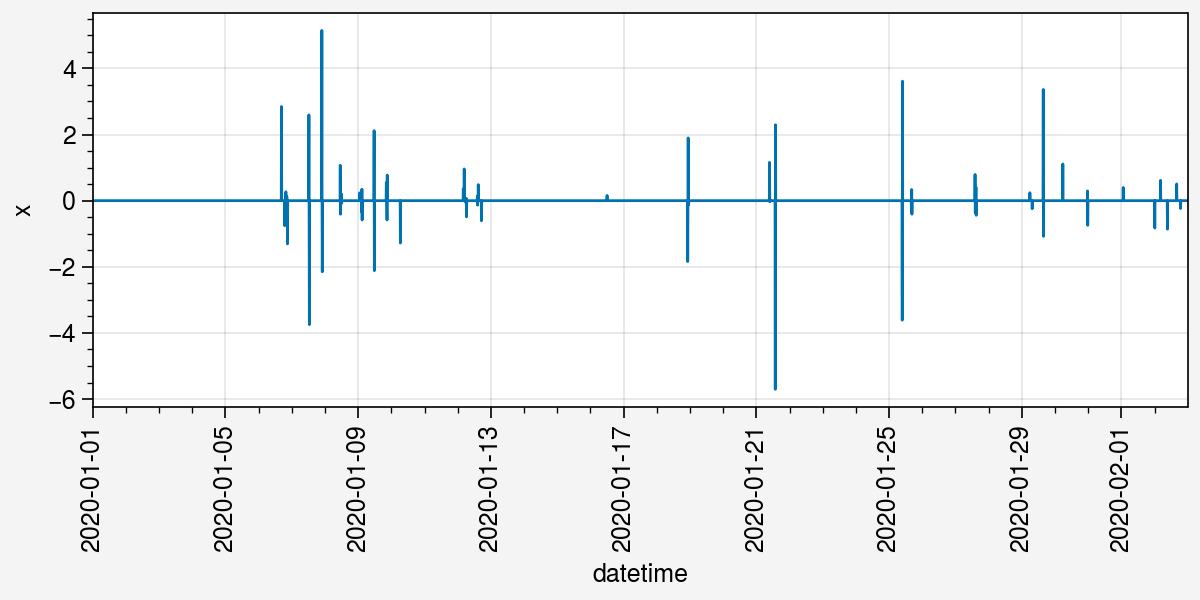

In [90]:
fig, ax = pplt.subplots(width=6, height=3)
timeslice = slice('2020-01-01', '2020-02-02')
for buoy in ['2019O3']:
    buoy_data[buoy]['flag'] = buoy_data[buoy].flag_date | buoy_data[buoy].flag_gaps
    speed = buoy_data[buoy].where(buoy_data[buoy].flag != 1)['x']
    anomaly = speed - speed.rolling(3, center=True, min_periods=3).median()
    ax.plot(anomaly.loc[timeslice], lw=1, marker='')
    if np.any(buoy_data[buoy].loc[timeslice].speed > 0.4):
        print(buoy)
#ax.format(ylim=(0, 0.6))

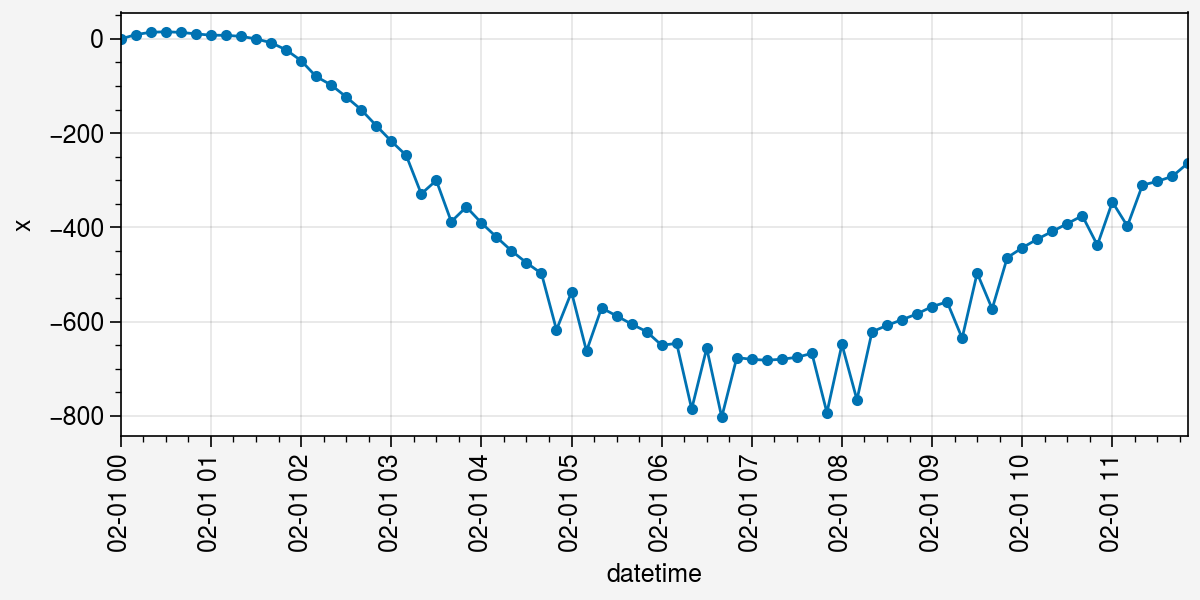

In [71]:
fig, ax = pplt.subplots(width=6, height=3)
timeslice = slice('2020-02-01', '2020-02-01 12:00')
for buoy in ['2019O3']:
    buoy_data[buoy]['flag'] = buoy_data[buoy].flag_date | buoy_data[buoy].flag_gaps
    posy = buoy_data[buoy].where(buoy_data[buoy].flag != 1)['y'].loc[timeslice]
    posx = buoy_data[buoy].where(buoy_data[buoy].flag != 1)['x'].loc[timeslice]    
    ax.plot(posx-posx.rolling('1H').median(), lw=1, marker='.')
#    if np.any(buoy_data[buoy].loc[timeslice].speed > 0.4):
#        print(buoy)
#ax.format(ylim=(0, 0.6))

<a list of 1 Line2D objects>

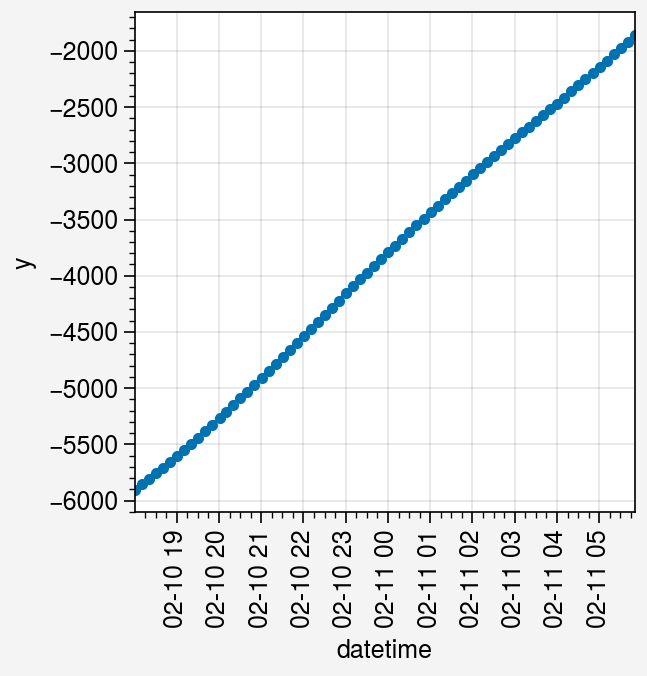

In [282]:
# Question: would interpolation with a cubic spline be faster than the check_splines method?
fig, ax = pplt.subplots()
date = pd.to_datetime('2020-02-11 00:00')
margin = pd.to_timedelta('6H')
ax.plot(#buoy_data['2019P103'].loc[slice(date-margin, date+margin)].u,
        buoy_data['2019P103'].loc[slice(date-margin, date+margin)].y, marker='.')

Removing data points with unphysical reported speeds

Problem: difficult to identify problem data points in a consistent way since the buoy data are not consistent. Tried lots of different things to clean the data, with some progress and some recurring setbacks.

Plan: One month at a time, identify buoys with clear problems

Potentially make season and latitude dependent speed thresholds
(winter: 

Potentially frequency dependent speed anomaly thresholds

In [173]:
for buoy in buoy_data:
    fwd_speed = clean.compute_speed(buoy_data[buoy].copy(), date_index=True, difference='forward')   
    bwd_speed = clean.compute_speed(buoy_data[buoy].copy(), date_index=True, difference='backward')
    speed = pd.DataFrame({'b': bwd_speed['speed'], 'f': fwd_speed['speed']}).min(axis=1)
    anomaly = speed - speed.rolling('1D', center=True, min_periods=6).mean()
    buoy_data[buoy]['flag_speed'] = anomaly > 1


In [196]:
for buoy in buoy_data:
    if buoy_data[buoy].flag_speed.sum() > 0:
        print(buoy, buoy_data[buoy].flag_speed.sum())

2019P105 2
2019P119 22
2019P151 1
2019P203 1
2019P206 1
2019R9 1
2019T70 1
2019V4 1
2020O10 7
2020P218 1
2020P225 1


In [197]:
timeslice=slice('2021-02-01', '2021-05-01')
buoy = '2019P105'


In [193]:
flagged

DatetimeIndex(['2019-12-01 15:13:59', '2019-12-06 07:10:36'], dtype='datetime64[ns]', name='datetime', freq=None)

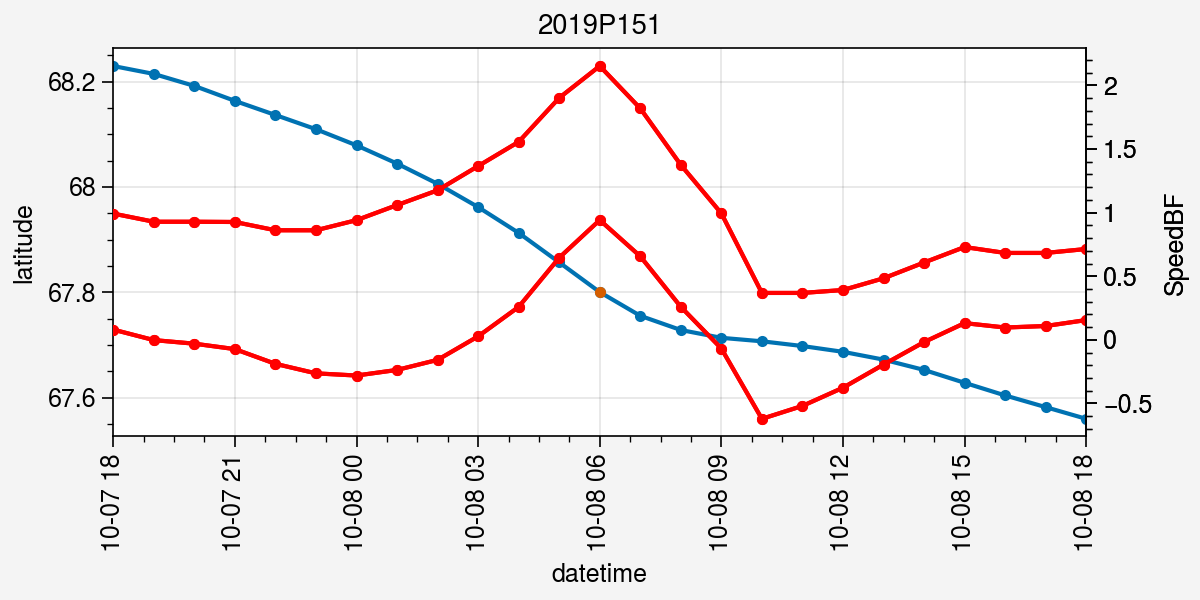

In [205]:
buoy = '2019P151'
margin = pd.to_timedelta('12H')
buoy_df = buoy_data[buoy].copy()
fwd_speed = clean.compute_speed(buoy_data[buoy].copy(), date_index=True, difference='forward')   
bwd_speed = clean.compute_speed(buoy_data[buoy].copy(), date_index=True, difference='backward')
speed = pd.DataFrame({'b': bwd_speed['speed'], 'f': fwd_speed['speed']}).min(axis=1)
anomaly = speed - speed.rolling('12H', center=True, min_periods=6).mean()

flagged = buoy_df.loc[(buoy_df.flag_speed==1)].index
if len(flagged) == 1:
    date = pd.to_datetime(flagged[0])
else:
    date = pd.to_datetime(flagged[1])

fig, ax = pplt.subplots(width=6, height=3)

buoy_df = buoy_df.loc[slice(date-margin, date+margin)]
threshold = buoy_df.rolling('12H', center=True).latitude.count()
ax.plot(buoy_df.latitude, marker='.')
ax.plot(buoy_df.where(buoy_df.flag_speed==1).latitude, marker='.', lw=0)
ax.format(title=buoy)

ax2 = ax.twinx()
ax2.plot(anomaly.loc[slice(date-margin, date+margin)], color='r', marker='.')
ax2.plot(speed.loc[slice(date-margin, date+margin)], color='r', marker='.')


ax2.format(ylabel='SpeedBF')

In [206]:

# Step one: compute dist_from_median_uv, dist_from_median_xy, distance to closest point
for buoy in buoy_data:
    data = buoy_data[buoy]
    fwd_speed = clean.compute_speed(data.copy(), date_index=True, difference='forward')   
    bwd_speed = clean.compute_speed(data.copy(), date_index=True, difference='backward')
    speed = pd.DataFrame({'b': bwd_speed['speed'], 'f': fwd_speed['speed']}).min(axis=1)
    u = pd.DataFrame({'b': np.abs(bwd_speed['u']), 'f': np.abs(fwd_speed['u'])}).min(axis=1)
    v = pd.DataFrame({'b': np.abs(bwd_speed['v']), 'f': np.abs(fwd_speed['v'])}).min(axis=1)    
    buoy_data[buoy]['speed_bf'] = speed
    buoy_data[buoy]['x'] = fwd_speed['x']
    buoy_data[buoy]['y'] = fwd_speed['y']

    check_dup = clean.flag_duplicates(data, date_index=True)
    check_dates = clean.check_dates(data, date_index=True)
    check_speed = clean.check_speed(data, date_index=True, sigma=10, window=5)

    flags = (check_dup | check_dates) | check_speed
    
    data = data.where(~flags).dropna()
    
    # Add check with the spline function
    
    if len(data.loc[slice(begin, end)]) > 30*24:        
        dt = pd.to_timedelta(np.diff(data.index)).median().seconds/3600
        if np.round(dt,1) <= max_dt:
            data_interp = interp.interpolate_buoy_track(
                data.loc[slice(pd.to_datetime(begin)-margin,
                               pd.to_datetime(end)+margin)],
                xvar='longitude', yvar='latitude', freq='1H',
                maxgap_minutes=240)
            data_interp['day_count'] = data_interp.rolling(window='1D', center=True).count()['longitude']
            data_interp = data_interp.where(data_interp.day_count >= 12).dropna()
                
            # Compute speed with interpolated data
            data_interp = clean.compute_speed(
                data_interp, date_index=True, rotate_uv=True, difference='centered').loc[slice(begin, end)]
            
            # Write to file
            data_interp.to_csv(saveloc + metadata.loc[buoy, 'filename'] + '.csv')
            
        else:
            print(buoy, dt, 'Frequency too low')
    else:
        print(buoy, 'Insufficient data after dup/date/speed check: ', len(data))

KeyboardInterrupt: 